In [67]:
# IMPORT LIBRIES
import pandas as pd
import  numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# DISABLE SCIENTIFIC NOTATIONS  
pd.options.display.float_format = '{:.6f}'.format

# SHOW WHOLE VALUES
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None)



In [9]:
# IMPORT DATASET
df = pd.read_csv('data (2).csv')
df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,42,FEMALE,0.952560,2.150000,0.007972,-0.048340,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,20-May-18,26-Aug-18,Alive
1,54,FEMALE,0.000000,1.380200,-0.498030,-0.507320,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,26-Apr-18,25-Jan-19,Dead
2,63,FEMALE,-0.523030,1.764000,-0.370190,0.010815,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Lumpectomy,24-Aug-18,08-Apr-20,Alive
3,78,FEMALE,-0.876180,0.129430,-0.370380,0.132190,I,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,16-Nov-18,28-Jul-20,Alive
4,42,FEMALE,0.226110,1.749100,-0.543970,-0.390210,II,Infiltrating Ductal Carcinoma,Positive,Positive,Positive,Lumpectomy,12-Dec-18,05-Jan-19,Alive


# DESCRIPTION OF DATA

## Basic Patient Information
* Age: The age of the patient when they were diagnosed with breast cancer.
* Gender: The gender of the patient (likely all female).
* 
## Protein Levels (Might Indicate Cancer Growth)
* Protein1, Protein2, Protein3, Protein4: These are values that show the amount of certain proteins in the body. Some proteins may be linked to cancer * growth or treatment response.
## Cancer Details
* Tumour_Stage: The severity of the cancer.

    * Stage I: Early-stage cancer
    * Stage II: Cancer has spread a bit more
    * Stage III: Cancer is more advanced
* Histology: The type of breast cancer. In this case, all patients have Infiltrating Ductal Carcinoma, which is the most common type of breast cancer.

## Hormone & Protein Test Results (These affect treatment choices)
* ER status (Estrogen Receptor Status):

    * Positive: The cancer cells grow with the help of estrogen (a hormone).
    * Negative: The cancer doesn’t respond to estrogen.
    * PR status (Progesterone Receptor Status):

* Positive: The cancer is affected by progesterone (another hormone).
* Negative: The cancer is not affected by progesterone.

## HER2 status:

    * Positive: The cancer cells have high levels of the HER2 protein, which makes them grow faster.
    * Negative: The cancer does not have high HER2 levels.
# Surgery Information
* Surgery_type: The type of surgery the patient had to remove the tumor.

    * Lumpectomy: Removes only the tumor, not the whole breast.
    * Mastectomy: Removes the entire breast.
    * Other: Some other type of surgery.
    * Date_of_Surgery: The date when the surgery was performed.

## Follow-up & Patient Status
* Date_of_Last_Visit: The last time the doctor checked on the patient.
## Patient_Status:
* Alive: The patient was alive at their last check-up.
* Dead: The patient had passed away by their last check-up.

# OBJECTIVE : THE OBJECTIVE HERE IS TO PREDICT THE BREAST CANCER SURVIVAL RATE

# 1.DATA PREPROCESSING

In [10]:
# SHAPE OF DATA
df.shape

(334, 15)

In [11]:
# CHECK NULL VALUES
df.isnull().sum()

Age                    0
Gender                 0
Protein1               0
Protein2               0
Protein3               0
Protein4               0
Tumour_Stage           0
Histology              0
ER status              0
PR status              0
HER2 status            0
Surgery_type           0
Date_of_Surgery        0
Date_of_Last_Visit    17
Patient_Status        13
dtype: int64

* So, Date_of_Last_Visit and Patient_Status contain some null values. Date_of_Last_Visit and Date_of_Surgery do not seem useful, so we drop them. Patient_Status has 13 null values, which we also drop.

In [12]:
# DROP DATA_OF_SURGERY AND DATE_OF_LAST_VISIT
df.drop(columns=['Date_of_Last_Visit','Date_of_Surgery'],inplace=True)
# DROP PATIENT_STATUS NULL VALUES
df.dropna(subset = ['Patient_Status'] ,inplace=True)

In [13]:
df.isnull().sum().sum()

0

*  NOW , WE DON'T HAVE ANY NULL VALUES

In [14]:
# CHECK FOR DUPLICATES
df.duplicated().sum()

0

* DATA DOESN'T CONTAIN DUPLICATE ROWS

In [15]:
df.sample(5)

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Patient_Status
81,29,FEMALE,0.001814,0.892840,-0.678600,-0.178330,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Alive
73,66,FEMALE,-1.344100,1.128000,-0.229350,-0.229930,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Alive
307,48,FEMALE,-0.643980,-0.593630,-0.109740,-1.602800,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Alive
175,59,FEMALE,-0.330450,1.435300,-0.608000,-0.350700,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,Alive
192,61,FEMALE,0.188320,-0.157110,-0.559840,-0.599750,I,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Lumpectomy,Alive


# EDA

### UNIVARIATE ANALYSIS

In [16]:
# SELECT CATEGORICAL AND NUMERICAL COLUMNS
numerical_cols = df.select_dtypes('number').columns
categorical_cols = df.select_dtypes('object').columns

print(f"Numerical Cols : {numerical_cols} \nCategorical Cols : {categorical_cols}")

Numerical Cols : Index(['Age', 'Protein1', 'Protein2', 'Protein3', 'Protein4'], dtype='object') 
Categorical Cols : Index(['Gender', 'Tumour_Stage', 'Histology', 'ER status', 'PR status',
       'HER2 status', 'Surgery_type', 'Patient_Status'],
      dtype='object')


In [17]:
# DESCRIPTIVE STATS OF NUMERICAL COLS.
df[numerical_cols].describe()

,Age,Protein1,Protein2,Protein3,Protein4
count,321.000000,321.000000,321.000000,321.000000,321.000000
mean,58.875389,-0.026479,0.954563,-0.093279,0.008813
std,12.929982,0.546689,0.909635,0.587981,0.622491
min,29.000000,-2.144600,-0.978730,-1.627400,-2.025500
25%,49.000000,-0.361650,0.368840,-0.531360,-0.378070
50%,58.000000,0.005649,1.000300,-0.177200,0.040511
75%,68.000000,0.336530,1.633200,0.275630,0.428860
max,90.000000,1.593600,3.402200,2.193400,1.629900


## Age Distribution
    * Mean Age: 58.87 years → Most patients are around 59 years old.
    * Minimum Age: 29 years → The youngest patient is 29.
    * Maximum Age: 90 years → The oldest patient is 90.
    * Median (50%): 58 years → Half of the patients are below this age.
    * Age follows a roughly symmetric distribution since the mean (58.87) and median (58) are close.

## Protein Levels 
    * Protein1 to Protein4 have different scales, some are positive, and some are negative.
    * Protein1: Values range from -2.14 to 1.59 with a mean of -0.026 (values are centered around zero).
    * Protein2: Ranges from -0.97 to 3.40 with a mean of 0.95 (positively skewed distribution).
    * Protein3: Has a wide range from -1.62 to 2.19, meaning some patients have much higher values.
    * Protein4: Ranges from -2.02 to 1.62, indicating some extreme values in both directions.
* Protein values have different scales; you might need Min-Max Scaling or Standardization before applying machine learning models.


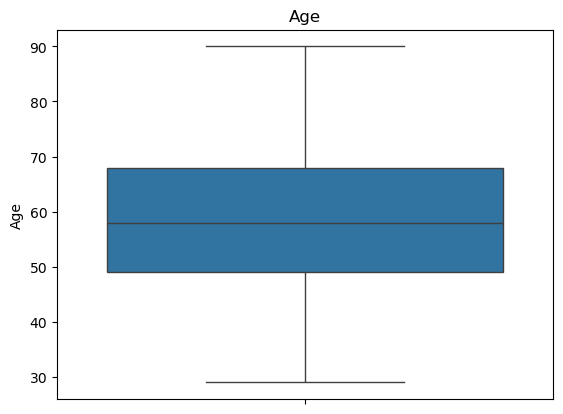

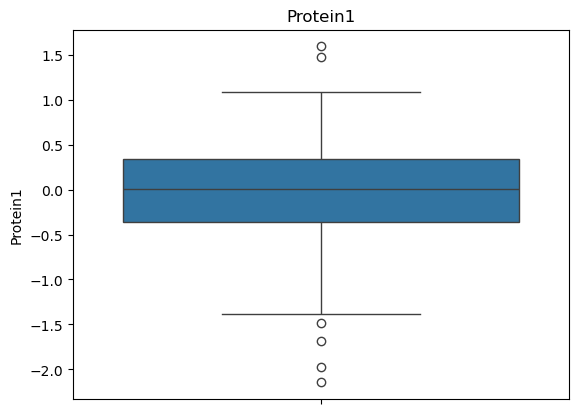

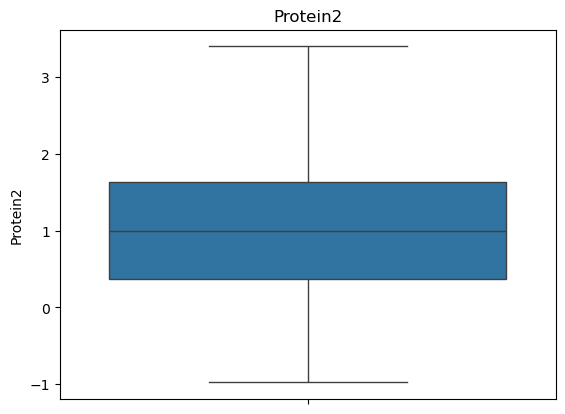

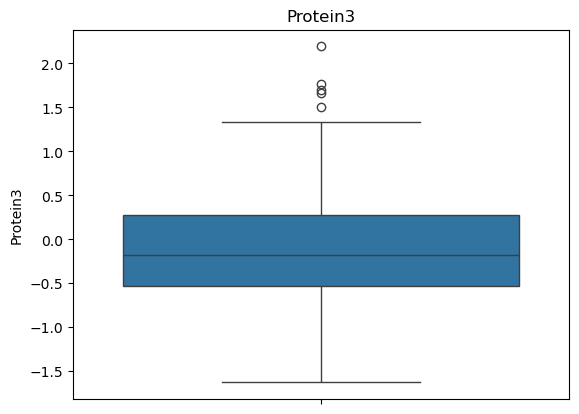

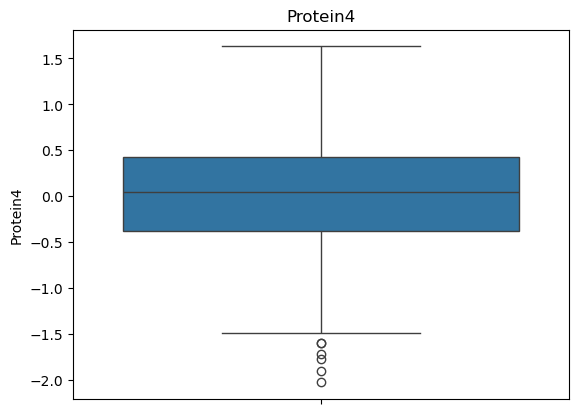

In [18]:
# CHECK FOR OUTLIERS
for i in numerical_cols:
    plt.title(i)
    sns.boxplot(df[i])
    
    plt.show()

* Some points appear as outliers in the box plot, but since they are not many, we don’t need to worry about them.

In [19]:
# CATEGORICAL COLUMNS 

# NUMBER OF UNIQUE CLASSES IN EACH COLUMN
temp = df[categorical_cols].nunique().reset_index()
unq_classes = []
value_counts = []
for i in categorical_cols:
    unq_classes.append(list(df[i].unique()))
    value_counts.append(dict(df[i].value_counts()))
                        
temp['unique_classes'] = unq_classes
temp['value_counts'] = value_counts

temp.rename(columns={'index':'columns',0:'nunique'},inplace=True)

In [20]:
# CLASS DISTRIBUTION OF EVERY COLUMNS
temp

,columns,nunique,unique_classes,value_counts
0,Gender,2,"[FEMALE, MALE]","{'FEMALE': 317, 'MALE': 4}"
1,Tumour_Stage,3,"[II, I, III]","{'II': 182, 'III': 78, 'I': 61}"
2,Histology,3,"[Infiltrating Ductal Carcinoma, Infiltrating Lobular Carcinoma, Mucinous Carcinoma]","{'Infiltrating Ductal Carcinoma': 226, 'Infiltrating Lobular Carcinoma': 83, 'Mucinous Carcinoma': 12}"
3,ER status,1,[Positive],{'Positive': 321}
4,PR status,1,[Positive],{'Positive': 321}
5,HER2 status,2,"[Negative, Positive]","{'Negative': 292, 'Positive': 29}"
6,Surgery_type,4,"[Other, Lumpectomy, Modified Radical Mastectomy, Simple Mastectomy]","{'Other': 98, 'Modified Radical Mastectomy': 92, 'Lumpectomy': 66, 'Simple Mastectomy': 65}"
7,Patient_Status,2,"[Alive, Dead]","{'Alive': 255, 'Dead': 66}"


* In our data, most of the patients are female (99%).
* The most common tumor stage among patients is stage 2, followed by stage 3, and then stage 1.
* The most common type of breast cancer in our data is Infiltrating Ductal Carcinoma.
* In HER2 status, 292 patients are negative, while only 29 are positive.
* The most common surgery type in our data is Modified Radical Mastectomy, followed by Lumpectomy, and then Simple Mastectomy.
* In our data, 255 people survived, while 66 people died.

## BIVARIATE ANALYSIS

* CATEGORICAL COLS VS TARGET COL

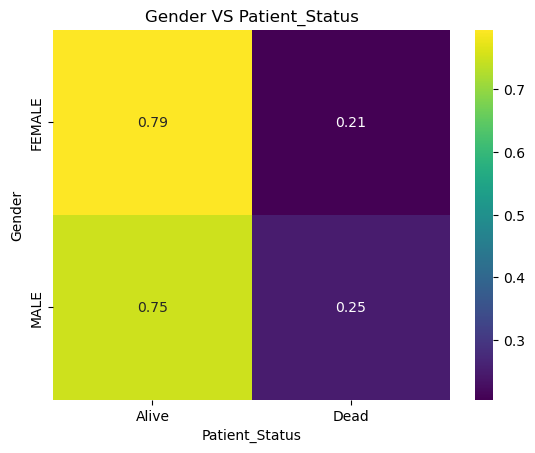

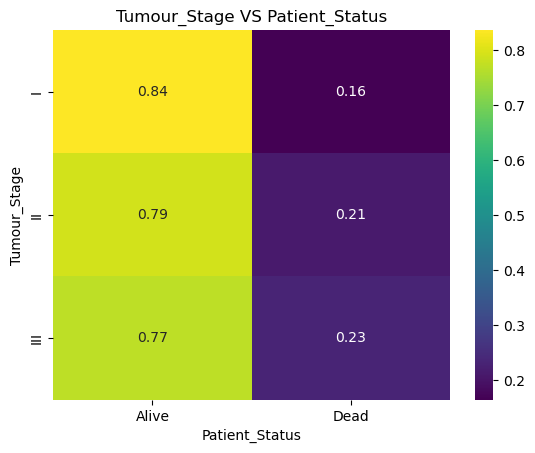

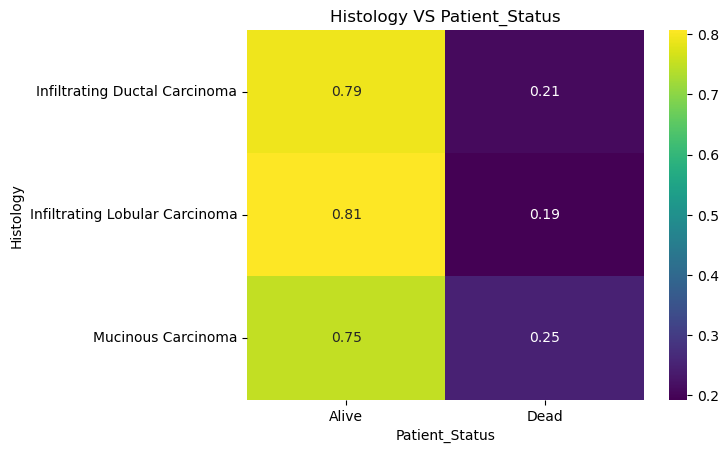

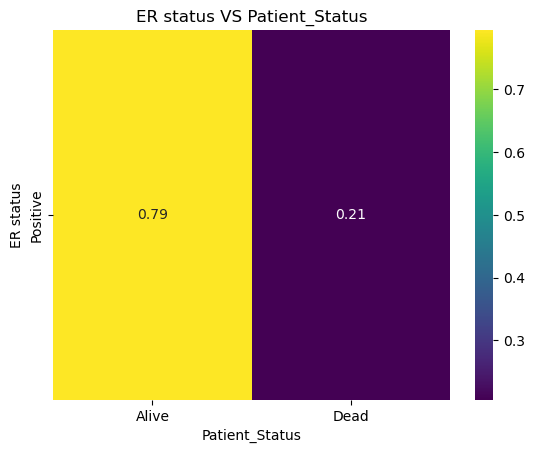

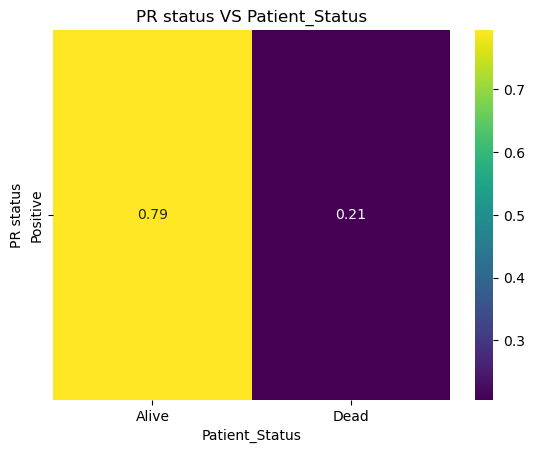

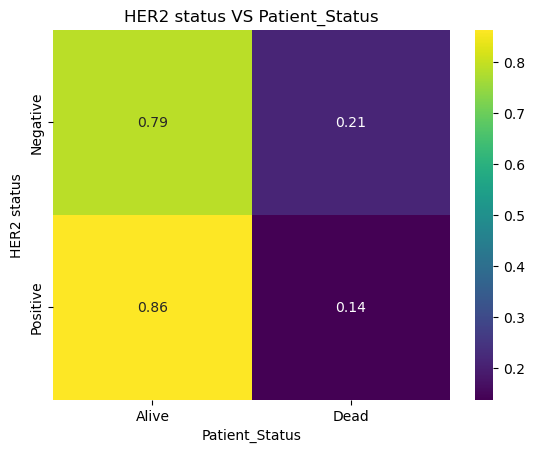

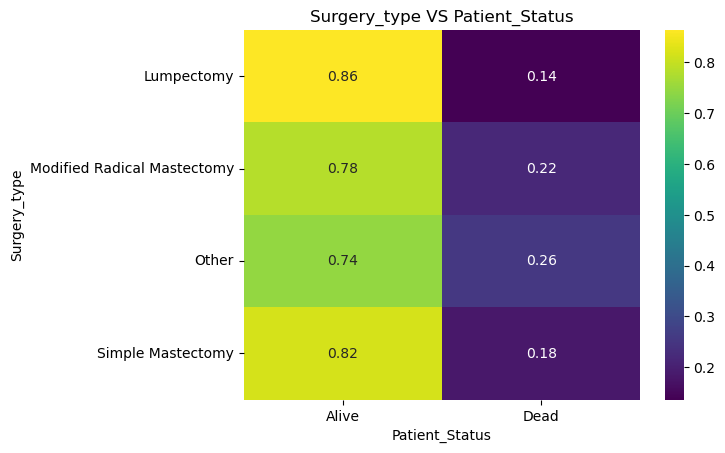

In [21]:
for i in categorical_cols[:-1]:
    tab = pd.crosstab(df[i],df["Patient_Status"],normalize='index')
    sns.heatmap(tab,cmap="viridis", fmt=".2f",annot=True)
    plt.title(i + ' VS '+"Patient_Status")
    plt.show()

* Both male and female have roughly equal chances of survival or death.
* As the tumor stage increases, the chances of death also increase.
* If the cancer type is mucinous carcinoma, there is a higher chance of death compared to infiltrating lobular carcinoma and infiltrating ductal carcinoma.
* Since the number of patients in the HER2-positive class is very low, we cannot draw definitive conclusions.
* Lumpectomy surgery has the highest survival rate, followed by simple mastectomy, then modified radical mastectomy, with the worst outcomes observed in other therapies.

* Based on these conclusions, we can say that Tumor Stage, Cancer Type, and Surgery Type are useful features for predicting survival, as they show a clear impact on patient outcomes. However, Age, Gender, and HER2 Status may not be strong predictors, as they do not show a significant correlation with survival in our dataset.

* NUMERICAL COLS VS TARGET COL

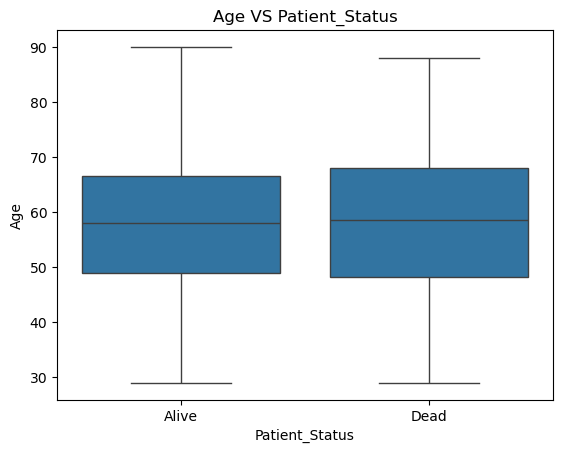

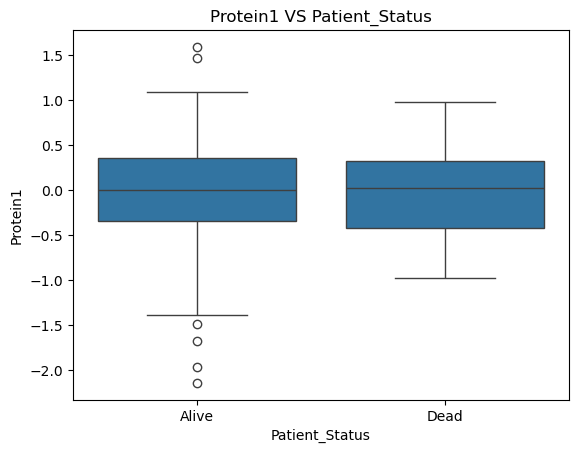

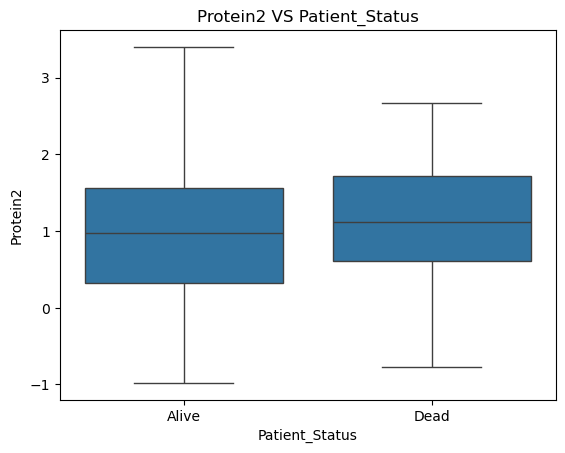

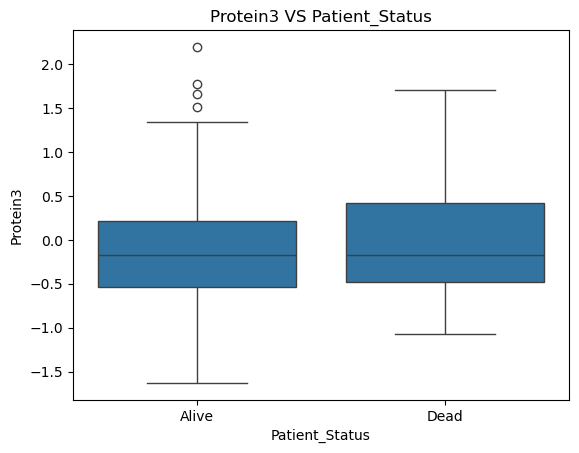

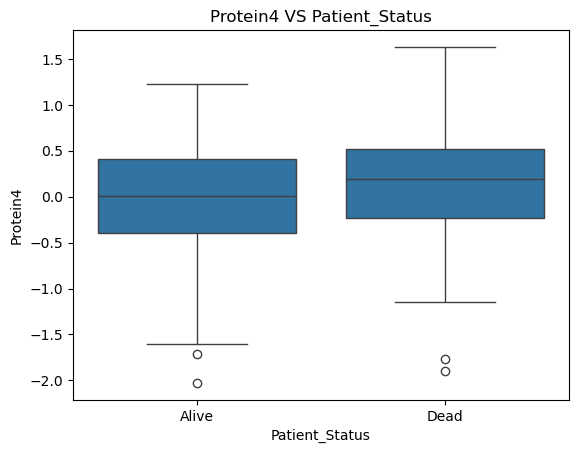

In [22]:
for i in numerical_cols:
    sns.boxplot(y=df[i],x=df['Patient_Status'])
    plt.title(i+" VS " + 'Patient_Status')
    plt.show()

* In terms of age, both the Alive and Dead groups have roughly the same distribution, so we can say that age does not significantly affect survival.
* The same applies to Protein 1, Protein 2, Protein 3, and Protein 4.

In [23]:
df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Patient_Status
0,42,FEMALE,0.952560,2.150000,0.007972,-0.048340,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Alive
1,54,FEMALE,0.000000,1.380200,-0.498030,-0.507320,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Dead
2,63,FEMALE,-0.523030,1.764000,-0.370190,0.010815,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Lumpectomy,Alive
3,78,FEMALE,-0.876180,0.129430,-0.370380,0.132190,I,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Alive
4,42,FEMALE,0.226110,1.749100,-0.543970,-0.390210,II,Infiltrating Ductal Carcinoma,Positive,Positive,Positive,Lumpectomy,Alive


# FEATURE SELECTION

In [24]:
# CONVERT ALL THE CATEGIES INTO NUMBERS
oe = OrdinalEncoder()
new_df = oe.fit_transform(df) # ENCODE ALL THE CATEGORICAL COLS TO NUMBERS

In [25]:
# MAKE A NEW DATAFRAME
new_df = pd.DataFrame(new_df,columns=(df.columns))
new_df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Patient_Status
0,9.000000,0.000000,310.000000,290.000000,197.000000,133.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
1,21.000000,0.000000,156.000000,203.000000,88.000000,61.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
2,30.000000,0.000000,55.000000,262.000000,115.000000,155.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,45.000000,0.000000,17.000000,63.000000,114.000000,173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
4,9.000000,0.000000,211.000000,259.000000,76.000000,77.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


## Technique 1 - Correlation Analysis

<Axes: >

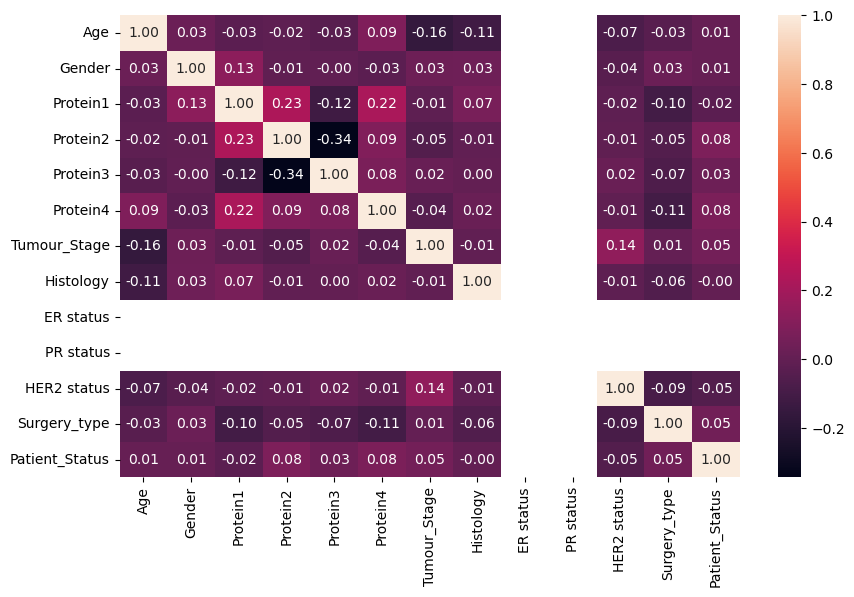

In [26]:
plt.figure(figsize=(10,6))
sns.heatmap(new_df.corr(),annot=True,fmt=".2f")

In [27]:
new_df.corr()['Patient_Status']

Age               0.012887
Gender            0.012339
Protein1         -0.024344
Protein2          0.082187
Protein3          0.029032
Protein4          0.078493
Tumour_Stage      0.052939
Histology        -0.000000
ER status              NaN
PR status              NaN
HER2 status      -0.052773
Surgery_type      0.049954
Patient_Status    1.000000
Name: Patient_Status, dtype: float64

# Technique 2 - Random Forest Feature Importance

In [28]:
# CREATE INPUT AND OUTPUT SET
x_label = new_df.drop(columns=['Patient_Status'])
y_label = new_df['Patient_Status']

In [29]:
# TRAIN A RANDOMFORESTCLASSIFIER MODEL
rf = RandomForestClassifier()
rf.fit(x_label,y_label)


RandomForestClassifier()

In [33]:
rnk1 = pd.DataFrame({'Features':x_label.columns,
             'Feature_importance':rf.feature_importances_}).sort_values(by='Feature_importance',ascending=False)
rnk1



,Features,Feature_importance
5,Protein4,0.182637
3,Protein2,0.171925
2,Protein1,0.170307
4,Protein3,0.163498
0,Age,0.154320
11,Surgery_type,0.060245
6,Tumour_Stage,0.048482
7,Histology,0.031220
10,HER2 status,0.011677
1,Gender,0.005690


# Technique 3 - Gradient Boosting Feature importances

In [32]:
# TRAIN A GRADIENTBOOSTINGCLASSIFIER
gbc = GradientBoostingClassifier()
gbc.fit(x_label,y_label)

GradientBoostingClassifier()

In [34]:
rnk2 = pd.DataFrame({'Features':x_label.columns,
             'Feature_importance':gbc.feature_importances_}).sort_values(by='Feature_importance',ascending=False)
rnk2

,Features,Feature_importance
2,Protein1,0.264245
4,Protein3,0.192018
3,Protein2,0.189755
5,Protein4,0.166805
0,Age,0.105803
6,Tumour_Stage,0.030653
11,Surgery_type,0.030243
10,HER2 status,0.009428
7,Histology,0.007352
1,Gender,0.003697


# Technique 4 - Permutation Importance

In [38]:
# CREATE TRAINING AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x_label,y_label,test_size=0.2)

# TRAIN A RANDOM FOREST CLASSIFIER MODEL
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

# CALCULATE PERMUTATION SCORE
perm_imp = permutation_importance(rf,x_train,y_train , n_repeats=30,random_state=42)

In [44]:
rnk3 = pd.DataFrame({'Features':x_label.columns,
             'Feature_importance':perm_imp.importances_mean}).sort_values(by='Feature_importance',ascending=False)
rnk3


,Features,Feature_importance
3,Protein2,0.094141
0,Age,0.083203
4,Protein3,0.081771
5,Protein4,0.079557
2,Protein1,0.068620
6,Tumour_Stage,0.035156
11,Surgery_type,0.033333
7,Histology,0.015234
1,Gender,0.003646
10,HER2 status,0.001042


* BASED ON THESE TECHNIQUES WE CAN CONCLUDE THAT ER STATUS , PR STATUS AND GENDER ARE NOT USEFUL SO WE CAN DROP THESE COLUMNS.

In [47]:
df.drop(columns=['ER status','PR status','Gender'],inplace=True)

In [48]:
df.head()

,Age,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,HER2 status,Surgery_type,Patient_Status
0,42,0.952560,2.150000,0.007972,-0.048340,II,Infiltrating Ductal Carcinoma,Negative,Other,Alive
1,54,0.000000,1.380200,-0.498030,-0.507320,II,Infiltrating Ductal Carcinoma,Negative,Other,Dead
2,63,-0.523030,1.764000,-0.370190,0.010815,II,Infiltrating Ductal Carcinoma,Negative,Lumpectomy,Alive
3,78,-0.876180,0.129430,-0.370380,0.132190,I,Infiltrating Ductal Carcinoma,Negative,Other,Alive
4,42,0.226110,1.749100,-0.543970,-0.390210,II,Infiltrating Ductal Carcinoma,Positive,Lumpectomy,Alive


# MODEL SELECTION

In [77]:
# CREATE COLUMN TRANSFORMER
ct  = ColumnTransformer(transformers=[
    ('encoding',OrdinalEncoder(),['Histology','HER2 status','Surgery_type']),
    ('encoding_ordered',OrdinalEncoder(categories=[['I','II','III']]),['Tumour_Stage']),
    ('scaling',MinMaxScaler(),['Age','Protein1','Protein2','Protein3','Protein4'])
],remainder='passthrough')

In [60]:
# FUNCTION TO CHECK MODEL SCORE
def score_checker(model_name,model,inputs,outputs):
    pipeline = Pipeline([
        ('preprocessing',ct),
        ('model_training',model)
    ])
    score = cross_val_score(pipeline,inputs,outputs,cv=5,scoring='accuracy').mean()
    return score
    

In [64]:
# INPUTS AND OUTPUTS
x_label = df.drop(columns=['Patient_Status'])
y_label = df['Patient_Status'].map({'Alive':1,'Dead':0})


In [69]:
model_dict = {
    'logistic_regression': LogisticRegression(solver='liblinear'),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'extra_trees': ExtraTreeClassifier(),
    'gradient_boosting': GradientBoostingClassifier(),
    'adaboost': AdaBoostClassifier(),
    'bagging': BaggingClassifier(),
    'stacking': StackingClassifier(estimators=[('rf', RandomForestClassifier()), ('gb', GradientBoostingClassifier())]),
    'voting': VotingClassifier(estimators=[('lr', LogisticRegression()), ('svc', SVC(probability=True))]),
    'svm': SVC(),
    'knn': KNeighborsClassifier(),
    'naive_bayes': GaussianNB(),
    'xgboost': XGBClassifier(),
    'lightgbm': LGBMClassifier(),
    'catboost': CatBoostClassifier(verbose=0)
}

In [78]:
# CHECK FOR EVERY ALGORITHM
score = {}
for model_name,model in model_dict.items():
    score[model_name] = score_checker(model_name,model,x_label,y_label)
    

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 242, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
                        ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Yogesh\anaconda3\Lib\site-packages

[LightGBM] [Info] Number of positive: 204, number of negative: 52
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 256, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.796875 -> initscore=1.366876
[LightGBM] [Info] Start training from score 1.366876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [79]:
score

{'logistic_regression': 0.7944230769230769,
 'decision_tree': 0.6389423076923076,
 'random_forest': 0.7788942307692308,
 'extra_trees': 0.6698557692307692,
 'gradient_boosting': 0.7695192307692308,
 'adaboost': 0.7820192307692307,
 'bagging': 0.7008173076923077,
 'stacking': 0.7944230769230769,
 'voting': 0.7944230769230769,
 'svm': 0.7944230769230769,
 'knn': 0.7571153846153846,
 'naive_bayes': 0.7881730769230769,
 'xgboost': nan,
 'lightgbm': 0.7385096153846155,
 'catboost': 0.7882211538461539}

* Support Vector Machine and Logistic Regression are performing the best, so we will tune one of them. Let's select SVM and tune its parameters.

# PARAMETER TUNNING

In [81]:
# IMPORT OPTUNA
import optuna

In [93]:
# DEFINE OBJECTIVE FUNCTION
def objective(trial):
    # SUGGESTED PARAMETERS
    C = trial.suggest_float('C',0.001,1)
    kernel = trial.suggest_categorical('kernel',['linear','poly','sigmoid','rbf'])
    if kernel=='poly':
        degree = trial.suggest_int('degree',2,10)
    else:
        degree = 3
    if kernel in ['poly','sigmoid']:
        coef0 = trial.suggest_float('coef0', 0.0, 10.0)
    else:
        coef0 = 0
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto', 0.01, 0.1, 1, 10])

    model = SVC(C=C,kernel=kernel,degree=degree,coef0=coef0,gamma=gamma)

    score = cross_val_score(model,ct.fit_transform(x_label),y_label,cv=3,scoring='accuracy').mean()
    return score
    

In [95]:
# CREATE A STUDY
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=100)

[I 2025-03-13 23:43:29,802] A new study created in memory with name: no-name-e25527f5-47ad-494f-8eb4-06f06c2fe96f
[I 2025-03-13 23:43:29,867] Trial 0 finished with value: 0.7943925233644858 and parameters: {'C': 0.5806752210980556, 'kernel': 'sigmoid', 'coef0': 2.442422044165513, 'gamma': 10}. Best is trial 0 with value: 0.7943925233644858.
[I 2025-03-13 23:43:29,911] Trial 1 finished with value: 0.7943925233644858 and parameters: {'C': 0.08116425614005685, 'kernel': 'linear', 'gamma': 0.01}. Best is trial 0 with value: 0.7943925233644858.
[I 2025-03-13 23:43:29,948] Trial 2 finished with value: 0.7943925233644858 and parameters: {'C': 0.9880196459077267, 'kernel': 'sigmoid', 'coef0': 0.40775160980066283, 'gamma': 10}. Best is trial 0 with value: 0.7943925233644858.
[I 2025-03-13 23:43:29,989] Trial 3 finished with value: 0.7943925233644858 and parameters: {'C': 0.006467676220358031, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.7943925233644858.
[I 2025-03-13 23:43

In [100]:
print(study.best_value)
print(study.best_params)

0.7943925233644858
{'C': 0.5806752210980556, 'kernel': 'sigmoid', 'coef0': 2.442422044165513, 'gamma': 10}


## LET'S TRY WITH CATBOOST

In [101]:
# DEFINE OBJECTIVE FUNCTION
def objective(trial):
    # SUGGESTED PARAMETERS
    iterations = trial.suggest_int('iterations',50,200)
    learning_rate = trial.suggest_float('learning_rate',0.1,0.9)
    depth = trial.suggest_int('depth',2,11)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg',1,10)
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds',10,60)

    # CREATE THE CATBOOSTCLASSIFIER WITH SUGGESTED PARAMETERS
    model = CatBoostClassifier(iterations=iterations,learning_rate=learning_rate,depth=depth,l2_leaf_reg=l2_leaf_reg,
                        early_stopping_rounds=early_stopping_rounds)
    score = cross_val_score(model,ct.fit_transform(x_label),y_label,cv=3,scoring='accuracy').mean()
    return score
    
      

In [102]:
# CREATE A STUDY
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=100)

[I 2025-03-13 23:55:00,901] A new study created in memory with name: no-name-7007edd2-1ccb-469f-91a4-c4f18419f454


0:	learn: 0.5513961	total: 1.2ms	remaining: 212ms
1:	learn: 0.5081720	total: 3.45ms	remaining: 304ms
2:	learn: 0.4832123	total: 4.22ms	remaining: 246ms
3:	learn: 0.4727194	total: 4.85ms	remaining: 211ms
4:	learn: 0.4570990	total: 5.6ms	remaining: 194ms
5:	learn: 0.4538604	total: 6.35ms	remaining: 182ms
6:	learn: 0.4373466	total: 7.13ms	remaining: 174ms
7:	learn: 0.4291327	total: 7.84ms	remaining: 167ms
8:	learn: 0.4115080	total: 8.57ms	remaining: 161ms
9:	learn: 0.4027354	total: 9.28ms	remaining: 156ms
10:	learn: 0.3774098	total: 9.9ms	remaining: 150ms
11:	learn: 0.3668810	total: 10.7ms	remaining: 147ms
12:	learn: 0.3605586	total: 11.3ms	remaining: 144ms
13:	learn: 0.3538865	total: 12.1ms	remaining: 141ms
14:	learn: 0.3379010	total: 12.8ms	remaining: 139ms
15:	learn: 0.3226245	total: 13.4ms	remaining: 136ms
16:	learn: 0.3130352	total: 14.1ms	remaining: 134ms
17:	learn: 0.3076743	total: 14.8ms	remaining: 131ms
18:	learn: 0.2957228	total: 15.8ms	remaining: 132ms
19:	learn: 0.2848030	tota

[I 2025-03-13 23:55:01,637] Trial 0 finished with value: 0.7258566978193146 and parameters: {'iterations': 178, 'learning_rate': 0.5862235702680171, 'depth': 3, 'l2_leaf_reg': 1, 'early_stopping_rounds': 10}. Best is trial 0 with value: 0.7258566978193146.


0:	learn: 0.5443824	total: 989us	remaining: 175ms
1:	learn: 0.5070025	total: 2.2ms	remaining: 193ms
2:	learn: 0.4949037	total: 2.88ms	remaining: 168ms
3:	learn: 0.4771913	total: 3.52ms	remaining: 153ms
4:	learn: 0.4727993	total: 4.22ms	remaining: 146ms
5:	learn: 0.4596537	total: 4.91ms	remaining: 141ms
6:	learn: 0.4389571	total: 5.56ms	remaining: 136ms
7:	learn: 0.4350799	total: 6.17ms	remaining: 131ms
8:	learn: 0.4266570	total: 6.87ms	remaining: 129ms
9:	learn: 0.4128210	total: 7.51ms	remaining: 126ms
10:	learn: 0.4000778	total: 8.16ms	remaining: 124ms
11:	learn: 0.3925812	total: 8.93ms	remaining: 123ms
12:	learn: 0.3865244	total: 9.64ms	remaining: 122ms
13:	learn: 0.3731243	total: 10.2ms	remaining: 120ms
14:	learn: 0.3539871	total: 10.9ms	remaining: 119ms
15:	learn: 0.3458428	total: 11.5ms	remaining: 117ms
16:	learn: 0.3406950	total: 12.1ms	remaining: 115ms
17:	learn: 0.3312983	total: 12.7ms	remaining: 113ms
18:	learn: 0.3176362	total: 13.5ms	remaining: 113ms
19:	learn: 0.3064728	tot

[I 2025-03-13 23:55:04,223] Trial 1 finished with value: 0.7538940809968847 and parameters: {'iterations': 200, 'learning_rate': 0.1405549456020646, 'depth': 7, 'l2_leaf_reg': 2, 'early_stopping_rounds': 32}. Best is trial 1 with value: 0.7538940809968847.


163:	learn: 0.0117269	total: 592ms	remaining: 130ms
164:	learn: 0.0115921	total: 596ms	remaining: 127ms
165:	learn: 0.0115547	total: 600ms	remaining: 123ms
166:	learn: 0.0114120	total: 604ms	remaining: 119ms
167:	learn: 0.0113452	total: 607ms	remaining: 116ms
168:	learn: 0.0112352	total: 611ms	remaining: 112ms
169:	learn: 0.0112264	total: 615ms	remaining: 108ms
170:	learn: 0.0110449	total: 618ms	remaining: 105ms
171:	learn: 0.0110230	total: 622ms	remaining: 101ms
172:	learn: 0.0110085	total: 625ms	remaining: 97.5ms
173:	learn: 0.0108766	total: 629ms	remaining: 94ms
174:	learn: 0.0107726	total: 632ms	remaining: 90.3ms
175:	learn: 0.0106593	total: 636ms	remaining: 86.7ms
176:	learn: 0.0105461	total: 639ms	remaining: 83.1ms
177:	learn: 0.0105356	total: 643ms	remaining: 79.5ms
178:	learn: 0.0105135	total: 647ms	remaining: 75.9ms
179:	learn: 0.0104374	total: 650ms	remaining: 72.2ms
180:	learn: 0.0103979	total: 653ms	remaining: 68.6ms
181:	learn: 0.0103394	total: 657ms	remaining: 64.9ms
182:

[I 2025-03-13 23:55:05,106] Trial 2 finished with value: 0.7383177570093458 and parameters: {'iterations': 192, 'learning_rate': 0.8926838535416158, 'depth': 4, 'l2_leaf_reg': 3, 'early_stopping_rounds': 44}. Best is trial 1 with value: 0.7538940809968847.


39:	learn: 0.1753714	total: 33.9ms	remaining: 129ms
40:	learn: 0.1677237	total: 35.4ms	remaining: 130ms
41:	learn: 0.1626256	total: 36.2ms	remaining: 129ms
42:	learn: 0.1610442	total: 37.1ms	remaining: 128ms
43:	learn: 0.1567202	total: 38ms	remaining: 128ms
44:	learn: 0.1554121	total: 38.9ms	remaining: 127ms
45:	learn: 0.1550810	total: 39.7ms	remaining: 126ms
46:	learn: 0.1528242	total: 40.5ms	remaining: 125ms
47:	learn: 0.1491659	total: 41.4ms	remaining: 124ms
48:	learn: 0.1488364	total: 42.1ms	remaining: 123ms
49:	learn: 0.1474831	total: 42.9ms	remaining: 122ms
50:	learn: 0.1472365	total: 43.7ms	remaining: 121ms
51:	learn: 0.1445018	total: 44.7ms	remaining: 120ms
52:	learn: 0.1376472	total: 45.6ms	remaining: 120ms
53:	learn: 0.1373292	total: 46.6ms	remaining: 119ms
54:	learn: 0.1371437	total: 47.4ms	remaining: 118ms
55:	learn: 0.1342744	total: 48.2ms	remaining: 117ms
56:	learn: 0.1333219	total: 49.1ms	remaining: 116ms
57:	learn: 0.1315298	total: 50.1ms	remaining: 116ms
58:	learn: 0.1

[I 2025-03-13 23:55:05,641] Trial 3 finished with value: 0.7476635514018691 and parameters: {'iterations': 146, 'learning_rate': 0.7530621074639082, 'depth': 3, 'l2_leaf_reg': 4, 'early_stopping_rounds': 22}. Best is trial 1 with value: 0.7538940809968847.


77:	learn: 0.1798094	total: 58.6ms	remaining: 51ms
78:	learn: 0.1769181	total: 60.1ms	remaining: 50.9ms
79:	learn: 0.1755342	total: 60.8ms	remaining: 50.2ms
80:	learn: 0.1744878	total: 61.5ms	remaining: 49.4ms
81:	learn: 0.1718541	total: 62.2ms	remaining: 48.6ms
82:	learn: 0.1714761	total: 62.9ms	remaining: 47.7ms
83:	learn: 0.1713171	total: 63.6ms	remaining: 46.9ms
84:	learn: 0.1687667	total: 64.2ms	remaining: 46.1ms
85:	learn: 0.1667704	total: 65.2ms	remaining: 45.5ms
86:	learn: 0.1645998	total: 66.2ms	remaining: 44.9ms
87:	learn: 0.1623337	total: 66.9ms	remaining: 44.1ms
88:	learn: 0.1621975	total: 67.5ms	remaining: 43.2ms
89:	learn: 0.1620704	total: 68.2ms	remaining: 42.5ms
90:	learn: 0.1610220	total: 68.9ms	remaining: 41.6ms
91:	learn: 0.1598719	total: 69.6ms	remaining: 40.8ms
92:	learn: 0.1597384	total: 70.3ms	remaining: 40.1ms
93:	learn: 0.1583060	total: 70.9ms	remaining: 39.2ms
94:	learn: 0.1574984	total: 71.8ms	remaining: 38.5ms
95:	learn: 0.1572864	total: 72.5ms	remaining: 37

[I 2025-03-13 23:55:06,189] Trial 4 finished with value: 0.7538940809968847 and parameters: {'iterations': 59, 'learning_rate': 0.5847909348885336, 'depth': 5, 'l2_leaf_reg': 1, 'early_stopping_rounds': 52}. Best is trial 1 with value: 0.7538940809968847.


54:	learn: 0.0694149	total: 69.3ms	remaining: 5.04ms
55:	learn: 0.0691741	total: 73.4ms	remaining: 3.93ms
56:	learn: 0.0675596	total: 109ms	remaining: 3.82ms
57:	learn: 0.0671869	total: 117ms	remaining: 2.02ms
58:	learn: 0.0645778	total: 122ms	remaining: 0us
0:	learn: 0.6773318	total: 230ms	remaining: 42.1s
1:	learn: 0.6586401	total: 540ms	remaining: 49.1s
2:	learn: 0.6015503	total: 546ms	remaining: 32.9s
3:	learn: 0.5605258	total: 551ms	remaining: 24.8s
4:	learn: 0.5450345	total: 886ms	remaining: 31.7s
5:	learn: 0.5366714	total: 994ms	remaining: 29.5s
6:	learn: 0.5278629	total: 1.1s	remaining: 27.8s
7:	learn: 0.5188799	total: 1.21s	remaining: 26.6s
8:	learn: 0.5096419	total: 1.31s	remaining: 25.5s
9:	learn: 0.4858248	total: 1.31s	remaining: 22.9s
10:	learn: 0.4775752	total: 1.42s	remaining: 22.3s
11:	learn: 0.4698747	total: 1.54s	remaining: 22s
12:	learn: 0.4619384	total: 1.64s	remaining: 21.6s
13:	learn: 0.4543080	total: 1.74s	remaining: 21.1s
14:	learn: 0.4461917	total: 1.84s	remain

[I 2025-03-13 23:56:05,029] Trial 5 finished with value: 0.7757009345794392 and parameters: {'iterations': 184, 'learning_rate': 0.41835188025456294, 'depth': 11, 'l2_leaf_reg': 9, 'early_stopping_rounds': 21}. Best is trial 5 with value: 0.7757009345794392.


183:	learn: 0.0784809	total: 19.7s	remaining: 0us
0:	learn: 0.6212087	total: 5.46ms	remaining: 268ms
1:	learn: 0.5451512	total: 7.17ms	remaining: 172ms
2:	learn: 0.4907993	total: 11.1ms	remaining: 174ms
3:	learn: 0.4555132	total: 16.4ms	remaining: 189ms
4:	learn: 0.4260754	total: 21.1ms	remaining: 190ms
5:	learn: 0.3990397	total: 25.9ms	remaining: 190ms
6:	learn: 0.3812967	total: 29.9ms	remaining: 184ms
7:	learn: 0.3616249	total: 36.7ms	remaining: 193ms
8:	learn: 0.3399122	total: 41.4ms	remaining: 189ms
9:	learn: 0.3213566	total: 45.6ms	remaining: 183ms
10:	learn: 0.3077140	total: 53.1ms	remaining: 188ms
11:	learn: 0.2947497	total: 58.4ms	remaining: 185ms
12:	learn: 0.2789131	total: 62.8ms	remaining: 179ms
13:	learn: 0.2691578	total: 67.3ms	remaining: 173ms
14:	learn: 0.2563527	total: 71.8ms	remaining: 167ms
15:	learn: 0.2461520	total: 76.3ms	remaining: 162ms
16:	learn: 0.2333521	total: 85.1ms	remaining: 165ms
17:	learn: 0.2221773	total: 89.8ms	remaining: 160ms
18:	learn: 0.2073171	tot

[I 2025-03-13 23:56:05,990] Trial 6 finished with value: 0.7694704049844238 and parameters: {'iterations': 50, 'learning_rate': 0.46119156113246695, 'depth': 8, 'l2_leaf_reg': 2, 'early_stopping_rounds': 57}. Best is trial 5 with value: 0.7757009345794392.


43:	learn: 0.1051202	total: 208ms	remaining: 28.3ms
44:	learn: 0.1016177	total: 213ms	remaining: 23.6ms
45:	learn: 0.1012314	total: 217ms	remaining: 18.9ms
46:	learn: 0.0969077	total: 221ms	remaining: 14.1ms
47:	learn: 0.0933243	total: 225ms	remaining: 9.38ms
48:	learn: 0.0912865	total: 230ms	remaining: 4.69ms
49:	learn: 0.0886208	total: 234ms	remaining: 0us
0:	learn: 0.6866402	total: 143ms	remaining: 24.7s
1:	learn: 0.6787312	total: 284ms	remaining: 24.4s
2:	learn: 0.6519825	total: 285ms	remaining: 16.3s
3:	learn: 0.6274621	total: 287ms	remaining: 12.2s
4:	learn: 0.6191753	total: 409ms	remaining: 13.8s
5:	learn: 0.6143950	total: 522ms	remaining: 14.6s
6:	learn: 0.6100002	total: 632ms	remaining: 15.1s
7:	learn: 0.6050070	total: 744ms	remaining: 15.4s
8:	learn: 0.5980661	total: 788ms	remaining: 14.4s
9:	learn: 0.5840498	total: 791ms	remaining: 13s
10:	learn: 0.5767767	total: 896ms	remaining: 13.3s
11:	learn: 0.5726144	total: 1.01s	remaining: 13.6s
12:	learn: 0.5657224	total: 1.02s	remai

[I 2025-03-13 23:56:56,668] Trial 7 finished with value: 0.7850467289719626 and parameters: {'iterations': 174, 'learning_rate': 0.17075160782306426, 'depth': 11, 'l2_leaf_reg': 9, 'early_stopping_rounds': 20}. Best is trial 7 with value: 0.7850467289719626.


172:	learn: 0.1958425	total: 15.9s	remaining: 91.7ms
173:	learn: 0.1948651	total: 16s	remaining: 0us
0:	learn: 0.5995391	total: 1.07ms	remaining: 119ms
1:	learn: 0.5553491	total: 2.14ms	remaining: 118ms
2:	learn: 0.5295516	total: 2.95ms	remaining: 107ms
3:	learn: 0.5156439	total: 3.71ms	remaining: 100ms
4:	learn: 0.5041178	total: 4.43ms	remaining: 94.9ms
5:	learn: 0.4890390	total: 5.35ms	remaining: 94.6ms
6:	learn: 0.4815312	total: 6.07ms	remaining: 91.1ms
7:	learn: 0.4740296	total: 6.82ms	remaining: 88.6ms
8:	learn: 0.4677836	total: 7.68ms	remaining: 87.9ms
9:	learn: 0.4627867	total: 8.36ms	remaining: 85.3ms
10:	learn: 0.4594482	total: 8.99ms	remaining: 82.5ms
11:	learn: 0.4516127	total: 9.59ms	remaining: 79.9ms
12:	learn: 0.4462603	total: 10.2ms	remaining: 77.7ms
13:	learn: 0.4444922	total: 10.9ms	remaining: 76ms
14:	learn: 0.4368035	total: 11.6ms	remaining: 75.1ms
15:	learn: 0.4316679	total: 12.4ms	remaining: 74.2ms
16:	learn: 0.4240562	total: 13.2ms	remaining: 73.6ms
17:	learn: 0.4

[I 2025-03-13 23:56:57,118] Trial 8 finished with value: 0.7725856697819315 and parameters: {'iterations': 112, 'learning_rate': 0.4728505364430531, 'depth': 3, 'l2_leaf_reg': 7, 'early_stopping_rounds': 23}. Best is trial 7 with value: 0.7850467289719626.


52:	learn: 0.3255823	total: 38.6ms	remaining: 43ms
53:	learn: 0.3230928	total: 40.1ms	remaining: 43.1ms
54:	learn: 0.3202776	total: 40.8ms	remaining: 42.3ms
55:	learn: 0.3165022	total: 41.5ms	remaining: 41.5ms
56:	learn: 0.3161892	total: 42.1ms	remaining: 40.6ms
57:	learn: 0.3139121	total: 42.9ms	remaining: 40ms
58:	learn: 0.3136229	total: 43.8ms	remaining: 39.4ms
59:	learn: 0.3098140	total: 44.5ms	remaining: 38.6ms
60:	learn: 0.3088567	total: 45.2ms	remaining: 37.8ms
61:	learn: 0.3056916	total: 45.8ms	remaining: 36.9ms
62:	learn: 0.3055641	total: 46.5ms	remaining: 36.2ms
63:	learn: 0.3052034	total: 47.2ms	remaining: 35.4ms
64:	learn: 0.3028097	total: 47.9ms	remaining: 34.6ms
65:	learn: 0.3025216	total: 48.7ms	remaining: 33.9ms
66:	learn: 0.3022433	total: 49.5ms	remaining: 33.2ms
67:	learn: 0.3009597	total: 50.2ms	remaining: 32.5ms
68:	learn: 0.2987837	total: 51ms	remaining: 31.8ms
69:	learn: 0.2975066	total: 51.7ms	remaining: 31ms
70:	learn: 0.2942883	total: 52.4ms	remaining: 30.3ms
7

[I 2025-03-13 23:56:58,217] Trial 9 finished with value: 0.7912772585669782 and parameters: {'iterations': 109, 'learning_rate': 0.217317300576691, 'depth': 7, 'l2_leaf_reg': 8, 'early_stopping_rounds': 38}. Best is trial 9 with value: 0.7912772585669782.


52:	learn: 0.3235981	total: 133ms	remaining: 141ms
53:	learn: 0.3212754	total: 136ms	remaining: 138ms
54:	learn: 0.3200513	total: 138ms	remaining: 136ms
55:	learn: 0.3187556	total: 141ms	remaining: 133ms
56:	learn: 0.3160059	total: 143ms	remaining: 131ms
57:	learn: 0.3138749	total: 146ms	remaining: 128ms
58:	learn: 0.3117095	total: 148ms	remaining: 126ms
59:	learn: 0.3095038	total: 151ms	remaining: 123ms
60:	learn: 0.3076858	total: 153ms	remaining: 121ms
61:	learn: 0.3054541	total: 156ms	remaining: 118ms
62:	learn: 0.3044103	total: 159ms	remaining: 116ms
63:	learn: 0.3030244	total: 161ms	remaining: 114ms
64:	learn: 0.3015277	total: 164ms	remaining: 111ms
65:	learn: 0.3005595	total: 166ms	remaining: 108ms
66:	learn: 0.2981518	total: 168ms	remaining: 106ms
67:	learn: 0.2941554	total: 171ms	remaining: 103ms
68:	learn: 0.2907244	total: 173ms	remaining: 100ms
69:	learn: 0.2898575	total: 176ms	remaining: 97.8ms
70:	learn: 0.2892651	total: 178ms	remaining: 95.3ms
71:	learn: 0.2876647	total: 1

[I 2025-03-13 23:57:00,622] Trial 10 finished with value: 0.7850467289719626 and parameters: {'iterations': 92, 'learning_rate': 0.29436412552104174, 'depth': 9, 'l2_leaf_reg': 6, 'early_stopping_rounds': 39}. Best is trial 9 with value: 0.7912772585669782.


73:	learn: 0.1993156	total: 555ms	remaining: 135ms
74:	learn: 0.1974573	total: 564ms	remaining: 128ms
75:	learn: 0.1957315	total: 574ms	remaining: 121ms
76:	learn: 0.1930507	total: 582ms	remaining: 113ms
77:	learn: 0.1924598	total: 591ms	remaining: 106ms
78:	learn: 0.1906570	total: 599ms	remaining: 98.5ms
79:	learn: 0.1879564	total: 607ms	remaining: 91.1ms
80:	learn: 0.1852957	total: 616ms	remaining: 83.6ms
81:	learn: 0.1848873	total: 623ms	remaining: 76ms
82:	learn: 0.1830096	total: 630ms	remaining: 68.3ms
83:	learn: 0.1807035	total: 637ms	remaining: 60.7ms
84:	learn: 0.1793163	total: 645ms	remaining: 53.1ms
85:	learn: 0.1777041	total: 652ms	remaining: 45.5ms
86:	learn: 0.1751249	total: 660ms	remaining: 37.9ms
87:	learn: 0.1721524	total: 667ms	remaining: 30.3ms
88:	learn: 0.1718765	total: 674ms	remaining: 22.7ms
89:	learn: 0.1697982	total: 680ms	remaining: 15.1ms
90:	learn: 0.1690938	total: 688ms	remaining: 7.56ms
91:	learn: 0.1672935	total: 695ms	remaining: 0us
0:	learn: 0.6892318	to

[I 2025-03-13 23:57:37,016] Trial 11 finished with value: 0.7943925233644858 and parameters: {'iterations': 142, 'learning_rate': 0.1131028536521959, 'depth': 11, 'l2_leaf_reg': 10, 'early_stopping_rounds': 32}. Best is trial 11 with value: 0.7943925233644858.


140:	learn: 0.3117289	total: 11.7s	remaining: 83ms
141:	learn: 0.3106059	total: 11.8s	remaining: 0us
0:	learn: 0.6804747	total: 11.8ms	remaining: 1.64s
1:	learn: 0.6655699	total: 21ms	remaining: 1.45s
2:	learn: 0.6265017	total: 23ms	remaining: 1.05s
3:	learn: 0.6109501	total: 31.6ms	remaining: 1.07s
4:	learn: 0.5908234	total: 34.6ms	remaining: 935ms
5:	learn: 0.5782087	total: 42ms	remaining: 938ms
6:	learn: 0.5639340	total: 45.1ms	remaining: 856ms
7:	learn: 0.5527740	total: 53ms	remaining: 875ms
8:	learn: 0.5435078	total: 60.6ms	remaining: 882ms
9:	learn: 0.5352669	total: 68.2ms	remaining: 886ms
10:	learn: 0.5264180	total: 75.3ms	remaining: 884ms
11:	learn: 0.5023948	total: 75.9ms	remaining: 810ms
12:	learn: 0.4963763	total: 83.8ms	remaining: 819ms
13:	learn: 0.4901370	total: 90.8ms	remaining: 817ms
14:	learn: 0.4827686	total: 98.4ms	remaining: 820ms
15:	learn: 0.4702731	total: 98.9ms	remaining: 767ms
16:	learn: 0.4653930	total: 106ms	remaining: 765ms
17:	learn: 0.4584742	total: 107ms	

[I 2025-03-13 23:57:40,520] Trial 12 finished with value: 0.7881619937694704 and parameters: {'iterations': 140, 'learning_rate': 0.2938752088631875, 'depth': 9, 'l2_leaf_reg': 10, 'early_stopping_rounds': 32}. Best is trial 11 with value: 0.7943925233644858.


119:	learn: 0.1922236	total: 868ms	remaining: 145ms
120:	learn: 0.1918946	total: 877ms	remaining: 138ms
121:	learn: 0.1902869	total: 884ms	remaining: 130ms
122:	learn: 0.1890577	total: 892ms	remaining: 123ms
123:	learn: 0.1885990	total: 900ms	remaining: 116ms
124:	learn: 0.1869066	total: 908ms	remaining: 109ms
125:	learn: 0.1856237	total: 915ms	remaining: 102ms
126:	learn: 0.1841648	total: 924ms	remaining: 94.6ms
127:	learn: 0.1827418	total: 931ms	remaining: 87.3ms
128:	learn: 0.1823589	total: 939ms	remaining: 80.1ms
129:	learn: 0.1812676	total: 947ms	remaining: 72.8ms
130:	learn: 0.1798289	total: 954ms	remaining: 65.6ms
131:	learn: 0.1789597	total: 961ms	remaining: 58.3ms
132:	learn: 0.1777655	total: 970ms	remaining: 51.1ms
133:	learn: 0.1765474	total: 977ms	remaining: 43.8ms
134:	learn: 0.1755546	total: 986ms	remaining: 36.5ms
135:	learn: 0.1749493	total: 993ms	remaining: 29.2ms
136:	learn: 0.1743766	total: 1s	remaining: 21.9ms
137:	learn: 0.1728175	total: 1.01s	remaining: 14.6ms
138

[I 2025-03-13 23:57:41,301] Trial 13 finished with value: 0.7943925233644858 and parameters: {'iterations': 107, 'learning_rate': 0.10276619434035711, 'depth': 6, 'l2_leaf_reg': 8, 'early_stopping_rounds': 43}. Best is trial 11 with value: 0.7943925233644858.


74:	learn: 0.4012087	total: 119ms	remaining: 50.9ms
75:	learn: 0.4001211	total: 122ms	remaining: 49.7ms
76:	learn: 0.3977764	total: 124ms	remaining: 48.1ms
77:	learn: 0.3968181	total: 125ms	remaining: 46.6ms
78:	learn: 0.3954911	total: 127ms	remaining: 45ms
79:	learn: 0.3941819	total: 129ms	remaining: 43.5ms
80:	learn: 0.3930027	total: 131ms	remaining: 41.9ms
81:	learn: 0.3915334	total: 132ms	remaining: 40.3ms
82:	learn: 0.3890889	total: 134ms	remaining: 38.7ms
83:	learn: 0.3873632	total: 135ms	remaining: 37.1ms
84:	learn: 0.3864368	total: 137ms	remaining: 35.5ms
85:	learn: 0.3844745	total: 139ms	remaining: 33.9ms
86:	learn: 0.3826222	total: 141ms	remaining: 32.3ms
87:	learn: 0.3809394	total: 143ms	remaining: 30.8ms
88:	learn: 0.3792312	total: 144ms	remaining: 29.2ms
89:	learn: 0.3785744	total: 146ms	remaining: 27.5ms
90:	learn: 0.3776819	total: 147ms	remaining: 25.9ms
91:	learn: 0.3767334	total: 149ms	remaining: 24.3ms
92:	learn: 0.3760511	total: 151ms	remaining: 22.7ms
93:	learn: 0.3

[I 2025-03-13 23:57:41,818] Trial 14 finished with value: 0.7943925233644858 and parameters: {'iterations': 82, 'learning_rate': 0.12556354286496516, 'depth': 5, 'l2_leaf_reg': 10, 'early_stopping_rounds': 48}. Best is trial 11 with value: 0.7943925233644858.


66:	learn: 0.4149394	total: 80.2ms	remaining: 18ms
67:	learn: 0.4145130	total: 81.9ms	remaining: 16.9ms
68:	learn: 0.4135207	total: 83ms	remaining: 15.6ms
69:	learn: 0.4111034	total: 84.2ms	remaining: 14.4ms
70:	learn: 0.4100230	total: 85.5ms	remaining: 13.2ms
71:	learn: 0.4093631	total: 86.7ms	remaining: 12ms
72:	learn: 0.4088881	total: 88ms	remaining: 10.9ms
73:	learn: 0.4075000	total: 89.2ms	remaining: 9.64ms
74:	learn: 0.4066627	total: 90.4ms	remaining: 8.44ms
75:	learn: 0.4063960	total: 91.6ms	remaining: 7.23ms
76:	learn: 0.4057695	total: 92.9ms	remaining: 6.03ms
77:	learn: 0.4050360	total: 94.1ms	remaining: 4.82ms
78:	learn: 0.4047095	total: 95.3ms	remaining: 3.62ms
79:	learn: 0.4043434	total: 96.5ms	remaining: 2.41ms
80:	learn: 0.4040010	total: 97.5ms	remaining: 1.2ms
81:	learn: 0.4037096	total: 98.6ms	remaining: 0us
0:	learn: 0.6755378	total: 1.47ms	remaining: 119ms
1:	learn: 0.6603472	total: 2.77ms	remaining: 111ms
2:	learn: 0.6424375	total: 3.88ms	remaining: 102ms
3:	learn: 0

[I 2025-03-13 23:57:42,844] Trial 15 finished with value: 0.7757009345794392 and parameters: {'iterations': 147, 'learning_rate': 0.301897942435238, 'depth': 6, 'l2_leaf_reg': 7, 'early_stopping_rounds': 29}. Best is trial 11 with value: 0.7943925233644858.


111:	learn: 0.2067921	total: 198ms	remaining: 61.8ms
112:	learn: 0.2066729	total: 200ms	remaining: 60.2ms
113:	learn: 0.2060407	total: 202ms	remaining: 58.4ms
114:	learn: 0.2059440	total: 203ms	remaining: 56.6ms
115:	learn: 0.2044707	total: 205ms	remaining: 54.8ms
116:	learn: 0.2033404	total: 207ms	remaining: 53ms
117:	learn: 0.2009313	total: 208ms	remaining: 51.2ms
118:	learn: 0.1987405	total: 210ms	remaining: 49.5ms
119:	learn: 0.1985650	total: 212ms	remaining: 47.6ms
120:	learn: 0.1975890	total: 213ms	remaining: 45.8ms
121:	learn: 0.1974692	total: 217ms	remaining: 44.5ms
122:	learn: 0.1971039	total: 220ms	remaining: 42.9ms
123:	learn: 0.1970251	total: 222ms	remaining: 41.1ms
124:	learn: 0.1953991	total: 223ms	remaining: 39.3ms
125:	learn: 0.1952481	total: 225ms	remaining: 37.5ms
126:	learn: 0.1946574	total: 227ms	remaining: 35.7ms
127:	learn: 0.1937903	total: 228ms	remaining: 33.9ms
128:	learn: 0.1926049	total: 230ms	remaining: 32.1ms
129:	learn: 0.1905813	total: 232ms	remaining: 30

[I 2025-03-13 23:57:46,018] Trial 16 finished with value: 0.7881619937694704 and parameters: {'iterations': 127, 'learning_rate': 0.24183048453260006, 'depth': 9, 'l2_leaf_reg': 5, 'early_stopping_rounds': 42}. Best is trial 11 with value: 0.7943925233644858.


121:	learn: 0.1325623	total: 900ms	remaining: 36.9ms
122:	learn: 0.1309835	total: 910ms	remaining: 29.6ms
123:	learn: 0.1303236	total: 918ms	remaining: 22.2ms
124:	learn: 0.1293066	total: 925ms	remaining: 14.8ms
125:	learn: 0.1285000	total: 933ms	remaining: 7.4ms
126:	learn: 0.1279889	total: 940ms	remaining: 0us
0:	learn: 0.6885417	total: 42.4ms	remaining: 6.83s
1:	learn: 0.6649318	total: 43.8ms	remaining: 3.51s
2:	learn: 0.6600085	total: 72ms	remaining: 3.82s
3:	learn: 0.6563590	total: 117ms	remaining: 4.63s
4:	learn: 0.6497070	total: 159ms	remaining: 5.01s
5:	learn: 0.6457015	total: 202ms	remaining: 5.24s
6:	learn: 0.6235631	total: 202ms	remaining: 4.48s
7:	learn: 0.6096064	total: 203ms	remaining: 3.92s
8:	learn: 0.6052407	total: 236ms	remaining: 4s
9:	learn: 0.5995268	total: 275ms	remaining: 4.18s
10:	learn: 0.5950290	total: 312ms	remaining: 4.28s
11:	learn: 0.5794588	total: 313ms	remaining: 3.91s
12:	learn: 0.5738229	total: 347ms	remaining: 3.98s
13:	learn: 0.5699824	total: 379ms	r

[I 2025-03-13 23:58:04,424] Trial 17 finished with value: 0.7943925233644858 and parameters: {'iterations': 162, 'learning_rate': 0.10811678289676954, 'depth': 10, 'l2_leaf_reg': 8, 'early_stopping_rounds': 60}. Best is trial 11 with value: 0.7943925233644858.


161:	learn: 0.2543532	total: 6.15s	remaining: 0us
0:	learn: 0.6633928	total: 2.22ms	remaining: 200ms
1:	learn: 0.6340700	total: 3.83ms	remaining: 171ms
2:	learn: 0.6070662	total: 6.01ms	remaining: 176ms
3:	learn: 0.5737543	total: 6.96ms	remaining: 151ms
4:	learn: 0.5611965	total: 8.61ms	remaining: 148ms
5:	learn: 0.5501736	total: 10.3ms	remaining: 146ms
6:	learn: 0.5385512	total: 12.2ms	remaining: 146ms
7:	learn: 0.5237865	total: 13.8ms	remaining: 144ms
8:	learn: 0.5141985	total: 15.5ms	remaining: 141ms
9:	learn: 0.5050794	total: 17.2ms	remaining: 139ms
10:	learn: 0.4932797	total: 18.9ms	remaining: 137ms
11:	learn: 0.4841150	total: 24.2ms	remaining: 160ms
12:	learn: 0.4760288	total: 25.8ms	remaining: 155ms
13:	learn: 0.4700156	total: 27.5ms	remaining: 151ms
14:	learn: 0.4632926	total: 29.1ms	remaining: 147ms
15:	learn: 0.4570109	total: 30.8ms	remaining: 144ms
16:	learn: 0.4520784	total: 32.5ms	remaining: 142ms
17:	learn: 0.4416956	total: 34.1ms	remaining: 138ms
18:	learn: 0.4362998	tot

[I 2025-03-13 23:58:05,154] Trial 18 finished with value: 0.7881619937694704 and parameters: {'iterations': 91, 'learning_rate': 0.31538735986752753, 'depth': 6, 'l2_leaf_reg': 9, 'early_stopping_rounds': 48}. Best is trial 11 with value: 0.7943925233644858.


16:	learn: 0.4488105	total: 32.3ms	remaining: 141ms
17:	learn: 0.4432446	total: 34.6ms	remaining: 140ms
18:	learn: 0.4385078	total: 36.3ms	remaining: 137ms
19:	learn: 0.4319103	total: 37.8ms	remaining: 134ms
20:	learn: 0.4243204	total: 39.6ms	remaining: 132ms
21:	learn: 0.4191146	total: 41.2ms	remaining: 129ms
22:	learn: 0.4134759	total: 42.9ms	remaining: 127ms
23:	learn: 0.4083246	total: 44.4ms	remaining: 124ms
24:	learn: 0.4026337	total: 46.4ms	remaining: 122ms
25:	learn: 0.3970267	total: 48ms	remaining: 120ms
26:	learn: 0.3938010	total: 49.6ms	remaining: 118ms
27:	learn: 0.3881480	total: 51.2ms	remaining: 115ms
28:	learn: 0.3823282	total: 52.8ms	remaining: 113ms
29:	learn: 0.3799992	total: 54.3ms	remaining: 110ms
30:	learn: 0.3770162	total: 55.9ms	remaining: 108ms
31:	learn: 0.3743116	total: 57.5ms	remaining: 106ms
32:	learn: 0.3713898	total: 59.4ms	remaining: 104ms
33:	learn: 0.3690532	total: 67.7ms	remaining: 113ms
34:	learn: 0.3642086	total: 69.4ms	remaining: 111ms
35:	learn: 0.3

[I 2025-03-13 23:58:05,606] Trial 19 finished with value: 0.7757009345794392 and parameters: {'iterations': 123, 'learning_rate': 0.363900698692212, 'depth': 2, 'l2_leaf_reg': 7, 'early_stopping_rounds': 29}. Best is trial 11 with value: 0.7943925233644858.


114:	learn: 0.3330677	total: 65ms	remaining: 4.52ms
115:	learn: 0.3328353	total: 66.3ms	remaining: 4ms
116:	learn: 0.3312523	total: 66.8ms	remaining: 3.42ms
117:	learn: 0.3278931	total: 67.3ms	remaining: 2.85ms
118:	learn: 0.3271944	total: 67.9ms	remaining: 2.28ms
119:	learn: 0.3261639	total: 68.4ms	remaining: 1.71ms
120:	learn: 0.3242028	total: 68.9ms	remaining: 1.14ms
121:	learn: 0.3233743	total: 69.3ms	remaining: 568us
122:	learn: 0.3232374	total: 69.8ms	remaining: 0us
0:	learn: 0.6081052	total: 662us	remaining: 80.9ms
1:	learn: 0.5646271	total: 1.16ms	remaining: 70.1ms
2:	learn: 0.5349989	total: 1.62ms	remaining: 64.6ms
3:	learn: 0.5210942	total: 2.17ms	remaining: 64.5ms
4:	learn: 0.5109636	total: 3.1ms	remaining: 73.2ms
5:	learn: 0.5035859	total: 3.61ms	remaining: 70.4ms
6:	learn: 0.4996768	total: 4.07ms	remaining: 67.4ms
7:	learn: 0.4956925	total: 4.58ms	remaining: 65.8ms
8:	learn: 0.4945735	total: 5.07ms	remaining: 64.2ms
9:	learn: 0.4927854	total: 5.65ms	remaining: 63.8ms
10:	l

[I 2025-03-13 23:58:06,863] Trial 20 finished with value: 0.7757009345794392 and parameters: {'iterations': 72, 'learning_rate': 0.5548603762775861, 'depth': 8, 'l2_leaf_reg': 10, 'early_stopping_rounds': 16}. Best is trial 11 with value: 0.7943925233644858.


61:	learn: 0.1954099	total: 281ms	remaining: 45.3ms
62:	learn: 0.1934507	total: 286ms	remaining: 40.9ms
63:	learn: 0.1906138	total: 290ms	remaining: 36.3ms
64:	learn: 0.1876368	total: 295ms	remaining: 31.7ms
65:	learn: 0.1851126	total: 299ms	remaining: 27.2ms
66:	learn: 0.1827323	total: 303ms	remaining: 22.6ms
67:	learn: 0.1803168	total: 308ms	remaining: 18.1ms
68:	learn: 0.1781459	total: 312ms	remaining: 13.6ms
69:	learn: 0.1757474	total: 320ms	remaining: 9.14ms
70:	learn: 0.1739337	total: 324ms	remaining: 4.56ms
71:	learn: 0.1717578	total: 329ms	remaining: 0us
0:	learn: 0.6717947	total: 3.43ms	remaining: 305ms
1:	learn: 0.6541823	total: 4.76ms	remaining: 209ms
2:	learn: 0.6202691	total: 5.51ms	remaining: 160ms
3:	learn: 0.5931700	total: 6.22ms	remaining: 134ms
4:	learn: 0.5731885	total: 6.73ms	remaining: 114ms
5:	learn: 0.5639677	total: 7.87ms	remaining: 110ms
6:	learn: 0.5568361	total: 8.94ms	remaining: 106ms
7:	learn: 0.5511635	total: 10.8ms	remaining: 110ms
8:	learn: 0.5434754	tot

[I 2025-03-13 23:58:07,512] Trial 21 finished with value: 0.7943925233644858 and parameters: {'iterations': 90, 'learning_rate': 0.1783244593351649, 'depth': 5, 'l2_leaf_reg': 10, 'early_stopping_rounds': 48}. Best is trial 11 with value: 0.7943925233644858.


44:	learn: 0.4152029	total: 55.5ms	remaining: 55.5ms
45:	learn: 0.4123903	total: 57.1ms	remaining: 54.6ms
46:	learn: 0.4114092	total: 63.6ms	remaining: 58.2ms
47:	learn: 0.4092658	total: 64.8ms	remaining: 56.7ms
48:	learn: 0.4057575	total: 65.8ms	remaining: 55.1ms
49:	learn: 0.4027473	total: 67ms	remaining: 53.6ms
50:	learn: 0.4016695	total: 68.1ms	remaining: 52.1ms
51:	learn: 0.4005085	total: 69.3ms	remaining: 50.6ms
52:	learn: 0.3982170	total: 70.6ms	remaining: 49.3ms
53:	learn: 0.3972240	total: 71.7ms	remaining: 47.8ms
54:	learn: 0.3939613	total: 72.8ms	remaining: 46.3ms
55:	learn: 0.3934291	total: 74.1ms	remaining: 45ms
56:	learn: 0.3923030	total: 75.3ms	remaining: 43.6ms
57:	learn: 0.3885393	total: 76.4ms	remaining: 42.2ms
58:	learn: 0.3854083	total: 77.5ms	remaining: 40.7ms
59:	learn: 0.3850048	total: 78.6ms	remaining: 39.3ms
60:	learn: 0.3823188	total: 79.7ms	remaining: 37.9ms
61:	learn: 0.3791918	total: 80.8ms	remaining: 36.5ms
62:	learn: 0.3771285	total: 82ms	remaining: 35.1ms

[I 2025-03-13 23:58:08,036] Trial 22 finished with value: 0.7943925233644858 and parameters: {'iterations': 73, 'learning_rate': 0.10580472667945752, 'depth': 5, 'l2_leaf_reg': 8, 'early_stopping_rounds': 52}. Best is trial 11 with value: 0.7943925233644858.


46:	learn: 0.4545497	total: 51.6ms	remaining: 28.6ms
47:	learn: 0.4531119	total: 53.8ms	remaining: 28ms
48:	learn: 0.4501120	total: 55ms	remaining: 26.9ms
49:	learn: 0.4486619	total: 56.2ms	remaining: 25.8ms
50:	learn: 0.4462766	total: 57.4ms	remaining: 24.7ms
51:	learn: 0.4442759	total: 58.3ms	remaining: 23.5ms
52:	learn: 0.4431533	total: 62.5ms	remaining: 23.6ms
53:	learn: 0.4421126	total: 63.6ms	remaining: 22.4ms
54:	learn: 0.4394809	total: 65ms	remaining: 21.3ms
55:	learn: 0.4382505	total: 65.6ms	remaining: 19.9ms
56:	learn: 0.4353419	total: 66.9ms	remaining: 18.8ms
57:	learn: 0.4336713	total: 68ms	remaining: 17.6ms
58:	learn: 0.4324979	total: 69.2ms	remaining: 16.4ms
59:	learn: 0.4303414	total: 70.3ms	remaining: 15.2ms
60:	learn: 0.4276980	total: 71.5ms	remaining: 14.1ms
61:	learn: 0.4261432	total: 72.8ms	remaining: 12.9ms
62:	learn: 0.4238289	total: 74.1ms	remaining: 11.8ms
63:	learn: 0.4213331	total: 75.4ms	remaining: 10.6ms
64:	learn: 0.4194406	total: 76.5ms	remaining: 9.41ms
6

[I 2025-03-13 23:58:08,863] Trial 23 finished with value: 0.7943925233644858 and parameters: {'iterations': 105, 'learning_rate': 0.21005619266265596, 'depth': 6, 'l2_leaf_reg': 10, 'early_stopping_rounds': 44}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6766922	total: 1.14ms	remaining: 145ms
1:	learn: 0.6597901	total: 2.89ms	remaining: 182ms
2:	learn: 0.6460259	total: 4ms	remaining: 167ms
3:	learn: 0.6329590	total: 4.84ms	remaining: 150ms
4:	learn: 0.6138210	total: 5.7ms	remaining: 140ms
5:	learn: 0.6012966	total: 6.83ms	remaining: 139ms
6:	learn: 0.5934492	total: 7.78ms	remaining: 134ms
7:	learn: 0.5863831	total: 8.58ms	remaining: 129ms
8:	learn: 0.5777411	total: 9.44ms	remaining: 125ms
9:	learn: 0.5702317	total: 10.3ms	remaining: 122ms
10:	learn: 0.5631524	total: 11.3ms	remaining: 120ms
11:	learn: 0.5563848	total: 12.2ms	remaining: 118ms
12:	learn: 0.5476912	total: 12.9ms	remaining: 114ms
13:	learn: 0.5418038	total: 13.9ms	remaining: 113ms
14:	learn: 0.5369750	total: 15.5ms	remaining: 117ms
15:	learn: 0.5313202	total: 16.4ms	remaining: 115ms
16:	learn: 0.5265465	total: 17.3ms	remaining: 113ms
17:	learn: 0.5217941	total: 18.1ms	remaining: 111ms
18:	learn: 0.5176724	total: 19.1ms	remaining: 110ms
19:	learn: 0.5132075	total

[I 2025-03-13 23:58:09,507] Trial 24 finished with value: 0.7943925233644858 and parameters: {'iterations': 128, 'learning_rate': 0.10292771157717012, 'depth': 4, 'l2_leaf_reg': 9, 'early_stopping_rounds': 37}. Best is trial 11 with value: 0.7943925233644858.


32:	learn: 0.4824493	total: 37.1ms	remaining: 107ms
33:	learn: 0.4811070	total: 38.4ms	remaining: 106ms
34:	learn: 0.4801913	total: 39.4ms	remaining: 105ms
35:	learn: 0.4784639	total: 40.2ms	remaining: 103ms
36:	learn: 0.4773017	total: 41.1ms	remaining: 101ms
37:	learn: 0.4757520	total: 42.1ms	remaining: 99.7ms
38:	learn: 0.4742721	total: 43.1ms	remaining: 98.4ms
39:	learn: 0.4730748	total: 44.1ms	remaining: 97.1ms
40:	learn: 0.4712881	total: 45.1ms	remaining: 95.6ms
41:	learn: 0.4696551	total: 46ms	remaining: 94.1ms
42:	learn: 0.4688258	total: 46.9ms	remaining: 92.7ms
43:	learn: 0.4660612	total: 48ms	remaining: 91.7ms
44:	learn: 0.4642230	total: 48.9ms	remaining: 90.2ms
45:	learn: 0.4629068	total: 49.9ms	remaining: 88.9ms
46:	learn: 0.4615935	total: 50.8ms	remaining: 87.6ms
47:	learn: 0.4606595	total: 51.7ms	remaining: 86.2ms
48:	learn: 0.4597599	total: 52.7ms	remaining: 84.9ms
49:	learn: 0.4577933	total: 53.6ms	remaining: 83.6ms
50:	learn: 0.4562530	total: 54.5ms	remaining: 82.3ms
51

[I 2025-03-13 23:58:10,552] Trial 25 finished with value: 0.7943925233644858 and parameters: {'iterations': 77, 'learning_rate': 0.23976083879544885, 'depth': 7, 'l2_leaf_reg': 8, 'early_stopping_rounds': 48}. Best is trial 11 with value: 0.7943925233644858.


67:	learn: 0.2993033	total: 201ms	remaining: 26.7ms
68:	learn: 0.2967558	total: 204ms	remaining: 23.7ms
69:	learn: 0.2961472	total: 215ms	remaining: 21.5ms
70:	learn: 0.2947291	total: 218ms	remaining: 18.4ms
71:	learn: 0.2944148	total: 220ms	remaining: 15.3ms
72:	learn: 0.2924121	total: 223ms	remaining: 12.2ms
73:	learn: 0.2906612	total: 226ms	remaining: 9.16ms
74:	learn: 0.2896137	total: 228ms	remaining: 6.09ms
75:	learn: 0.2893597	total: 231ms	remaining: 3.04ms
76:	learn: 0.2876233	total: 233ms	remaining: 0us
0:	learn: 0.6271851	total: 1.03ms	remaining: 167ms
1:	learn: 0.5792106	total: 1.89ms	remaining: 152ms
2:	learn: 0.5530956	total: 2.79ms	remaining: 149ms
3:	learn: 0.5284822	total: 3.63ms	remaining: 144ms
4:	learn: 0.4996689	total: 4.5ms	remaining: 142ms
5:	learn: 0.4908731	total: 5.11ms	remaining: 134ms
6:	learn: 0.4832894	total: 5.92ms	remaining: 132ms
7:	learn: 0.4726364	total: 6.83ms	remaining: 132ms
8:	learn: 0.4625093	total: 7.67ms	remaining: 131ms
9:	learn: 0.4521852	total

[I 2025-03-13 23:58:11,311] Trial 26 finished with value: 0.7632398753894081 and parameters: {'iterations': 163, 'learning_rate': 0.3758601669270732, 'depth': 4, 'l2_leaf_reg': 6, 'early_stopping_rounds': 41}. Best is trial 11 with value: 0.7943925233644858.


1:	learn: 0.5802362	total: 3.11ms	remaining: 250ms
2:	learn: 0.5438174	total: 4.45ms	remaining: 237ms
3:	learn: 0.5248719	total: 5.38ms	remaining: 214ms
4:	learn: 0.5080574	total: 6.45ms	remaining: 204ms
5:	learn: 0.4990174	total: 7.5ms	remaining: 196ms
6:	learn: 0.4931026	total: 8.45ms	remaining: 188ms
7:	learn: 0.4857622	total: 9.38ms	remaining: 182ms
8:	learn: 0.4804870	total: 10.2ms	remaining: 174ms
9:	learn: 0.4731785	total: 11ms	remaining: 168ms
10:	learn: 0.4659381	total: 11.9ms	remaining: 164ms
11:	learn: 0.4586593	total: 12.9ms	remaining: 162ms
12:	learn: 0.4539534	total: 13.8ms	remaining: 160ms
13:	learn: 0.4474464	total: 14.7ms	remaining: 157ms
14:	learn: 0.4420191	total: 15.7ms	remaining: 155ms
15:	learn: 0.4378459	total: 16.6ms	remaining: 153ms
16:	learn: 0.4315186	total: 17.7ms	remaining: 152ms
17:	learn: 0.4292222	total: 18.6ms	remaining: 150ms
18:	learn: 0.4268188	total: 22.3ms	remaining: 169ms
19:	learn: 0.4246690	total: 23.4ms	remaining: 167ms
20:	learn: 0.4221085	tot

[I 2025-03-13 23:58:12,836] Trial 27 finished with value: 0.7943925233644858 and parameters: {'iterations': 99, 'learning_rate': 0.16239936756126383, 'depth': 8, 'l2_leaf_reg': 10, 'early_stopping_rounds': 54}. Best is trial 11 with value: 0.7943925233644858.


70:	learn: 0.3482156	total: 285ms	remaining: 112ms
71:	learn: 0.3459715	total: 290ms	remaining: 109ms
72:	learn: 0.3443852	total: 294ms	remaining: 105ms
73:	learn: 0.3431669	total: 298ms	remaining: 101ms
74:	learn: 0.3408054	total: 302ms	remaining: 96.5ms
75:	learn: 0.3392675	total: 310ms	remaining: 93.7ms
76:	learn: 0.3370793	total: 314ms	remaining: 89.6ms
77:	learn: 0.3359921	total: 317ms	remaining: 85.4ms
78:	learn: 0.3341700	total: 322ms	remaining: 81.4ms
79:	learn: 0.3320377	total: 325ms	remaining: 77.3ms
80:	learn: 0.3304220	total: 329ms	remaining: 73.2ms
81:	learn: 0.3287070	total: 334ms	remaining: 69.1ms
82:	learn: 0.3270738	total: 346ms	remaining: 66.8ms
83:	learn: 0.3248593	total: 350ms	remaining: 62.5ms
84:	learn: 0.3240711	total: 355ms	remaining: 58.4ms
85:	learn: 0.3219490	total: 359ms	remaining: 54.2ms
86:	learn: 0.3207598	total: 363ms	remaining: 50ms
87:	learn: 0.3197569	total: 367ms	remaining: 45.8ms
88:	learn: 0.3186913	total: 371ms	remaining: 41.7ms
89:	learn: 0.31622

[I 2025-03-13 23:58:13,618] Trial 28 finished with value: 0.7476635514018691 and parameters: {'iterations': 136, 'learning_rate': 0.6995252649242228, 'depth': 5, 'l2_leaf_reg': 9, 'early_stopping_rounds': 34}. Best is trial 11 with value: 0.7943925233644858.


100:	learn: 0.1397527	total: 128ms	remaining: 44.5ms
101:	learn: 0.1396492	total: 130ms	remaining: 43.3ms
102:	learn: 0.1382431	total: 131ms	remaining: 42ms
103:	learn: 0.1381858	total: 132ms	remaining: 40.7ms
104:	learn: 0.1365670	total: 133ms	remaining: 39.3ms
105:	learn: 0.1345193	total: 135ms	remaining: 38.1ms
106:	learn: 0.1343754	total: 136ms	remaining: 36.9ms
107:	learn: 0.1336353	total: 137ms	remaining: 35.6ms
108:	learn: 0.1324529	total: 138ms	remaining: 34.2ms
109:	learn: 0.1322225	total: 139ms	remaining: 32.9ms
110:	learn: 0.1318384	total: 140ms	remaining: 31.6ms
111:	learn: 0.1312285	total: 141ms	remaining: 30.3ms
112:	learn: 0.1311443	total: 143ms	remaining: 29ms
113:	learn: 0.1303466	total: 144ms	remaining: 27.7ms
114:	learn: 0.1300208	total: 145ms	remaining: 26.4ms
115:	learn: 0.1299140	total: 146ms	remaining: 25.1ms
116:	learn: 0.1268836	total: 147ms	remaining: 23.8ms
117:	learn: 0.1261348	total: 150ms	remaining: 22.9ms
118:	learn: 0.1258759	total: 151ms	remaining: 21.6

[I 2025-03-13 23:58:14,051] Trial 29 finished with value: 0.7850467289719626 and parameters: {'iterations': 118, 'learning_rate': 0.2509034129099856, 'depth': 2, 'l2_leaf_reg': 9, 'early_stopping_rounds': 13}. Best is trial 11 with value: 0.7943925233644858.


21:	learn: 0.4707472	total: 11.8ms	remaining: 51.3ms
22:	learn: 0.4683154	total: 12.8ms	remaining: 52.9ms
23:	learn: 0.4662663	total: 13.4ms	remaining: 52.4ms
24:	learn: 0.4659505	total: 14ms	remaining: 52ms
25:	learn: 0.4656731	total: 14.6ms	remaining: 51.5ms
26:	learn: 0.4644987	total: 18.5ms	remaining: 62.5ms
27:	learn: 0.4622017	total: 19.5ms	remaining: 62.6ms
28:	learn: 0.4611595	total: 20.1ms	remaining: 61.6ms
29:	learn: 0.4598474	total: 20.6ms	remaining: 60.5ms
30:	learn: 0.4589252	total: 21.2ms	remaining: 59.5ms
31:	learn: 0.4562790	total: 21.8ms	remaining: 58.6ms
32:	learn: 0.4522825	total: 22.4ms	remaining: 57.7ms
33:	learn: 0.4515602	total: 22.9ms	remaining: 56.6ms
34:	learn: 0.4501146	total: 23.4ms	remaining: 55.5ms
35:	learn: 0.4497609	total: 23.9ms	remaining: 54.4ms
36:	learn: 0.4488711	total: 24.4ms	remaining: 53.5ms
37:	learn: 0.4470401	total: 25.1ms	remaining: 52.8ms
38:	learn: 0.4465630	total: 25.5ms	remaining: 51.7ms
39:	learn: 0.4454611	total: 26ms	remaining: 50.7ms

[I 2025-03-13 23:58:24,156] Trial 30 finished with value: 0.7881619937694704 and parameters: {'iterations': 86, 'learning_rate': 0.16646933414053786, 'depth': 10, 'l2_leaf_reg': 5, 'early_stopping_rounds': 27}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6886077	total: 38.4ms	remaining: 5.83s
1:	learn: 0.6653089	total: 40.3ms	remaining: 3.04s
2:	learn: 0.6604507	total: 77.9ms	remaining: 3.89s
3:	learn: 0.6568469	total: 115ms	remaining: 4.27s
4:	learn: 0.6502731	total: 167ms	remaining: 4.95s
5:	learn: 0.6463150	total: 203ms	remaining: 4.97s
6:	learn: 0.6243996	total: 203ms	remaining: 4.24s
7:	learn: 0.6105566	total: 205ms	remaining: 3.71s
8:	learn: 0.6062353	total: 241ms	remaining: 3.85s
9:	learn: 0.6005675	total: 277ms	remaining: 3.96s
10:	learn: 0.5961147	total: 314ms	remaining: 4.05s
11:	learn: 0.5806252	total: 314ms	remaining: 3.69s
12:	learn: 0.5750325	total: 352ms	remaining: 3.79s
13:	learn: 0.5712260	total: 397ms	remaining: 3.94s
14:	learn: 0.5674400	total: 429ms	remaining: 3.94s
15:	learn: 0.5637432	total: 442ms	remaining: 3.79s
16:	learn: 0.5600553	total: 479ms	remaining: 3.83s
17:	learn: 0.5562407	total: 517ms	remaining: 3.87s
18:	learn: 0.5513105	total: 520ms	remaining: 3.67s
19:	learn: 0.5479885	total: 558ms	rema

[I 2025-03-13 23:58:41,500] Trial 31 finished with value: 0.7943925233644858 and parameters: {'iterations': 153, 'learning_rate': 0.10659711331672413, 'depth': 10, 'l2_leaf_reg': 8, 'early_stopping_rounds': 60}. Best is trial 11 with value: 0.7943925233644858.


149:	learn: 0.2697068	total: 5.43s	remaining: 109ms
150:	learn: 0.2684803	total: 5.47s	remaining: 72.5ms
151:	learn: 0.2674285	total: 5.52s	remaining: 36.3ms
152:	learn: 0.2658212	total: 5.56s	remaining: 0us
0:	learn: 0.6863830	total: 41.3ms	remaining: 6.7s
1:	learn: 0.6552225	total: 44ms	remaining: 3.54s
2:	learn: 0.6482218	total: 83.3ms	remaining: 4.44s
3:	learn: 0.6430370	total: 122ms	remaining: 4.83s
4:	learn: 0.6339705	total: 159ms	remaining: 5.02s
5:	learn: 0.6283996	total: 197ms	remaining: 5.16s
6:	learn: 0.6019025	total: 198ms	remaining: 4.41s
7:	learn: 0.5855140	total: 199ms	remaining: 3.85s
8:	learn: 0.5797302	total: 242ms	remaining: 4.14s
9:	learn: 0.5740015	total: 280ms	remaining: 4.28s
10:	learn: 0.5680251	total: 321ms	remaining: 4.43s
11:	learn: 0.5511894	total: 322ms	remaining: 4.05s
12:	learn: 0.5435092	total: 362ms	remaining: 4.17s
13:	learn: 0.5376392	total: 377ms	remaining: 4.02s
14:	learn: 0.5332368	total: 421ms	remaining: 4.15s
15:	learn: 0.5284016	total: 460ms	rem

[I 2025-03-13 23:59:00,786] Trial 32 finished with value: 0.7881619937694704 and parameters: {'iterations': 163, 'learning_rate': 0.14078532377208086, 'depth': 10, 'l2_leaf_reg': 7, 'early_stopping_rounds': 60}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6847837	total: 98.2ms	remaining: 15.8s
1:	learn: 0.6727931	total: 197ms	remaining: 15.7s
2:	learn: 0.6644720	total: 295ms	remaining: 15.7s
3:	learn: 0.6243883	total: 296ms	remaining: 11.7s
4:	learn: 0.6182073	total: 396ms	remaining: 12.4s
5:	learn: 0.6112524	total: 508ms	remaining: 13.2s
6:	learn: 0.6036866	total: 609ms	remaining: 13.5s
7:	learn: 0.5970354	total: 709ms	remaining: 13.7s
8:	learn: 0.5836218	total: 716ms	remaining: 12.2s
9:	learn: 0.5776242	total: 820ms	remaining: 12.5s
10:	learn: 0.5711815	total: 922ms	remaining: 12.7s
11:	learn: 0.5470593	total: 923ms	remaining: 11.5s
12:	learn: 0.5417971	total: 1.02s	remaining: 11.7s
13:	learn: 0.5231759	total: 1.02s	remaining: 10.8s
14:	learn: 0.5104095	total: 1.02s	remaining: 10.1s
15:	learn: 0.5043379	total: 1.14s	remaining: 10.4s
16:	learn: 0.4995375	total: 1.24s	remaining: 10.6s
17:	learn: 0.4938412	total: 1.34s	remaining: 10.7s
18:	learn: 0.4835035	total: 1.34s	remaining: 10.1s
19:	learn: 0.4786846	total: 1.44s	remain

[I 2025-03-13 23:59:49,081] Trial 33 finished with value: 0.7850467289719626 and parameters: {'iterations': 162, 'learning_rate': 0.19708524220196866, 'depth': 11, 'l2_leaf_reg': 8, 'early_stopping_rounds': 46}. Best is trial 11 with value: 0.7943925233644858.


160:	learn: 0.1681588	total: 16.4s	remaining: 102ms
161:	learn: 0.1673795	total: 16.5s	remaining: 0us
0:	learn: 0.6862331	total: 3.05ms	remaining: 524ms
1:	learn: 0.6732184	total: 5.77ms	remaining: 493ms
2:	learn: 0.6567864	total: 8.35ms	remaining: 473ms
3:	learn: 0.6518294	total: 10.9ms	remaining: 461ms
4:	learn: 0.6407619	total: 12.4ms	remaining: 417ms
5:	learn: 0.6334201	total: 14.7ms	remaining: 410ms
6:	learn: 0.6284032	total: 17.3ms	remaining: 411ms
7:	learn: 0.6230533	total: 19.9ms	remaining: 409ms
8:	learn: 0.6158629	total: 25.4ms	remaining: 463ms
9:	learn: 0.6052275	total: 26.7ms	remaining: 435ms
10:	learn: 0.6003715	total: 29.3ms	remaining: 432ms
11:	learn: 0.5950198	total: 31.8ms	remaining: 427ms
12:	learn: 0.5896736	total: 34.3ms	remaining: 422ms
13:	learn: 0.5851576	total: 36.5ms	remaining: 414ms
14:	learn: 0.5765154	total: 37.6ms	remaining: 397ms
15:	learn: 0.5726994	total: 40.4ms	remaining: 397ms
16:	learn: 0.5675701	total: 43ms	remaining: 394ms
17:	learn: 0.5635325	total

[I 2025-03-13 23:59:50,752] Trial 34 finished with value: 0.7943925233644858 and parameters: {'iterations': 173, 'learning_rate': 0.10520239484881862, 'depth': 7, 'l2_leaf_reg': 10, 'early_stopping_rounds': 54}. Best is trial 11 with value: 0.7943925233644858.


147:	learn: 0.3158362	total: 394ms	remaining: 66.5ms
148:	learn: 0.3151132	total: 397ms	remaining: 63.9ms
149:	learn: 0.3140110	total: 400ms	remaining: 61.3ms
150:	learn: 0.3128369	total: 402ms	remaining: 58.6ms
151:	learn: 0.3124253	total: 405ms	remaining: 55.9ms
152:	learn: 0.3117278	total: 407ms	remaining: 53.2ms
153:	learn: 0.3112502	total: 410ms	remaining: 50.5ms
154:	learn: 0.3104203	total: 412ms	remaining: 47.9ms
155:	learn: 0.3093731	total: 415ms	remaining: 45.2ms
156:	learn: 0.3089547	total: 417ms	remaining: 42.5ms
157:	learn: 0.3074586	total: 420ms	remaining: 39.8ms
158:	learn: 0.3060701	total: 422ms	remaining: 37.2ms
159:	learn: 0.3058052	total: 425ms	remaining: 34.5ms
160:	learn: 0.3046999	total: 430ms	remaining: 32ms
161:	learn: 0.3045221	total: 432ms	remaining: 29.3ms
162:	learn: 0.3043416	total: 434ms	remaining: 26.7ms
163:	learn: 0.3031204	total: 437ms	remaining: 24ms
164:	learn: 0.3020050	total: 439ms	remaining: 21.3ms
165:	learn: 0.3018082	total: 442ms	remaining: 18.6

[I 2025-03-14 00:00:07,766] Trial 35 finished with value: 0.7694704049844238 and parameters: {'iterations': 136, 'learning_rate': 0.7726245467801078, 'depth': 10, 'l2_leaf_reg': 4, 'early_stopping_rounds': 35}. Best is trial 11 with value: 0.7943925233644858.


133:	learn: 0.0258417	total: 5.56s	remaining: 83.1ms
134:	learn: 0.0256344	total: 5.61s	remaining: 41.5ms
135:	learn: 0.0253850	total: 5.65s	remaining: 0us
0:	learn: 0.6765348	total: 2.16ms	remaining: 423ms
1:	learn: 0.6589093	total: 4.24ms	remaining: 414ms
2:	learn: 0.6416458	total: 5.81ms	remaining: 375ms
3:	learn: 0.6198052	total: 6.65ms	remaining: 321ms
4:	learn: 0.6077438	total: 8.24ms	remaining: 317ms
5:	learn: 0.5985791	total: 9.84ms	remaining: 313ms
6:	learn: 0.5889361	total: 11.7ms	remaining: 317ms
7:	learn: 0.5761766	total: 13.2ms	remaining: 313ms
8:	learn: 0.5693647	total: 14.9ms	remaining: 310ms
9:	learn: 0.5614771	total: 22.3ms	remaining: 417ms
10:	learn: 0.5493929	total: 24ms	remaining: 405ms
11:	learn: 0.5398263	total: 25.6ms	remaining: 394ms
12:	learn: 0.5319895	total: 27.2ms	remaining: 384ms
13:	learn: 0.5265173	total: 28.6ms	remaining: 374ms
14:	learn: 0.5173865	total: 30.3ms	remaining: 368ms
15:	learn: 0.5112771	total: 32.2ms	remaining: 364ms
16:	learn: 0.5066876	tot

[I 2025-03-14 00:00:09,153] Trial 36 finished with value: 0.7912772585669782 and parameters: {'iterations': 197, 'learning_rate': 0.13308515308720129, 'depth': 6, 'l2_leaf_reg': 6, 'early_stopping_rounds': 50}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6830499	total: 102ms	remaining: 6.29s
1:	learn: 0.6709054	total: 208ms	remaining: 6.36s
2:	learn: 0.6608784	total: 307ms	remaining: 6.13s
3:	learn: 0.6102621	total: 308ms	remaining: 4.54s
4:	learn: 0.6031703	total: 412ms	remaining: 4.77s
5:	learn: 0.5952154	total: 519ms	remaining: 4.93s
6:	learn: 0.5837844	total: 614ms	remaining: 4.91s
7:	learn: 0.5762982	total: 718ms	remaining: 4.94s
8:	learn: 0.5618813	total: 722ms	remaining: 4.33s
9:	learn: 0.5555063	total: 824ms	remaining: 4.37s
10:	learn: 0.5478976	total: 926ms	remaining: 4.38s
11:	learn: 0.5215540	total: 928ms	remaining: 3.94s
12:	learn: 0.5151987	total: 1.03s	remaining: 3.95s
13:	learn: 0.4968478	total: 1.03s	remaining: 3.6s
14:	learn: 0.4855541	total: 1.03s	remaining: 3.29s
15:	learn: 0.4794188	total: 1.14s	remaining: 3.33s
16:	learn: 0.4748079	total: 1.24s	remaining: 3.36s
17:	learn: 0.4699871	total: 1.34s	remaining: 3.34s
18:	learn: 0.4647138	total: 1.44s	remaining: 3.34s
19:	learn: 0.4588987	total: 1.54s	remainin

[I 2025-03-14 00:00:25,940] Trial 37 finished with value: 0.7912772585669782 and parameters: {'iterations': 63, 'learning_rate': 0.26580253096027356, 'depth': 11, 'l2_leaf_reg': 9, 'early_stopping_rounds': 57}. Best is trial 11 with value: 0.7943925233644858.


62:	learn: 0.2886228	total: 5.45s	remaining: 0us
0:	learn: 0.6379756	total: 1.29ms	remaining: 237ms
1:	learn: 0.5944410	total: 2.32ms	remaining: 213ms
2:	learn: 0.5669833	total: 3.18ms	remaining: 193ms
3:	learn: 0.5458395	total: 4.05ms	remaining: 184ms
4:	learn: 0.5161174	total: 5.04ms	remaining: 181ms
5:	learn: 0.5046092	total: 5.77ms	remaining: 172ms
6:	learn: 0.4970910	total: 6.81ms	remaining: 173ms
7:	learn: 0.4864729	total: 7.67ms	remaining: 170ms
8:	learn: 0.4798440	total: 8.54ms	remaining: 167ms
9:	learn: 0.4702203	total: 9.56ms	remaining: 167ms
10:	learn: 0.4639707	total: 10.8ms	remaining: 171ms
11:	learn: 0.4568878	total: 11.8ms	remaining: 170ms
12:	learn: 0.4524209	total: 12.7ms	remaining: 168ms
13:	learn: 0.4459654	total: 13.6ms	remaining: 167ms
14:	learn: 0.4421808	total: 14.6ms	remaining: 165ms
15:	learn: 0.4363791	total: 15.5ms	remaining: 164ms
16:	learn: 0.4287986	total: 16.4ms	remaining: 162ms
17:	learn: 0.4245280	total: 17.3ms	remaining: 160ms
18:	learn: 0.4211457	tota

[I 2025-03-14 00:00:26,779] Trial 38 finished with value: 0.7694704049844235 and parameters: {'iterations': 185, 'learning_rate': 0.34922107997093915, 'depth': 4, 'l2_leaf_reg': 8, 'early_stopping_rounds': 44}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6522365	total: 7.65ms	remaining: 1.18s
1:	learn: 0.6097853	total: 16ms	remaining: 1.22s
2:	learn: 0.5212868	total: 17.6ms	remaining: 894ms
3:	learn: 0.4979044	total: 25.1ms	remaining: 948ms
4:	learn: 0.4662379	total: 28.2ms	remaining: 847ms
5:	learn: 0.4492019	total: 36.3ms	remaining: 901ms
6:	learn: 0.4330693	total: 44.3ms	remaining: 936ms
7:	learn: 0.4169041	total: 52.4ms	remaining: 963ms
8:	learn: 0.3941541	total: 60.8ms	remaining: 986ms
9:	learn: 0.3780093	total: 68.4ms	remaining: 992ms
10:	learn: 0.3583502	total: 75.9ms	remaining: 993ms
11:	learn: 0.3434381	total: 83.3ms	remaining: 993ms
12:	learn: 0.3325959	total: 90.7ms	remaining: 990ms
13:	learn: 0.3146752	total: 98.4ms	remaining: 991ms
14:	learn: 0.3044728	total: 106ms	remaining: 987ms
15:	learn: 0.2927810	total: 113ms	remaining: 984ms
16:	learn: 0.2805602	total: 121ms	remaining: 979ms
17:	learn: 0.2705906	total: 128ms	remaining: 973ms
18:	learn: 0.2628528	total: 135ms	remaining: 964ms
19:	learn: 0.2506656	total: 1

[I 2025-03-14 00:00:30,761] Trial 39 finished with value: 0.7725856697819314 and parameters: {'iterations': 155, 'learning_rate': 0.8897481677649706, 'depth': 9, 'l2_leaf_reg': 9, 'early_stopping_rounds': 56}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6795851	total: 4.75ms	remaining: 465ms
1:	learn: 0.6533338	total: 6.86ms	remaining: 333ms
2:	learn: 0.6266595	total: 11.3ms	remaining: 363ms
3:	learn: 0.6120897	total: 15.4ms	remaining: 366ms
4:	learn: 0.5870627	total: 16.4ms	remaining: 307ms
5:	learn: 0.5761935	total: 20.7ms	remaining: 321ms
6:	learn: 0.5681226	total: 24.9ms	remaining: 327ms
7:	learn: 0.5571768	total: 29.3ms	remaining: 334ms
8:	learn: 0.5461156	total: 33.4ms	remaining: 334ms
9:	learn: 0.5383729	total: 37.3ms	remaining: 332ms
10:	learn: 0.5304961	total: 41.5ms	remaining: 332ms
11:	learn: 0.5242836	total: 45.7ms	remaining: 332ms
12:	learn: 0.5182059	total: 49.9ms	remaining: 330ms
13:	learn: 0.5059656	total: 54ms	remaining: 328ms
14:	learn: 0.4999764	total: 58ms	remaining: 325ms
15:	learn: 0.4948484	total: 62.3ms	remaining: 323ms
16:	learn: 0.4883344	total: 66.4ms	remaining: 320ms
17:	learn: 0.4810333	total: 68.4ms	remaining: 308ms
18:	learn: 0.4746864	total: 70.7ms	remaining: 298ms
19:	learn: 0.4685037	total

[I 2025-03-14 00:00:32,217] Trial 40 finished with value: 0.7943925233644858 and parameters: {'iterations': 99, 'learning_rate': 0.1974775711881347, 'depth': 8, 'l2_leaf_reg': 7, 'early_stopping_rounds': 25}. Best is trial 11 with value: 0.7943925233644858.


74:	learn: 0.2810573	total: 291ms	remaining: 93ms
75:	learn: 0.2797314	total: 295ms	remaining: 89.4ms
76:	learn: 0.2778868	total: 299ms	remaining: 85.5ms
77:	learn: 0.2744207	total: 303ms	remaining: 81.7ms
78:	learn: 0.2724625	total: 307ms	remaining: 77.8ms
79:	learn: 0.2706810	total: 311ms	remaining: 73.9ms
80:	learn: 0.2686068	total: 315ms	remaining: 70.1ms
81:	learn: 0.2663563	total: 319ms	remaining: 66.2ms
82:	learn: 0.2643126	total: 323ms	remaining: 62.4ms
83:	learn: 0.2620299	total: 328ms	remaining: 58.5ms
84:	learn: 0.2599882	total: 332ms	remaining: 54.6ms
85:	learn: 0.2583999	total: 336ms	remaining: 50.8ms
86:	learn: 0.2582261	total: 340ms	remaining: 46.9ms
87:	learn: 0.2574559	total: 344ms	remaining: 43ms
88:	learn: 0.2551516	total: 348ms	remaining: 39.1ms
89:	learn: 0.2537303	total: 352ms	remaining: 35.2ms
90:	learn: 0.2525703	total: 356ms	remaining: 31.3ms
91:	learn: 0.2511764	total: 360ms	remaining: 27.4ms
92:	learn: 0.2503672	total: 364ms	remaining: 23.5ms
93:	learn: 0.249

[I 2025-03-14 00:00:32,731] Trial 41 finished with value: 0.7943925233644858 and parameters: {'iterations': 81, 'learning_rate': 0.1571283271932421, 'depth': 5, 'l2_leaf_reg': 10, 'early_stopping_rounds': 49}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6709822	total: 1.59ms	remaining: 98.4ms
1:	learn: 0.6527818	total: 3.27ms	remaining: 99.7ms
2:	learn: 0.6179469	total: 3.91ms	remaining: 78.2ms
3:	learn: 0.5904195	total: 4.39ms	remaining: 64.7ms
4:	learn: 0.5703343	total: 4.96ms	remaining: 57.6ms
5:	learn: 0.5611232	total: 6.14ms	remaining: 58.3ms
6:	learn: 0.5540063	total: 7.32ms	remaining: 58.6ms
7:	learn: 0.5483278	total: 8.45ms	remaining: 58.1ms
8:	learn: 0.5406309	total: 9.77ms	remaining: 58.6ms
9:	learn: 0.5340283	total: 11.1ms	remaining: 58.7ms
10:	learn: 0.5280287	total: 12.5ms	remaining: 59.3ms
11:	learn: 0.5243618	total: 13.7ms	remaining: 58.4ms
12:	learn: 0.5183764	total: 15ms	remaining: 57.6ms
13:	learn: 0.5124094	total: 16.1ms	remaining: 56.3ms
14:	learn: 0.5076987	total: 17.3ms	remaining: 55.3ms
15:	learn: 0.5023277	total: 18.3ms	remaining: 53.7ms
16:	learn: 0.4966798	total: 19.5ms	remaining: 52.7ms
17:	learn: 0.4929539	total: 20.7ms	remaining: 51.8ms
18:	learn: 0.4886734	total: 21.9ms	remaining: 50.6ms
19:	l

[I 2025-03-14 00:00:33,172] Trial 42 finished with value: 0.7943925233644858 and parameters: {'iterations': 63, 'learning_rate': 0.18533443199325197, 'depth': 5, 'l2_leaf_reg': 10, 'early_stopping_rounds': 46}. Best is trial 11 with value: 0.7943925233644858.


61:	learn: 0.3890052	total: 72.7ms	remaining: 1.17ms
62:	learn: 0.3887270	total: 74.6ms	remaining: 0us
0:	learn: 0.6674967	total: 1.67ms	remaining: 104ms
1:	learn: 0.6460774	total: 2.82ms	remaining: 86ms
2:	learn: 0.6221978	total: 3.94ms	remaining: 78.8ms
3:	learn: 0.6080797	total: 5.03ms	remaining: 74.2ms
4:	learn: 0.5887785	total: 6.15ms	remaining: 71.4ms
5:	learn: 0.5709211	total: 7.23ms	remaining: 68.7ms
6:	learn: 0.5600504	total: 8.37ms	remaining: 67ms
7:	learn: 0.5483472	total: 9.51ms	remaining: 65.4ms
8:	learn: 0.5390075	total: 10.6ms	remaining: 63.6ms
9:	learn: 0.5312240	total: 11.9ms	remaining: 63.1ms
10:	learn: 0.5260944	total: 13.2ms	remaining: 62.5ms
11:	learn: 0.5184445	total: 14.5ms	remaining: 61.7ms
12:	learn: 0.5138666	total: 15.9ms	remaining: 61.2ms
13:	learn: 0.5095019	total: 17.1ms	remaining: 59.9ms
14:	learn: 0.5018141	total: 18.2ms	remaining: 58.2ms
15:	learn: 0.4975853	total: 19.3ms	remaining: 56.6ms
16:	learn: 0.4935902	total: 20.6ms	remaining: 55.8ms
17:	learn: 

[I 2025-03-14 00:00:33,657] Trial 43 finished with value: 0.7912772585669782 and parameters: {'iterations': 116, 'learning_rate': 0.14320521087237953, 'depth': 3, 'l2_leaf_reg': 10, 'early_stopping_rounds': 40}. Best is trial 11 with value: 0.7943925233644858.


78:	learn: 0.4393661	total: 54.3ms	remaining: 25.4ms
79:	learn: 0.4391773	total: 55.8ms	remaining: 25.1ms
80:	learn: 0.4389891	total: 56.9ms	remaining: 24.6ms
81:	learn: 0.4378175	total: 57.8ms	remaining: 24ms
82:	learn: 0.4352318	total: 58.4ms	remaining: 23.2ms
83:	learn: 0.4350245	total: 59ms	remaining: 22.5ms
84:	learn: 0.4347787	total: 59.8ms	remaining: 21.8ms
85:	learn: 0.4324949	total: 60.5ms	remaining: 21.1ms
86:	learn: 0.4323180	total: 61.1ms	remaining: 20.4ms
87:	learn: 0.4321107	total: 61.7ms	remaining: 19.6ms
88:	learn: 0.4319288	total: 62.3ms	remaining: 18.9ms
89:	learn: 0.4317305	total: 62.9ms	remaining: 18.2ms
90:	learn: 0.4315716	total: 63.5ms	remaining: 17.5ms
91:	learn: 0.4313785	total: 64.1ms	remaining: 16.7ms
92:	learn: 0.4311915	total: 65ms	remaining: 16.1ms
93:	learn: 0.4294949	total: 65.8ms	remaining: 15.4ms
94:	learn: 0.4293156	total: 66.6ms	remaining: 14.7ms
95:	learn: 0.4290445	total: 67.2ms	remaining: 14ms
96:	learn: 0.4273854	total: 67.9ms	remaining: 13.3ms
9

[I 2025-03-14 00:00:34,264] Trial 44 finished with value: 0.7943925233644858 and parameters: {'iterations': 98, 'learning_rate': 0.13402874807575596, 'depth': 5, 'l2_leaf_reg': 9, 'early_stopping_rounds': 43}. Best is trial 11 with value: 0.7943925233644858.


37:	learn: 0.4525476	total: 46ms	remaining: 72.6ms
38:	learn: 0.4512095	total: 47.6ms	remaining: 72ms
39:	learn: 0.4477987	total: 48.8ms	remaining: 70.8ms
40:	learn: 0.4461947	total: 50ms	remaining: 69.6ms
41:	learn: 0.4438242	total: 51.3ms	remaining: 68.4ms
42:	learn: 0.4396947	total: 52.5ms	remaining: 67.2ms
43:	learn: 0.4383870	total: 53.8ms	remaining: 66ms
44:	learn: 0.4370128	total: 55ms	remaining: 64.7ms
45:	learn: 0.4334537	total: 56.3ms	remaining: 63.7ms
46:	learn: 0.4291809	total: 57.6ms	remaining: 62.5ms
47:	learn: 0.4265881	total: 60.3ms	remaining: 62.8ms
48:	learn: 0.4257890	total: 61.5ms	remaining: 61.5ms
49:	learn: 0.4240208	total: 62.7ms	remaining: 60.2ms
50:	learn: 0.4227244	total: 64.2ms	remaining: 59.1ms
51:	learn: 0.4200281	total: 65.3ms	remaining: 57.8ms
52:	learn: 0.4190692	total: 66.5ms	remaining: 56.5ms
53:	learn: 0.4172492	total: 67.7ms	remaining: 55.1ms
54:	learn: 0.4150640	total: 68.9ms	remaining: 53.8ms
55:	learn: 0.4131628	total: 70.1ms	remaining: 52.6ms
56:

[I 2025-03-14 00:00:34,605] Trial 45 finished with value: 0.7819314641744549 and parameters: {'iterations': 50, 'learning_rate': 0.21385139153607058, 'depth': 4, 'l2_leaf_reg': 2, 'early_stopping_rounds': 37}. Best is trial 11 with value: 0.7943925233644858.


15:	learn: 0.4473449	total: 13.5ms	remaining: 28.8ms
16:	learn: 0.4451813	total: 15.3ms	remaining: 29.7ms
17:	learn: 0.4384158	total: 16.2ms	remaining: 28.7ms
18:	learn: 0.4343446	total: 17ms	remaining: 27.8ms
19:	learn: 0.4267183	total: 17.9ms	remaining: 26.9ms
20:	learn: 0.4233294	total: 18.8ms	remaining: 26ms
21:	learn: 0.4209273	total: 19.7ms	remaining: 25.1ms
22:	learn: 0.4182487	total: 20.7ms	remaining: 24.3ms
23:	learn: 0.4143358	total: 21.5ms	remaining: 23.3ms
24:	learn: 0.4096491	total: 22.4ms	remaining: 22.4ms
25:	learn: 0.4061285	total: 23.4ms	remaining: 21.6ms
26:	learn: 0.4043823	total: 24.2ms	remaining: 20.6ms
27:	learn: 0.3992772	total: 25ms	remaining: 19.6ms
28:	learn: 0.3962519	total: 25.8ms	remaining: 18.7ms
29:	learn: 0.3881637	total: 26.7ms	remaining: 17.8ms
30:	learn: 0.3865922	total: 27.6ms	remaining: 16.9ms
31:	learn: 0.3798826	total: 28.3ms	remaining: 15.9ms
32:	learn: 0.3769443	total: 29.2ms	remaining: 15ms
33:	learn: 0.3758884	total: 30.2ms	remaining: 14.2ms
3

[I 2025-03-14 00:00:35,655] Trial 46 finished with value: 0.7881619937694704 and parameters: {'iterations': 106, 'learning_rate': 0.26643675681597434, 'depth': 7, 'l2_leaf_reg': 10, 'early_stopping_rounds': 32}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6451436	total: 1.95ms	remaining: 166ms
1:	learn: 0.6024653	total: 4.08ms	remaining: 171ms
2:	learn: 0.5665027	total: 5.83ms	remaining: 161ms
3:	learn: 0.5287357	total: 6.69ms	remaining: 137ms
4:	learn: 0.5154251	total: 8.41ms	remaining: 136ms
5:	learn: 0.5035884	total: 10ms	remaining: 134ms
6:	learn: 0.4881830	total: 11.8ms	remaining: 133ms
7:	learn: 0.4777785	total: 14.1ms	remaining: 137ms
8:	learn: 0.4664870	total: 15.9ms	remaining: 136ms
9:	learn: 0.4532403	total: 17.4ms	remaining: 132ms
10:	learn: 0.4399586	total: 19.1ms	remaining: 130ms
11:	learn: 0.4288907	total: 20.6ms	remaining: 127ms
12:	learn: 0.4152269	total: 22.2ms	remaining: 124ms
13:	learn: 0.4017945	total: 23.6ms	remaining: 122ms
14:	learn: 0.3915720	total: 25.4ms	remaining: 120ms
15:	learn: 0.3802395	total: 27.1ms	remaining: 119ms
16:	learn: 0.3706365	total: 28.9ms	remaining: 117ms
17:	learn: 0.3609051	total: 30.7ms	remaining: 116ms
18:	learn: 0.3519932	total: 32.6ms	remaining: 115ms
19:	learn: 0.3456447	tot

[I 2025-03-14 00:00:36,337] Trial 47 finished with value: 0.7819314641744549 and parameters: {'iterations': 86, 'learning_rate': 0.5283580300634229, 'depth': 6, 'l2_leaf_reg': 9, 'early_stopping_rounds': 51}. Best is trial 11 with value: 0.7943925233644858.


9:	learn: 0.4574475	total: 18.3ms	remaining: 139ms
10:	learn: 0.4489366	total: 20.5ms	remaining: 140ms
11:	learn: 0.4389693	total: 22.5ms	remaining: 139ms
12:	learn: 0.4255144	total: 24.1ms	remaining: 136ms
13:	learn: 0.4187142	total: 25.8ms	remaining: 133ms
14:	learn: 0.4117418	total: 27.4ms	remaining: 130ms
15:	learn: 0.4035952	total: 29.3ms	remaining: 128ms
16:	learn: 0.3978230	total: 31.2ms	remaining: 127ms
17:	learn: 0.3927683	total: 33ms	remaining: 125ms
18:	learn: 0.3834234	total: 34.8ms	remaining: 123ms
19:	learn: 0.3773854	total: 36.5ms	remaining: 121ms
20:	learn: 0.3741796	total: 38.3ms	remaining: 118ms
21:	learn: 0.3677052	total: 39.8ms	remaining: 116ms
22:	learn: 0.3612375	total: 41.6ms	remaining: 114ms
23:	learn: 0.3579069	total: 43.3ms	remaining: 112ms
24:	learn: 0.3546317	total: 44.9ms	remaining: 109ms
25:	learn: 0.3468582	total: 46.5ms	remaining: 107ms
26:	learn: 0.3463643	total: 48.1ms	remaining: 105ms
27:	learn: 0.3376590	total: 49.9ms	remaining: 103ms
28:	learn: 0.33

[I 2025-03-14 00:01:14,935] Trial 48 finished with value: 0.7881619937694704 and parameters: {'iterations': 144, 'learning_rate': 0.1731838860661989, 'depth': 11, 'l2_leaf_reg': 8, 'early_stopping_rounds': 47}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.5859872	total: 908us	remaining: 117ms
1:	learn: 0.5431948	total: 2.15ms	remaining: 137ms
2:	learn: 0.5207525	total: 2.82ms	remaining: 120ms
3:	learn: 0.5094524	total: 3.46ms	remaining: 109ms
4:	learn: 0.4972380	total: 4.15ms	remaining: 104ms
5:	learn: 0.4872031	total: 4.89ms	remaining: 101ms
6:	learn: 0.4795983	total: 6.38ms	remaining: 112ms
7:	learn: 0.4730392	total: 7.19ms	remaining: 110ms
8:	learn: 0.4669501	total: 7.82ms	remaining: 105ms
9:	learn: 0.4582687	total: 8.54ms	remaining: 102ms
10:	learn: 0.4565034	total: 9.16ms	remaining: 99.2ms
11:	learn: 0.4551211	total: 9.83ms	remaining: 96.6ms
12:	learn: 0.4391831	total: 10.5ms	remaining: 94.7ms
13:	learn: 0.4381894	total: 11.2ms	remaining: 93ms
14:	learn: 0.4325685	total: 11.9ms	remaining: 91.1ms
15:	learn: 0.4308766	total: 12.6ms	remaining: 90ms
16:	learn: 0.4225130	total: 13.3ms	remaining: 88.6ms
17:	learn: 0.4216758	total: 14ms	remaining: 87.3ms
18:	learn: 0.4134250	total: 14.8ms	remaining: 86.5ms
19:	learn: 0.4109027

[I 2025-03-14 00:01:15,476] Trial 49 finished with value: 0.7601246105919003 and parameters: {'iterations': 130, 'learning_rate': 0.6353158687824398, 'depth': 3, 'l2_leaf_reg': 10, 'early_stopping_rounds': 53}. Best is trial 11 with value: 0.7943925233644858.


106:	learn: 0.2415215	total: 76.7ms	remaining: 16.5ms
107:	learn: 0.2409836	total: 77.8ms	remaining: 15.8ms
108:	learn: 0.2408672	total: 78.6ms	remaining: 15.1ms
109:	learn: 0.2407507	total: 79.2ms	remaining: 14.4ms
110:	learn: 0.2399849	total: 79.9ms	remaining: 13.7ms
111:	learn: 0.2398122	total: 80.6ms	remaining: 13ms
112:	learn: 0.2396444	total: 81.4ms	remaining: 12.2ms
113:	learn: 0.2390652	total: 82.2ms	remaining: 11.5ms
114:	learn: 0.2389020	total: 82.9ms	remaining: 10.8ms
115:	learn: 0.2374796	total: 83.6ms	remaining: 10.1ms
116:	learn: 0.2360083	total: 84.3ms	remaining: 9.37ms
117:	learn: 0.2354729	total: 85.3ms	remaining: 8.68ms
118:	learn: 0.2352525	total: 86ms	remaining: 7.95ms
119:	learn: 0.2335071	total: 86.7ms	remaining: 7.23ms
120:	learn: 0.2331753	total: 87.6ms	remaining: 6.51ms
121:	learn: 0.2319456	total: 88.3ms	remaining: 5.79ms
122:	learn: 0.2314598	total: 89.1ms	remaining: 5.07ms
123:	learn: 0.2313042	total: 89.8ms	remaining: 4.34ms
124:	learn: 0.2308348	total: 90.

[I 2025-03-14 00:01:16,223] Trial 50 finished with value: 0.7538940809968846 and parameters: {'iterations': 94, 'learning_rate': 0.32989624751479807, 'depth': 6, 'l2_leaf_reg': 1, 'early_stopping_rounds': 34}. Best is trial 11 with value: 0.7943925233644858.


17:	learn: 0.2977288	total: 29.6ms	remaining: 125ms
18:	learn: 0.2880733	total: 31.5ms	remaining: 125ms
19:	learn: 0.2826965	total: 33.3ms	remaining: 123ms
20:	learn: 0.2742122	total: 34.9ms	remaining: 121ms
21:	learn: 0.2633109	total: 36.5ms	remaining: 120ms
22:	learn: 0.2555253	total: 38.2ms	remaining: 118ms
23:	learn: 0.2461635	total: 39.9ms	remaining: 116ms
24:	learn: 0.2336248	total: 41.7ms	remaining: 115ms
25:	learn: 0.2302308	total: 43.4ms	remaining: 114ms
26:	learn: 0.2234649	total: 45.1ms	remaining: 112ms
27:	learn: 0.2167602	total: 46.9ms	remaining: 111ms
28:	learn: 0.2124747	total: 48.9ms	remaining: 110ms
29:	learn: 0.2056071	total: 50.8ms	remaining: 108ms
30:	learn: 0.1995914	total: 52.4ms	remaining: 107ms
31:	learn: 0.1921936	total: 54.1ms	remaining: 105ms
32:	learn: 0.1871204	total: 56.2ms	remaining: 104ms
33:	learn: 0.1844674	total: 57.9ms	remaining: 102ms
34:	learn: 0.1819238	total: 59.7ms	remaining: 101ms
35:	learn: 0.1746417	total: 61.7ms	remaining: 99.4ms
36:	learn: 

[I 2025-03-14 00:01:16,728] Trial 51 finished with value: 0.7943925233644858 and parameters: {'iterations': 71, 'learning_rate': 0.10736545742861127, 'depth': 5, 'l2_leaf_reg': 8, 'early_stopping_rounds': 58}. Best is trial 11 with value: 0.7943925233644858.


37:	learn: 0.4698733	total: 46.6ms	remaining: 40.5ms
38:	learn: 0.4674911	total: 48.4ms	remaining: 39.7ms
39:	learn: 0.4657528	total: 49.6ms	remaining: 38.4ms
40:	learn: 0.4643471	total: 50.8ms	remaining: 37.2ms
41:	learn: 0.4627712	total: 51.9ms	remaining: 35.8ms
42:	learn: 0.4611021	total: 53.2ms	remaining: 34.6ms
43:	learn: 0.4588778	total: 54.3ms	remaining: 33.3ms
44:	learn: 0.4573195	total: 55.6ms	remaining: 32.2ms
45:	learn: 0.4557568	total: 56.9ms	remaining: 30.9ms
46:	learn: 0.4537693	total: 58ms	remaining: 29.6ms
47:	learn: 0.4523057	total: 59.1ms	remaining: 28.3ms
48:	learn: 0.4504460	total: 60.6ms	remaining: 27.2ms
49:	learn: 0.4487175	total: 61.9ms	remaining: 26ms
50:	learn: 0.4462790	total: 63.1ms	remaining: 24.8ms
51:	learn: 0.4442091	total: 64.1ms	remaining: 23.4ms
52:	learn: 0.4420014	total: 65.3ms	remaining: 22.2ms
53:	learn: 0.4409121	total: 66.6ms	remaining: 21ms
54:	learn: 0.4369922	total: 68.1ms	remaining: 19.8ms
55:	learn: 0.4354263	total: 69.5ms	remaining: 18.6ms

[I 2025-03-14 00:01:17,227] Trial 52 finished with value: 0.7757009345794392 and parameters: {'iterations': 73, 'learning_rate': 0.41563292683953273, 'depth': 5, 'l2_leaf_reg': 7, 'early_stopping_rounds': 52}. Best is trial 11 with value: 0.7943925233644858.


45:	learn: 0.2984764	total: 57.2ms	remaining: 33.6ms
46:	learn: 0.2927963	total: 59.1ms	remaining: 32.7ms
47:	learn: 0.2886474	total: 60.3ms	remaining: 31.4ms
48:	learn: 0.2825104	total: 61.5ms	remaining: 30.1ms
49:	learn: 0.2787549	total: 62.7ms	remaining: 28.8ms
50:	learn: 0.2766244	total: 64.2ms	remaining: 27.7ms
51:	learn: 0.2727558	total: 65.4ms	remaining: 26.4ms
52:	learn: 0.2688706	total: 66.6ms	remaining: 25.1ms
53:	learn: 0.2667292	total: 67.8ms	remaining: 23.9ms
54:	learn: 0.2661890	total: 69.4ms	remaining: 22.7ms
55:	learn: 0.2628869	total: 70.7ms	remaining: 21.5ms
56:	learn: 0.2622847	total: 72.1ms	remaining: 20.2ms
57:	learn: 0.2559131	total: 73.3ms	remaining: 18.9ms
58:	learn: 0.2541100	total: 74.5ms	remaining: 17.7ms
59:	learn: 0.2536954	total: 75.7ms	remaining: 16.4ms
60:	learn: 0.2534392	total: 76.9ms	remaining: 15.1ms
61:	learn: 0.2530675	total: 78.4ms	remaining: 13.9ms
62:	learn: 0.2527423	total: 79.7ms	remaining: 12.6ms
63:	learn: 0.2524927	total: 80.8ms	remaining: 

[I 2025-03-14 00:01:17,672] Trial 53 finished with value: 0.7943925233644858 and parameters: {'iterations': 80, 'learning_rate': 0.13066184464887562, 'depth': 4, 'l2_leaf_reg': 9, 'early_stopping_rounds': 55}. Best is trial 11 with value: 0.7943925233644858.


79:	learn: 0.4170489	total: 72.1ms	remaining: 0us
0:	learn: 0.6698474	total: 1.4ms	remaining: 110ms
1:	learn: 0.6529532	total: 2.27ms	remaining: 88.5ms
2:	learn: 0.6321756	total: 3.22ms	remaining: 82.5ms
3:	learn: 0.6159066	total: 4.03ms	remaining: 76.5ms
4:	learn: 0.6010477	total: 4.94ms	remaining: 74.1ms
5:	learn: 0.5845341	total: 5.7ms	remaining: 70.3ms
6:	learn: 0.5731584	total: 6.65ms	remaining: 69.4ms
7:	learn: 0.5642051	total: 7.47ms	remaining: 67.2ms
8:	learn: 0.5555758	total: 8.21ms	remaining: 64.8ms
9:	learn: 0.5476949	total: 9ms	remaining: 63ms
10:	learn: 0.5413372	total: 9.9ms	remaining: 62.1ms
11:	learn: 0.5343232	total: 10.7ms	remaining: 60.4ms
12:	learn: 0.5272516	total: 11.3ms	remaining: 58.1ms
13:	learn: 0.5221692	total: 12.3ms	remaining: 58.2ms
14:	learn: 0.5164732	total: 13.3ms	remaining: 57.5ms
15:	learn: 0.5111208	total: 14.1ms	remaining: 56.6ms
16:	learn: 0.5085212	total: 15.1ms	remaining: 55.8ms
17:	learn: 0.5052351	total: 15.9ms	remaining: 54.7ms
18:	learn: 0.50

[I 2025-03-14 00:01:18,793] Trial 54 finished with value: 0.7943925233644858 and parameters: {'iterations': 112, 'learning_rate': 0.23094295573635842, 'depth': 7, 'l2_leaf_reg': 8, 'early_stopping_rounds': 50}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6779065	total: 1.8ms	remaining: 117ms
1:	learn: 0.6647627	total: 3.46ms	remaining: 111ms
2:	learn: 0.6414518	total: 4.19ms	remaining: 87.9ms
3:	learn: 0.6211522	total: 4.75ms	remaining: 73.6ms
4:	learn: 0.6043027	total: 5.29ms	remaining: 64.5ms
5:	learn: 0.5938407	total: 6.47ms	remaining: 64.7ms
6:	learn: 0.5865122	total: 7.63ms	remaining: 64.3ms
7:	learn: 0.5806965	total: 8.84ms	remaining: 64.1ms
8:	learn: 0.5730124	total: 10.1ms	remaining: 63.9ms
9:	learn: 0.5662996	total: 11.3ms	remaining: 63.5ms
10:	learn: 0.5610482	total: 13.5ms	remaining: 67.6ms
11:	learn: 0.5566014	total: 14.7ms	remaining: 66ms
12:	learn: 0.5502996	total: 16ms	remaining: 65.4ms
13:	learn: 0.5438137	total: 17.2ms	remaining: 64ms
14:	learn: 0.5384446	total: 18.5ms	remaining: 62.9ms
15:	learn: 0.5320416	total: 19.5ms	remaining: 60.8ms
16:	learn: 0.5262060	total: 20.7ms	remaining: 59.6ms
17:	learn: 0.5213454	total: 21.3ms	remaining: 56.8ms
18:	learn: 0.5180455	total: 22.5ms	remaining: 55.6ms
19:	learn: 0

[I 2025-03-14 00:01:19,261] Trial 55 finished with value: 0.7943925233644858 and parameters: {'iterations': 66, 'learning_rate': 0.10281269916918376, 'depth': 5, 'l2_leaf_reg': 7, 'early_stopping_rounds': 45}. Best is trial 11 with value: 0.7943925233644858.


61:	learn: 0.4235178	total: 70.8ms	remaining: 4.57ms
62:	learn: 0.4220465	total: 72.4ms	remaining: 3.45ms
63:	learn: 0.4199530	total: 73.6ms	remaining: 2.3ms
64:	learn: 0.4178143	total: 74.8ms	remaining: 1.15ms
65:	learn: 0.4159611	total: 76.1ms	remaining: 0us
0:	learn: 0.6757700	total: 1.41ms	remaining: 91.4ms
1:	learn: 0.6603690	total: 2.58ms	remaining: 82.7ms
2:	learn: 0.6433692	total: 3.64ms	remaining: 76.4ms
3:	learn: 0.6320922	total: 4.7ms	remaining: 72.8ms
4:	learn: 0.6173145	total: 5.83ms	remaining: 71.1ms
5:	learn: 0.6027217	total: 6.89ms	remaining: 68.9ms
6:	learn: 0.5943139	total: 8.11ms	remaining: 68.4ms
7:	learn: 0.5836581	total: 9.22ms	remaining: 66.9ms
8:	learn: 0.5743497	total: 10.5ms	remaining: 66.8ms
9:	learn: 0.5663129	total: 11.8ms	remaining: 66.1ms
10:	learn: 0.5610807	total: 13ms	remaining: 64.8ms
11:	learn: 0.5532623	total: 14.1ms	remaining: 63.5ms
12:	learn: 0.5479941	total: 15.2ms	remaining: 62ms
13:	learn: 0.5420315	total: 16.3ms	remaining: 60.4ms
14:	learn: 0

[I 2025-03-14 00:01:19,899] Trial 56 finished with value: 0.7943925233644858 and parameters: {'iterations': 83, 'learning_rate': 0.1827549093437209, 'depth': 6, 'l2_leaf_reg': 6, 'early_stopping_rounds': 41}. Best is trial 11 with value: 0.7943925233644858.


25:	learn: 0.4367609	total: 40.7ms	remaining: 89.2ms
26:	learn: 0.4343902	total: 42.7ms	remaining: 88.6ms
27:	learn: 0.4302501	total: 44.3ms	remaining: 87.1ms
28:	learn: 0.4266999	total: 46.1ms	remaining: 85.9ms
29:	learn: 0.4223576	total: 48ms	remaining: 84.8ms
30:	learn: 0.4186901	total: 49.9ms	remaining: 83.7ms
31:	learn: 0.4158545	total: 51.5ms	remaining: 82ms
32:	learn: 0.4112407	total: 53.1ms	remaining: 80.5ms
33:	learn: 0.4090089	total: 55ms	remaining: 79.2ms
34:	learn: 0.4056202	total: 56.5ms	remaining: 77.5ms
35:	learn: 0.4023539	total: 58.1ms	remaining: 75.9ms
36:	learn: 0.3983989	total: 59.8ms	remaining: 74.3ms
37:	learn: 0.3971400	total: 61.4ms	remaining: 72.7ms
38:	learn: 0.3935292	total: 62.9ms	remaining: 71ms
39:	learn: 0.3919424	total: 64.7ms	remaining: 69.6ms
40:	learn: 0.3883958	total: 66.5ms	remaining: 68.1ms
41:	learn: 0.3863776	total: 68.3ms	remaining: 66.7ms
42:	learn: 0.3823325	total: 70.1ms	remaining: 65.2ms
43:	learn: 0.3791142	total: 71.7ms	remaining: 63.5ms
4

[I 2025-03-14 00:01:20,546] Trial 57 finished with value: 0.7943925233644858 and parameters: {'iterations': 56, 'learning_rate': 0.1362827753101177, 'depth': 6, 'l2_leaf_reg': 10, 'early_stopping_rounds': 58}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6785717	total: 3.02ms	remaining: 166ms
1:	learn: 0.6638919	total: 5.12ms	remaining: 138ms
2:	learn: 0.6518179	total: 6.71ms	remaining: 119ms
3:	learn: 0.6316002	total: 7.51ms	remaining: 97.6ms
4:	learn: 0.6153340	total: 9.86ms	remaining: 101ms
5:	learn: 0.6080311	total: 11.7ms	remaining: 97.5ms
6:	learn: 0.5976584	total: 13.7ms	remaining: 96ms
7:	learn: 0.5859462	total: 15.4ms	remaining: 92.1ms
8:	learn: 0.5790692	total: 17.1ms	remaining: 89.4ms
9:	learn: 0.5730042	total: 18.9ms	remaining: 87.1ms
10:	learn: 0.5662515	total: 20.6ms	remaining: 84.2ms
11:	learn: 0.5546236	total: 21.2ms	remaining: 77.9ms
12:	learn: 0.5505215	total: 23ms	remaining: 76ms
13:	learn: 0.5422226	total: 23.9ms	remaining: 71.8ms
14:	learn: 0.5373019	total: 25.6ms	remaining: 70ms
15:	learn: 0.5319000	total: 27.5ms	remaining: 68.7ms
16:	learn: 0.5277363	total: 29.2ms	remaining: 67.1ms
17:	learn: 0.5228293	total: 30.8ms	remaining: 65.1ms
18:	learn: 0.5190025	total: 32.4ms	remaining: 63.2ms
19:	learn: 0.51

[I 2025-03-14 00:01:21,036] Trial 58 finished with value: 0.7912772585669782 and parameters: {'iterations': 90, 'learning_rate': 0.2762723887409526, 'depth': 4, 'l2_leaf_reg': 9, 'early_stopping_rounds': 52}. Best is trial 11 with value: 0.7943925233644858.


71:	learn: 0.3817742	total: 62.2ms	remaining: 15.6ms
72:	learn: 0.3815480	total: 63.7ms	remaining: 14.8ms
73:	learn: 0.3772224	total: 64.5ms	remaining: 14ms
74:	learn: 0.3742227	total: 65.4ms	remaining: 13.1ms
75:	learn: 0.3706328	total: 66.3ms	remaining: 12.2ms
76:	learn: 0.3644692	total: 67.1ms	remaining: 11.3ms
77:	learn: 0.3618913	total: 68.1ms	remaining: 10.5ms
78:	learn: 0.3600070	total: 68.9ms	remaining: 9.59ms
79:	learn: 0.3575909	total: 69.7ms	remaining: 8.71ms
80:	learn: 0.3550504	total: 70.5ms	remaining: 7.83ms
81:	learn: 0.3500962	total: 71.3ms	remaining: 6.96ms
82:	learn: 0.3498673	total: 72.1ms	remaining: 6.08ms
83:	learn: 0.3496320	total: 73ms	remaining: 5.22ms
84:	learn: 0.3492590	total: 74.1ms	remaining: 4.36ms
85:	learn: 0.3483054	total: 75ms	remaining: 3.49ms
86:	learn: 0.3458186	total: 75.8ms	remaining: 2.61ms
87:	learn: 0.3455372	total: 76.8ms	remaining: 1.74ms
88:	learn: 0.3438301	total: 77.7ms	remaining: 872us
89:	learn: 0.3421538	total: 78.7ms	remaining: 0us
0:	

[I 2025-03-14 00:01:21,939] Trial 59 finished with value: 0.7881619937694704 and parameters: {'iterations': 172, 'learning_rate': 0.21150292678826346, 'depth': 5, 'l2_leaf_reg': 8, 'early_stopping_rounds': 48}. Best is trial 11 with value: 0.7943925233644858.


54:	learn: 0.3707017	total: 63.9ms	remaining: 136ms
55:	learn: 0.3703442	total: 65.4ms	remaining: 136ms
56:	learn: 0.3684613	total: 66.8ms	remaining: 135ms
57:	learn: 0.3661711	total: 68ms	remaining: 134ms
58:	learn: 0.3622604	total: 69.2ms	remaining: 133ms
59:	learn: 0.3618264	total: 70.3ms	remaining: 131ms
60:	learn: 0.3602830	total: 71.4ms	remaining: 130ms
61:	learn: 0.3586641	total: 72.5ms	remaining: 129ms
62:	learn: 0.3585371	total: 73.5ms	remaining: 127ms
63:	learn: 0.3582087	total: 74.6ms	remaining: 126ms
64:	learn: 0.3577906	total: 75.8ms	remaining: 125ms
65:	learn: 0.3576513	total: 77.1ms	remaining: 124ms
66:	learn: 0.3573146	total: 78.2ms	remaining: 123ms
67:	learn: 0.3545500	total: 79.4ms	remaining: 121ms
68:	learn: 0.3543077	total: 80.5ms	remaining: 120ms
69:	learn: 0.3522210	total: 81.7ms	remaining: 119ms
70:	learn: 0.3496709	total: 82.8ms	remaining: 118ms
71:	learn: 0.3495095	total: 84.1ms	remaining: 117ms
72:	learn: 0.3486446	total: 85.6ms	remaining: 116ms
73:	learn: 0.3

[I 2025-03-14 00:01:54,365] Trial 60 finished with value: 0.7881619937694704 and parameters: {'iterations': 121, 'learning_rate': 0.16121495282589515, 'depth': 11, 'l2_leaf_reg': 5, 'early_stopping_rounds': 38}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6817024	total: 1.96ms	remaining: 204ms
1:	learn: 0.6693203	total: 4.05ms	remaining: 209ms
2:	learn: 0.6568027	total: 5.77ms	remaining: 196ms
3:	learn: 0.6383186	total: 6.68ms	remaining: 169ms
4:	learn: 0.6254663	total: 8.26ms	remaining: 165ms
5:	learn: 0.6189059	total: 9.98ms	remaining: 165ms
6:	learn: 0.6118150	total: 11.8ms	remaining: 165ms
7:	learn: 0.6006108	total: 14.8ms	remaining: 179ms
8:	learn: 0.5955792	total: 16.5ms	remaining: 176ms
9:	learn: 0.5886606	total: 18.4ms	remaining: 175ms
10:	learn: 0.5801810	total: 20.1ms	remaining: 171ms
11:	learn: 0.5713730	total: 21.6ms	remaining: 167ms
12:	learn: 0.5648327	total: 23.2ms	remaining: 164ms
13:	learn: 0.5605972	total: 24.9ms	remaining: 162ms
14:	learn: 0.5515085	total: 26.7ms	remaining: 160ms
15:	learn: 0.5464019	total: 28.6ms	remaining: 159ms
16:	learn: 0.5426568	total: 30.8ms	remaining: 159ms
17:	learn: 0.5391714	total: 32.4ms	remaining: 157ms
18:	learn: 0.5351481	total: 34.2ms	remaining: 155ms
19:	learn: 0.5298387	t

[I 2025-03-14 00:01:55,190] Trial 61 finished with value: 0.7943925233644858 and parameters: {'iterations': 105, 'learning_rate': 0.12605659172870212, 'depth': 6, 'l2_leaf_reg': 10, 'early_stopping_rounds': 44}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6787809	total: 2.92ms	remaining: 304ms
1:	learn: 0.6529700	total: 6.38ms	remaining: 329ms
2:	learn: 0.6228866	total: 9.01ms	remaining: 306ms
3:	learn: 0.6141809	total: 12.4ms	remaining: 314ms
4:	learn: 0.5962586	total: 14ms	remaining: 281ms
5:	learn: 0.5842713	total: 16.3ms	remaining: 269ms
6:	learn: 0.5765793	total: 19.1ms	remaining: 268ms
7:	learn: 0.5685727	total: 21.8ms	remaining: 264ms
8:	learn: 0.5579516	total: 24.7ms	remaining: 264ms
9:	learn: 0.5479351	total: 27.6ms	remaining: 262ms
10:	learn: 0.5380006	total: 30ms	remaining: 257ms
11:	learn: 0.5311441	total: 33.3ms	remaining: 258ms
12:	learn: 0.5184685	total: 34.6ms	remaining: 245ms
13:	learn: 0.5107222	total: 37.5ms	remaining: 244ms
14:	learn: 0.5031160	total: 40ms	remaining: 240ms
15:	learn: 0.4984788	total: 43.1ms	remaining: 240ms
16:	learn: 0.4934035	total: 45.8ms	remaining: 237ms
17:	learn: 0.4895733	total: 48.3ms	remaining: 233ms
18:	learn: 0.4854614	total: 51ms	remaining: 231ms
19:	learn: 0.4776087	total: 52

[I 2025-03-14 00:01:56,432] Trial 62 finished with value: 0.7912772585669782 and parameters: {'iterations': 105, 'learning_rate': 0.22092013179415343, 'depth': 7, 'l2_leaf_reg': 10, 'early_stopping_rounds': 42}. Best is trial 11 with value: 0.7943925233644858.


61:	learn: 0.3348400	total: 150ms	remaining: 104ms
62:	learn: 0.3341978	total: 154ms	remaining: 103ms
63:	learn: 0.3322913	total: 157ms	remaining: 100ms
64:	learn: 0.3292523	total: 160ms	remaining: 98.2ms
65:	learn: 0.3273858	total: 162ms	remaining: 95.9ms
66:	learn: 0.3236894	total: 165ms	remaining: 93.7ms
67:	learn: 0.3229145	total: 169ms	remaining: 91.8ms
68:	learn: 0.3216429	total: 172ms	remaining: 89.5ms
69:	learn: 0.3212419	total: 175ms	remaining: 87.3ms
70:	learn: 0.3189326	total: 177ms	remaining: 84.9ms
71:	learn: 0.3161731	total: 180ms	remaining: 82.6ms
72:	learn: 0.3153108	total: 183ms	remaining: 80.4ms
73:	learn: 0.3147095	total: 186ms	remaining: 78ms
74:	learn: 0.3145396	total: 189ms	remaining: 75.6ms
75:	learn: 0.3124602	total: 192ms	remaining: 73.3ms
76:	learn: 0.3116567	total: 194ms	remaining: 70.7ms
77:	learn: 0.3109314	total: 198ms	remaining: 68.5ms
78:	learn: 0.3082355	total: 201ms	remaining: 66ms
79:	learn: 0.3055705	total: 203ms	remaining: 63.4ms
80:	learn: 0.304489

[I 2025-03-14 00:01:57,088] Trial 63 finished with value: 0.7943925233644858 and parameters: {'iterations': 76, 'learning_rate': 0.1869153604522307, 'depth': 6, 'l2_leaf_reg': 9, 'early_stopping_rounds': 30}. Best is trial 11 with value: 0.7943925233644858.


17:	learn: 0.4887041	total: 29.1ms	remaining: 93.7ms
18:	learn: 0.4817650	total: 31.7ms	remaining: 95ms
19:	learn: 0.4771410	total: 33.4ms	remaining: 93.5ms
20:	learn: 0.4737776	total: 35.1ms	remaining: 91.9ms
21:	learn: 0.4697150	total: 37ms	remaining: 90.9ms
22:	learn: 0.4662029	total: 38.6ms	remaining: 89ms
23:	learn: 0.4622849	total: 40.2ms	remaining: 87.2ms
24:	learn: 0.4592930	total: 42.1ms	remaining: 85.9ms
25:	learn: 0.4563817	total: 43.9ms	remaining: 84.4ms
26:	learn: 0.4532922	total: 46.1ms	remaining: 83.6ms
27:	learn: 0.4506337	total: 47.7ms	remaining: 81.7ms
28:	learn: 0.4472951	total: 49.5ms	remaining: 80.1ms
29:	learn: 0.4444025	total: 51.2ms	remaining: 78.5ms
30:	learn: 0.4412599	total: 53ms	remaining: 77ms
31:	learn: 0.4361506	total: 55.1ms	remaining: 75.7ms
32:	learn: 0.4320918	total: 57.5ms	remaining: 74.9ms
33:	learn: 0.4288498	total: 59.4ms	remaining: 73.4ms
34:	learn: 0.4248247	total: 61.3ms	remaining: 71.8ms
35:	learn: 0.4230806	total: 63ms	remaining: 70ms
36:	lea

[I 2025-03-14 00:01:57,685] Trial 64 finished with value: 0.7943925233644858 and parameters: {'iterations': 97, 'learning_rate': 0.15332995414621714, 'depth': 5, 'l2_leaf_reg': 10, 'early_stopping_rounds': 45}. Best is trial 11 with value: 0.7943925233644858.


56:	learn: 0.4058987	total: 69.6ms	remaining: 48.8ms
57:	learn: 0.4053936	total: 71.6ms	remaining: 48.1ms
58:	learn: 0.4040519	total: 72.8ms	remaining: 46.9ms
59:	learn: 0.4032184	total: 73.9ms	remaining: 45.6ms
60:	learn: 0.3999471	total: 75.2ms	remaining: 44.4ms
61:	learn: 0.3991431	total: 76.5ms	remaining: 43.2ms
62:	learn: 0.3986596	total: 77.8ms	remaining: 42ms
63:	learn: 0.3976966	total: 79ms	remaining: 40.7ms
64:	learn: 0.3961911	total: 80.2ms	remaining: 39.5ms
65:	learn: 0.3929031	total: 81.4ms	remaining: 38.2ms
66:	learn: 0.3924722	total: 82.8ms	remaining: 37.1ms
67:	learn: 0.3922442	total: 84ms	remaining: 35.8ms
68:	learn: 0.3906275	total: 85.3ms	remaining: 34.6ms
69:	learn: 0.3901634	total: 86.5ms	remaining: 33.4ms
70:	learn: 0.3882746	total: 87.8ms	remaining: 32.1ms
71:	learn: 0.3879241	total: 89ms	remaining: 30.9ms
72:	learn: 0.3878720	total: 90.2ms	remaining: 29.6ms
73:	learn: 0.3860574	total: 91.4ms	remaining: 28.4ms
74:	learn: 0.3850141	total: 92.5ms	remaining: 27.1ms
7

[I 2025-03-14 00:02:06,306] Trial 65 finished with value: 0.7943925233644858 and parameters: {'iterations': 90, 'learning_rate': 0.10086437750730685, 'depth': 10, 'l2_leaf_reg': 9, 'early_stopping_rounds': 50}. Best is trial 11 with value: 0.7943925233644858.


88:	learn: 0.3898689	total: 2.79s	remaining: 31.3ms
89:	learn: 0.3885005	total: 2.83s	remaining: 0us
0:	learn: 0.6649254	total: 1.45ms	remaining: 190ms
1:	learn: 0.6424616	total: 2.7ms	remaining: 176ms
2:	learn: 0.6014770	total: 3.43ms	remaining: 148ms
3:	learn: 0.5717113	total: 4.03ms	remaining: 129ms
4:	learn: 0.5516603	total: 4.55ms	remaining: 116ms
5:	learn: 0.5431961	total: 5.74ms	remaining: 121ms
6:	learn: 0.5360556	total: 7.04ms	remaining: 126ms
7:	learn: 0.5302606	total: 8.34ms	remaining: 129ms
8:	learn: 0.5223851	total: 9.59ms	remaining: 131ms
9:	learn: 0.5155788	total: 11.1ms	remaining: 135ms
10:	learn: 0.5088012	total: 12.1ms	remaining: 133ms
11:	learn: 0.5033313	total: 13.3ms	remaining: 133ms
12:	learn: 0.4981793	total: 14.3ms	remaining: 131ms
13:	learn: 0.4923667	total: 15.5ms	remaining: 130ms
14:	learn: 0.4880007	total: 16.6ms	remaining: 129ms
15:	learn: 0.4801586	total: 17.7ms	remaining: 129ms
16:	learn: 0.4738779	total: 19.2ms	remaining: 130ms
17:	learn: 0.4701485	total

[I 2025-03-14 00:02:07,065] Trial 66 finished with value: 0.7881619937694704 and parameters: {'iterations': 132, 'learning_rate': 0.2385077961603324, 'depth': 5, 'l2_leaf_reg': 10, 'early_stopping_rounds': 47}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6605278	total: 2.02ms	remaining: 265ms
1:	learn: 0.6367954	total: 3.63ms	remaining: 236ms
2:	learn: 0.6082415	total: 4.82ms	remaining: 207ms
3:	learn: 0.5918603	total: 6.12ms	remaining: 196ms
4:	learn: 0.5704314	total: 7.61ms	remaining: 193ms
5:	learn: 0.5514165	total: 8.71ms	remaining: 183ms
6:	learn: 0.5402507	total: 9.85ms	remaining: 176ms
7:	learn: 0.5313517	total: 11.1ms	remaining: 172ms
8:	learn: 0.5219974	total: 12.2ms	remaining: 167ms
9:	learn: 0.5087060	total: 13.4ms	remaining: 164ms
10:	learn: 0.5033735	total: 14.5ms	remaining: 160ms
11:	learn: 0.4949085	total: 16.2ms	remaining: 162ms
12:	learn: 0.4904435	total: 17.5ms	remaining: 160ms
13:	learn: 0.4862276	total: 18.8ms	remaining: 159ms
14:	learn: 0.4789534	total: 20.2ms	remaining: 157ms
15:	learn: 0.4733516	total: 21.4ms	remaining: 155ms
16:	learn: 0.4699281	total: 22.7ms	remaining: 153ms
17:	learn: 0.4660445	total: 23.8ms	remaining: 151ms
18:	learn: 0.4638057	total: 25.2ms	remaining: 150ms
19:	learn: 0.4607359	t

[I 2025-03-14 00:02:08,108] Trial 67 finished with value: 0.7881619937694704 and parameters: {'iterations': 149, 'learning_rate': 0.12570313807330907, 'depth': 6, 'l2_leaf_reg': 4, 'early_stopping_rounds': 19}. Best is trial 11 with value: 0.7943925233644858.


115:	learn: 0.2696856	total: 194ms	remaining: 55.3ms
116:	learn: 0.2695245	total: 197ms	remaining: 53.8ms
117:	learn: 0.2681889	total: 198ms	remaining: 52.1ms
118:	learn: 0.2671878	total: 200ms	remaining: 50.4ms
119:	learn: 0.2669854	total: 202ms	remaining: 48.7ms
120:	learn: 0.2666448	total: 203ms	remaining: 47ms
121:	learn: 0.2658238	total: 205ms	remaining: 45.3ms
122:	learn: 0.2646247	total: 207ms	remaining: 43.7ms
123:	learn: 0.2645019	total: 208ms	remaining: 42ms
124:	learn: 0.2641829	total: 210ms	remaining: 40.3ms
125:	learn: 0.2640882	total: 212ms	remaining: 38.6ms
126:	learn: 0.2637547	total: 214ms	remaining: 37ms
127:	learn: 0.2632184	total: 215ms	remaining: 35.3ms
128:	learn: 0.2614088	total: 217ms	remaining: 33.7ms
129:	learn: 0.2610097	total: 219ms	remaining: 32ms
130:	learn: 0.2597181	total: 221ms	remaining: 30.3ms
131:	learn: 0.2583378	total: 222ms	remaining: 28.6ms
132:	learn: 0.2568872	total: 224ms	remaining: 26.9ms
133:	learn: 0.2541510	total: 226ms	remaining: 25.2ms
1

[I 2025-03-14 00:02:10,493] Trial 68 finished with value: 0.7943925233644858 and parameters: {'iterations': 167, 'learning_rate': 0.16626524809610718, 'depth': 8, 'l2_leaf_reg': 9, 'early_stopping_rounds': 55}. Best is trial 11 with value: 0.7943925233644858.


145:	learn: 0.2445904	total: 602ms	remaining: 86.6ms
146:	learn: 0.2444855	total: 607ms	remaining: 82.6ms
147:	learn: 0.2434372	total: 612ms	remaining: 78.5ms
148:	learn: 0.2424892	total: 616ms	remaining: 74.4ms
149:	learn: 0.2412406	total: 620ms	remaining: 70.3ms
150:	learn: 0.2404303	total: 625ms	remaining: 66.2ms
151:	learn: 0.2392271	total: 629ms	remaining: 62.1ms
152:	learn: 0.2384148	total: 634ms	remaining: 58ms
153:	learn: 0.2369651	total: 638ms	remaining: 53.9ms
154:	learn: 0.2354163	total: 642ms	remaining: 49.7ms
155:	learn: 0.2350608	total: 647ms	remaining: 45.6ms
156:	learn: 0.2339267	total: 651ms	remaining: 41.4ms
157:	learn: 0.2327791	total: 655ms	remaining: 37.3ms
158:	learn: 0.2327025	total: 659ms	remaining: 33.2ms
159:	learn: 0.2323669	total: 663ms	remaining: 29ms
160:	learn: 0.2317407	total: 667ms	remaining: 24.9ms
161:	learn: 0.2306814	total: 672ms	remaining: 20.7ms
162:	learn: 0.2294204	total: 676ms	remaining: 16.6ms
163:	learn: 0.2293354	total: 680ms	remaining: 12.4

[I 2025-03-14 00:02:15,126] Trial 69 finished with value: 0.7850467289719626 and parameters: {'iterations': 182, 'learning_rate': 0.1955287601462144, 'depth': 9, 'l2_leaf_reg': 9, 'early_stopping_rounds': 43}. Best is trial 11 with value: 0.7943925233644858.


164:	learn: 0.1814200	total: 1.24s	remaining: 128ms
165:	learn: 0.1808945	total: 1.25s	remaining: 121ms
166:	learn: 0.1798249	total: 1.26s	remaining: 113ms
167:	learn: 0.1788538	total: 1.27s	remaining: 106ms
168:	learn: 0.1785982	total: 1.27s	remaining: 98.1ms
169:	learn: 0.1774711	total: 1.28s	remaining: 90.6ms
170:	learn: 0.1766818	total: 1.29s	remaining: 83.1ms
171:	learn: 0.1760309	total: 1.3s	remaining: 75.6ms
172:	learn: 0.1753054	total: 1.31s	remaining: 68ms
173:	learn: 0.1740852	total: 1.32s	remaining: 60.5ms
174:	learn: 0.1730594	total: 1.32s	remaining: 53ms
175:	learn: 0.1722910	total: 1.33s	remaining: 45.4ms
176:	learn: 0.1719206	total: 1.34s	remaining: 37.9ms
177:	learn: 0.1710073	total: 1.35s	remaining: 30.3ms
178:	learn: 0.1701776	total: 1.36s	remaining: 22.7ms
179:	learn: 0.1694056	total: 1.36s	remaining: 15.2ms
180:	learn: 0.1686502	total: 1.37s	remaining: 7.58ms
181:	learn: 0.1677127	total: 1.38s	remaining: 0us
0:	learn: 0.6839345	total: 3.79ms	remaining: 421ms
1:	lear

[I 2025-03-14 00:02:16,243] Trial 70 finished with value: 0.7943925233644858 and parameters: {'iterations': 112, 'learning_rate': 0.11792698071109745, 'depth': 7, 'l2_leaf_reg': 8, 'early_stopping_rounds': 36}. Best is trial 11 with value: 0.7943925233644858.


55:	learn: 0.4161030	total: 139ms	remaining: 139ms
56:	learn: 0.4125487	total: 142ms	remaining: 137ms
57:	learn: 0.4109012	total: 145ms	remaining: 135ms
58:	learn: 0.4084906	total: 147ms	remaining: 132ms
59:	learn: 0.4059452	total: 150ms	remaining: 130ms
60:	learn: 0.4027883	total: 152ms	remaining: 127ms
61:	learn: 0.3999856	total: 155ms	remaining: 125ms
62:	learn: 0.3960665	total: 157ms	remaining: 122ms
63:	learn: 0.3937991	total: 160ms	remaining: 120ms
64:	learn: 0.3921305	total: 162ms	remaining: 117ms
65:	learn: 0.3892293	total: 164ms	remaining: 115ms
66:	learn: 0.3873412	total: 167ms	remaining: 112ms
67:	learn: 0.3849906	total: 169ms	remaining: 110ms
68:	learn: 0.3827795	total: 172ms	remaining: 107ms
69:	learn: 0.3806693	total: 175ms	remaining: 105ms
70:	learn: 0.3787195	total: 177ms	remaining: 102ms
71:	learn: 0.3767274	total: 179ms	remaining: 99.6ms
72:	learn: 0.3755070	total: 181ms	remaining: 96.9ms
73:	learn: 0.3736963	total: 184ms	remaining: 94.2ms
74:	learn: 0.3719678	total: 

[I 2025-03-14 00:02:16,931] Trial 71 finished with value: 0.7912772585669782 and parameters: {'iterations': 141, 'learning_rate': 0.14951552672585533, 'depth': 4, 'l2_leaf_reg': 10, 'early_stopping_rounds': 39}. Best is trial 11 with value: 0.7943925233644858.


3:	learn: 0.6127597	total: 5.27ms	remaining: 180ms
4:	learn: 0.5969333	total: 7.03ms	remaining: 191ms
5:	learn: 0.5793666	total: 7.81ms	remaining: 176ms
6:	learn: 0.5676686	total: 8.73ms	remaining: 167ms
7:	learn: 0.5585786	total: 9.6ms	remaining: 160ms
8:	learn: 0.5498699	total: 10.7ms	remaining: 156ms
9:	learn: 0.5419538	total: 11.7ms	remaining: 153ms
10:	learn: 0.5356969	total: 12.6ms	remaining: 149ms
11:	learn: 0.5286710	total: 13.6ms	remaining: 146ms
12:	learn: 0.5217174	total: 14.2ms	remaining: 140ms
13:	learn: 0.5168182	total: 15ms	remaining: 136ms
14:	learn: 0.5111754	total: 15.9ms	remaining: 133ms
15:	learn: 0.5059762	total: 16.7ms	remaining: 130ms
16:	learn: 0.5036340	total: 17.7ms	remaining: 129ms
17:	learn: 0.5005478	total: 18.8ms	remaining: 128ms
18:	learn: 0.4972800	total: 19.7ms	remaining: 126ms
19:	learn: 0.4934009	total: 20.6ms	remaining: 125ms
20:	learn: 0.4914619	total: 21.6ms	remaining: 123ms
21:	learn: 0.4893567	total: 23ms	remaining: 124ms
22:	learn: 0.4866501	tot

[I 2025-03-14 00:02:17,630] Trial 72 finished with value: 0.7943925233644858 and parameters: {'iterations': 157, 'learning_rate': 0.10369159777706795, 'depth': 4, 'l2_leaf_reg': 9, 'early_stopping_rounds': 32}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6745220	total: 2.63ms	remaining: 411ms
1:	learn: 0.6606734	total: 3.9ms	remaining: 302ms
2:	learn: 0.6432604	total: 4.74ms	remaining: 244ms
3:	learn: 0.6291895	total: 5.57ms	remaining: 213ms
4:	learn: 0.6160458	total: 6.5ms	remaining: 198ms
5:	learn: 0.6008880	total: 7.13ms	remaining: 179ms
6:	learn: 0.5902509	total: 8.07ms	remaining: 173ms
7:	learn: 0.5815161	total: 8.96ms	remaining: 167ms
8:	learn: 0.5731068	total: 9.87ms	remaining: 162ms
9:	learn: 0.5652214	total: 10.8ms	remaining: 159ms
10:	learn: 0.5587421	total: 11.8ms	remaining: 157ms
11:	learn: 0.5519184	total: 12.7ms	remaining: 153ms
12:	learn: 0.5441716	total: 13.3ms	remaining: 147ms
13:	learn: 0.5387181	total: 14.4ms	remaining: 147ms
14:	learn: 0.5331096	total: 15.4ms	remaining: 146ms
15:	learn: 0.5279273	total: 16.2ms	remaining: 143ms
16:	learn: 0.5246539	total: 17.1ms	remaining: 141ms
17:	learn: 0.5207620	total: 17.9ms	remaining: 138ms
18:	learn: 0.5171819	total: 18.8ms	remaining: 136ms
19:	learn: 0.5133443	tot

[I 2025-03-14 00:02:18,322] Trial 73 finished with value: 0.7912772585669782 and parameters: {'iterations': 123, 'learning_rate': 0.14960711479038444, 'depth': 5, 'l2_leaf_reg': 8, 'early_stopping_rounds': 40}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6697161	total: 2.19ms	remaining: 268ms
1:	learn: 0.6496528	total: 3.92ms	remaining: 237ms
2:	learn: 0.6278635	total: 5.18ms	remaining: 207ms
3:	learn: 0.6141758	total: 6.45ms	remaining: 192ms
4:	learn: 0.5963370	total: 7.58ms	remaining: 179ms
5:	learn: 0.5794123	total: 8.66ms	remaining: 169ms
6:	learn: 0.5684843	total: 9.85ms	remaining: 163ms
7:	learn: 0.5595613	total: 11ms	remaining: 158ms
8:	learn: 0.5497140	total: 12.5ms	remaining: 158ms
9:	learn: 0.5414760	total: 13.8ms	remaining: 156ms
10:	learn: 0.5359086	total: 15ms	remaining: 153ms
11:	learn: 0.5277526	total: 16.3ms	remaining: 151ms
12:	learn: 0.5227174	total: 17.7ms	remaining: 150ms
13:	learn: 0.5179921	total: 18.8ms	remaining: 147ms
14:	learn: 0.5100809	total: 19.9ms	remaining: 143ms
15:	learn: 0.5042072	total: 21.2ms	remaining: 141ms
16:	learn: 0.4997969	total: 22.4ms	remaining: 139ms
17:	learn: 0.4944842	total: 23ms	remaining: 134ms
18:	learn: 0.4888938	total: 24.3ms	remaining: 133ms
19:	learn: 0.4861150	total: 

[I 2025-03-14 00:02:18,828] Trial 74 finished with value: 0.7881619937694704 and parameters: {'iterations': 102, 'learning_rate': 0.19991396701796438, 'depth': 4, 'l2_leaf_reg': 10, 'early_stopping_rounds': 30}. Best is trial 11 with value: 0.7943925233644858.


59:	learn: 0.4222515	total: 53.5ms	remaining: 37.4ms
60:	learn: 0.4219147	total: 54.7ms	remaining: 36.7ms
61:	learn: 0.4215928	total: 55.6ms	remaining: 35.9ms
62:	learn: 0.4212842	total: 56.5ms	remaining: 35ms
63:	learn: 0.4209975	total: 57.5ms	remaining: 34.2ms
64:	learn: 0.4207172	total: 58.5ms	remaining: 33.3ms
65:	learn: 0.4204648	total: 59.4ms	remaining: 32.4ms
66:	learn: 0.4201762	total: 60.3ms	remaining: 31.5ms
67:	learn: 0.4175485	total: 61.2ms	remaining: 30.6ms
68:	learn: 0.4172179	total: 62ms	remaining: 29.7ms
69:	learn: 0.4170074	total: 63ms	remaining: 28.8ms
70:	learn: 0.4167242	total: 64.1ms	remaining: 28ms
71:	learn: 0.4165217	total: 65ms	remaining: 27.1ms
72:	learn: 0.4162593	total: 65.9ms	remaining: 26.2ms
73:	learn: 0.4128381	total: 66.9ms	remaining: 25.3ms
74:	learn: 0.4096215	total: 67.8ms	remaining: 24.4ms
75:	learn: 0.4081634	total: 68.6ms	remaining: 23.5ms
76:	learn: 0.4079504	total: 69.5ms	remaining: 22.6ms
77:	learn: 0.4035635	total: 70.4ms	remaining: 21.6ms
78:

[I 2025-03-14 00:02:50,456] Trial 75 finished with value: 0.7850467289719626 and parameters: {'iterations': 118, 'learning_rate': 0.17727478771612806, 'depth': 11, 'l2_leaf_reg': 7, 'early_stopping_rounds': 49}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6888673	total: 37.2ms	remaining: 5.06s
1:	learn: 0.6635737	total: 38.7ms	remaining: 2.61s
2:	learn: 0.6587974	total: 77.6ms	remaining: 3.47s
3:	learn: 0.6554317	total: 115ms	remaining: 3.81s
4:	learn: 0.6469545	total: 152ms	remaining: 4.01s
5:	learn: 0.6432746	total: 189ms	remaining: 4.14s
6:	learn: 0.6198541	total: 190ms	remaining: 3.53s
7:	learn: 0.6058864	total: 191ms	remaining: 3.08s
8:	learn: 0.6018815	total: 229ms	remaining: 3.25s
9:	learn: 0.5970126	total: 265ms	remaining: 3.37s
10:	learn: 0.5928412	total: 302ms	remaining: 3.46s
11:	learn: 0.5765521	total: 303ms	remaining: 3.15s
12:	learn: 0.5713128	total: 340ms	remaining: 3.25s
13:	learn: 0.5677838	total: 379ms	remaining: 3.33s
14:	learn: 0.5642886	total: 393ms	remaining: 3.19s
15:	learn: 0.5608490	total: 406ms	remaining: 3.07s
16:	learn: 0.5574201	total: 442ms	remaining: 3.12s
17:	learn: 0.5538609	total: 479ms	remaining: 3.17s
18:	learn: 0.5492390	total: 482ms	remaining: 3s
19:	learn: 0.5461604	total: 521ms	remaini

[I 2025-03-14 00:03:05,498] Trial 76 finished with value: 0.7943925233644858 and parameters: {'iterations': 137, 'learning_rate': 0.1236385982810791, 'depth': 10, 'l2_leaf_reg': 10, 'early_stopping_rounds': 46}. Best is trial 11 with value: 0.7943925233644858.


133:	learn: 0.2958092	total: 4.51s	remaining: 101ms
134:	learn: 0.2946700	total: 4.55s	remaining: 67.4ms
135:	learn: 0.2931039	total: 4.58s	remaining: 33.7ms
136:	learn: 0.2917109	total: 4.62s	remaining: 0us
0:	learn: 0.6695597	total: 1.57ms	remaining: 133ms
1:	learn: 0.6463664	total: 3.08ms	remaining: 129ms
2:	learn: 0.6283282	total: 4.19ms	remaining: 116ms
3:	learn: 0.6118808	total: 5.16ms	remaining: 106ms
4:	learn: 0.5881460	total: 6.06ms	remaining: 98.2ms
5:	learn: 0.5718236	total: 6.77ms	remaining: 90.2ms
6:	learn: 0.5626127	total: 7.74ms	remaining: 87.3ms
7:	learn: 0.5537602	total: 8.65ms	remaining: 84.4ms
8:	learn: 0.5445763	total: 9.66ms	remaining: 82.6ms
9:	learn: 0.5338228	total: 10.8ms	remaining: 81.7ms
10:	learn: 0.5256103	total: 11.7ms	remaining: 79.7ms
11:	learn: 0.5194246	total: 12.8ms	remaining: 78.7ms
12:	learn: 0.5126110	total: 13.4ms	remaining: 75.2ms
13:	learn: 0.5064302	total: 14.4ms	remaining: 74ms
14:	learn: 0.5018031	total: 15.3ms	remaining: 72.2ms
15:	learn: 0.

[I 2025-03-14 00:03:05,955] Trial 77 finished with value: 0.7943925233644858 and parameters: {'iterations': 86, 'learning_rate': 0.14926305839034576, 'depth': 4, 'l2_leaf_reg': 9, 'early_stopping_rounds': 42}. Best is trial 11 with value: 0.7943925233644858.


74:	learn: 0.4189749	total: 62.8ms	remaining: 9.21ms
75:	learn: 0.4188544	total: 64.1ms	remaining: 8.43ms
76:	learn: 0.4186010	total: 65ms	remaining: 7.6ms
77:	learn: 0.4184393	total: 66ms	remaining: 6.76ms
78:	learn: 0.4181922	total: 66.8ms	remaining: 5.92ms
79:	learn: 0.4173874	total: 67.6ms	remaining: 5.07ms
80:	learn: 0.4170513	total: 68.4ms	remaining: 4.22ms
81:	learn: 0.4167814	total: 69.3ms	remaining: 3.38ms
82:	learn: 0.4151480	total: 70.1ms	remaining: 2.53ms
83:	learn: 0.4147101	total: 70.8ms	remaining: 1.69ms
84:	learn: 0.4144131	total: 71.5ms	remaining: 841us
85:	learn: 0.4128497	total: 72.4ms	remaining: 0us
0:	learn: 0.6666629	total: 1.26ms	remaining: 107ms
1:	learn: 0.6477960	total: 2.13ms	remaining: 89.7ms
2:	learn: 0.6249436	total: 2.94ms	remaining: 81.4ms
3:	learn: 0.6095987	total: 3.83ms	remaining: 78.6ms
4:	learn: 0.5934635	total: 4.66ms	remaining: 75.5ms
5:	learn: 0.5760255	total: 5.27ms	remaining: 70.2ms
6:	learn: 0.5641740	total: 6.13ms	remaining: 69.2ms
7:	learn: 

[I 2025-03-14 00:03:06,666] Trial 78 finished with value: 0.7943925233644858 and parameters: {'iterations': 130, 'learning_rate': 0.10119213097849789, 'depth': 5, 'l2_leaf_reg': 9, 'early_stopping_rounds': 34}. Best is trial 11 with value: 0.7943925233644858.


3:	learn: 0.6393735	total: 5.74ms	remaining: 181ms
4:	learn: 0.6252841	total: 7.11ms	remaining: 178ms
5:	learn: 0.6113184	total: 8.11ms	remaining: 168ms
6:	learn: 0.6036608	total: 9.2ms	remaining: 162ms
7:	learn: 0.5933930	total: 10.2ms	remaining: 156ms
8:	learn: 0.5844496	total: 11.3ms	remaining: 152ms
9:	learn: 0.5766732	total: 12.8ms	remaining: 154ms
10:	learn: 0.5718897	total: 13.9ms	remaining: 151ms
11:	learn: 0.5646014	total: 15ms	remaining: 148ms
12:	learn: 0.5595193	total: 16.2ms	remaining: 146ms
13:	learn: 0.5534874	total: 17.3ms	remaining: 144ms
14:	learn: 0.5460292	total: 18.5ms	remaining: 142ms
15:	learn: 0.5402548	total: 19.6ms	remaining: 140ms
16:	learn: 0.5355355	total: 20.8ms	remaining: 138ms
17:	learn: 0.5288401	total: 21.4ms	remaining: 133ms
18:	learn: 0.5234742	total: 22.6ms	remaining: 132ms
19:	learn: 0.5200482	total: 23.7ms	remaining: 130ms
20:	learn: 0.5165905	total: 24.9ms	remaining: 129ms
21:	learn: 0.5139306	total: 26.1ms	remaining: 128ms
22:	learn: 0.5109677	t

[I 2025-03-14 00:03:07,234] Trial 79 finished with value: 0.7694704049844235 and parameters: {'iterations': 68, 'learning_rate': 0.4537559381010268, 'depth': 6, 'l2_leaf_reg': 8, 'early_stopping_rounds': 27}. Best is trial 11 with value: 0.7943925233644858.


49:	learn: 0.2596705	total: 82.2ms	remaining: 29.6ms
50:	learn: 0.2587554	total: 84.5ms	remaining: 28.2ms
51:	learn: 0.2571488	total: 86.1ms	remaining: 26.5ms
52:	learn: 0.2565481	total: 87.8ms	remaining: 24.9ms
53:	learn: 0.2512761	total: 89.4ms	remaining: 23.2ms
54:	learn: 0.2458580	total: 91.3ms	remaining: 21.6ms
55:	learn: 0.2456394	total: 92.9ms	remaining: 19.9ms
56:	learn: 0.2422510	total: 94.7ms	remaining: 18.3ms
57:	learn: 0.2418746	total: 96.3ms	remaining: 16.6ms
58:	learn: 0.2406477	total: 97.9ms	remaining: 14.9ms
59:	learn: 0.2380733	total: 99.8ms	remaining: 13.3ms
60:	learn: 0.2356427	total: 102ms	remaining: 11.7ms
61:	learn: 0.2351020	total: 103ms	remaining: 10ms
62:	learn: 0.2347426	total: 105ms	remaining: 8.33ms
63:	learn: 0.2342058	total: 107ms	remaining: 6.66ms
64:	learn: 0.2313732	total: 108ms	remaining: 4.99ms
65:	learn: 0.2308601	total: 110ms	remaining: 3.33ms
66:	learn: 0.2271204	total: 111ms	remaining: 1.66ms
67:	learn: 0.2250399	total: 113ms	remaining: 0us
0:	lea

[I 2025-03-14 00:03:07,856] Trial 80 finished with value: 0.7912772585669782 and parameters: {'iterations': 95, 'learning_rate': 0.1768326824076522, 'depth': 3, 'l2_leaf_reg': 10, 'early_stopping_rounds': 37}. Best is trial 11 with value: 0.7943925233644858.


71:	learn: 0.4193360	total: 53.8ms	remaining: 17.2ms
72:	learn: 0.4176786	total: 54.8ms	remaining: 16.5ms
73:	learn: 0.4159463	total: 55.5ms	remaining: 15.7ms
74:	learn: 0.4132860	total: 56.1ms	remaining: 15ms
75:	learn: 0.4115169	total: 56.8ms	remaining: 14.2ms
76:	learn: 0.4105178	total: 57.4ms	remaining: 13.4ms
77:	learn: 0.4087690	total: 58ms	remaining: 12.6ms
78:	learn: 0.4084780	total: 58.7ms	remaining: 11.9ms
79:	learn: 0.4082237	total: 59.3ms	remaining: 11.1ms
80:	learn: 0.4066665	total: 60ms	remaining: 10.4ms
81:	learn: 0.4046453	total: 60.7ms	remaining: 9.63ms
82:	learn: 0.4042241	total: 61.3ms	remaining: 8.86ms
83:	learn: 0.4015112	total: 62ms	remaining: 8.11ms
84:	learn: 0.3988160	total: 62.7ms	remaining: 7.37ms
85:	learn: 0.3976447	total: 63.6ms	remaining: 6.65ms
86:	learn: 0.3973409	total: 64.2ms	remaining: 5.91ms
87:	learn: 0.3967434	total: 64.9ms	remaining: 5.16ms
88:	learn: 0.3966761	total: 65.5ms	remaining: 4.42ms
89:	learn: 0.3965969	total: 66.1ms	remaining: 3.67ms
9

[I 2025-03-14 00:03:09,211] Trial 81 finished with value: 0.7943925233644858 and parameters: {'iterations': 79, 'learning_rate': 0.1227106557857998, 'depth': 8, 'l2_leaf_reg': 8, 'early_stopping_rounds': 48}. Best is trial 11 with value: 0.7943925233644858.


60:	learn: 0.4019659	total: 341ms	remaining: 101ms
61:	learn: 0.3991451	total: 347ms	remaining: 95.1ms
62:	learn: 0.3956838	total: 351ms	remaining: 89.1ms
63:	learn: 0.3929910	total: 356ms	remaining: 83.4ms
64:	learn: 0.3903205	total: 361ms	remaining: 77.8ms
65:	learn: 0.3886327	total: 366ms	remaining: 72.2ms
66:	learn: 0.3852568	total: 373ms	remaining: 66.8ms
67:	learn: 0.3827293	total: 378ms	remaining: 61.1ms
68:	learn: 0.3809252	total: 383ms	remaining: 55.5ms
69:	learn: 0.3785154	total: 388ms	remaining: 49.8ms
70:	learn: 0.3754269	total: 393ms	remaining: 44.2ms
71:	learn: 0.3737121	total: 397ms	remaining: 38.6ms
72:	learn: 0.3715954	total: 403ms	remaining: 33.1ms
73:	learn: 0.3689747	total: 407ms	remaining: 27.5ms
74:	learn: 0.3673821	total: 413ms	remaining: 22ms
75:	learn: 0.3655186	total: 419ms	remaining: 16.5ms
76:	learn: 0.3631553	total: 426ms	remaining: 11.1ms
77:	learn: 0.3609429	total: 430ms	remaining: 5.52ms
78:	learn: 0.3592032	total: 435ms	remaining: 0us
0:	learn: 0.661573

[I 2025-03-14 00:03:09,795] Trial 82 finished with value: 0.7943925233644858 and parameters: {'iterations': 75, 'learning_rate': 0.21891611917135143, 'depth': 5, 'l2_leaf_reg': 7, 'early_stopping_rounds': 10}. Best is trial 11 with value: 0.7943925233644858.


59:	learn: 0.3514595	total: 83.2ms	remaining: 20.8ms
60:	learn: 0.3485323	total: 85ms	remaining: 19.5ms
61:	learn: 0.3460826	total: 86.4ms	remaining: 18.1ms
62:	learn: 0.3459058	total: 87.8ms	remaining: 16.7ms
63:	learn: 0.3415489	total: 89.5ms	remaining: 15.4ms
64:	learn: 0.3410926	total: 91.1ms	remaining: 14ms
65:	learn: 0.3409305	total: 93.3ms	remaining: 12.7ms
66:	learn: 0.3385584	total: 95.1ms	remaining: 11.3ms
67:	learn: 0.3361681	total: 96.4ms	remaining: 9.93ms
68:	learn: 0.3358155	total: 97.6ms	remaining: 8.49ms
69:	learn: 0.3328040	total: 98.8ms	remaining: 7.06ms
70:	learn: 0.3297385	total: 100ms	remaining: 5.66ms
71:	learn: 0.3295861	total: 102ms	remaining: 4.23ms
72:	learn: 0.3291418	total: 103ms	remaining: 2.82ms
73:	learn: 0.3251067	total: 104ms	remaining: 1.41ms
74:	learn: 0.3233449	total: 106ms	remaining: 0us
0:	learn: 0.6754106	total: 3.42ms	remaining: 432ms
1:	learn: 0.6448117	total: 6.39ms	remaining: 399ms
2:	learn: 0.6106920	total: 9.29ms	remaining: 384ms
3:	learn: 0

[I 2025-03-14 00:03:11,036] Trial 83 finished with value: 0.7850467289719626 and parameters: {'iterations': 127, 'learning_rate': 0.25202416326143634, 'depth': 7, 'l2_leaf_reg': 9, 'early_stopping_rounds': 51}. Best is trial 11 with value: 0.7943925233644858.


118:	learn: 0.2159891	total: 282ms	remaining: 18.9ms
119:	learn: 0.2157267	total: 284ms	remaining: 16.6ms
120:	learn: 0.2147744	total: 287ms	remaining: 14.2ms
121:	learn: 0.2144112	total: 289ms	remaining: 11.9ms
122:	learn: 0.2127344	total: 291ms	remaining: 9.48ms
123:	learn: 0.2117819	total: 294ms	remaining: 7.11ms
124:	learn: 0.2099867	total: 296ms	remaining: 4.74ms
125:	learn: 0.2098303	total: 299ms	remaining: 2.37ms
126:	learn: 0.2090736	total: 301ms	remaining: 0us
0:	learn: 0.6226225	total: 737us	remaining: 83.3ms
1:	learn: 0.5847024	total: 1.36ms	remaining: 76.3ms
2:	learn: 0.5579052	total: 1.83ms	remaining: 67.6ms
3:	learn: 0.5409316	total: 2.37ms	remaining: 65.1ms
4:	learn: 0.5242352	total: 2.88ms	remaining: 62.8ms
5:	learn: 0.5174715	total: 3.31ms	remaining: 59.5ms
6:	learn: 0.5089082	total: 3.89ms	remaining: 59.5ms
7:	learn: 0.5047428	total: 4.41ms	remaining: 58.4ms
8:	learn: 0.5005527	total: 4.92ms	remaining: 57.5ms
9:	learn: 0.4947795	total: 5.45ms	remaining: 56.7ms
10:	lea

[I 2025-03-14 00:03:11,465] Trial 84 finished with value: 0.7819314641744549 and parameters: {'iterations': 114, 'learning_rate': 0.31093916398870836, 'depth': 2, 'l2_leaf_reg': 8, 'early_stopping_rounds': 53}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6635155	total: 2.18ms	remaining: 126ms
1:	learn: 0.6342321	total: 4.22ms	remaining: 120ms
2:	learn: 0.6072763	total: 5.78ms	remaining: 108ms
3:	learn: 0.5747708	total: 6.58ms	remaining: 90.4ms
4:	learn: 0.5619733	total: 8.09ms	remaining: 87.4ms
5:	learn: 0.5506922	total: 9.58ms	remaining: 84.6ms
6:	learn: 0.5388111	total: 11.3ms	remaining: 83.8ms
7:	learn: 0.5241162	total: 12.9ms	remaining: 82.5ms
8:	learn: 0.5143382	total: 14.5ms	remaining: 80.5ms
9:	learn: 0.5050020	total: 16.1ms	remaining: 78.7ms
10:	learn: 0.4930830	total: 17.8ms	remaining: 77.6ms
11:	learn: 0.4839054	total: 19.2ms	remaining: 75.2ms
12:	learn: 0.4777630	total: 20.8ms	remaining: 73.7ms
13:	learn: 0.4716270	total: 22.4ms	remaining: 72.1ms
14:	learn: 0.4649296	total: 24.3ms	remaining: 71.2ms
15:	learn: 0.4585442	total: 26ms	remaining: 69.8ms
16:	learn: 0.4524742	total: 27.7ms	remaining: 68.4ms
17:	learn: 0.4444507	total: 29.2ms	remaining: 66.6ms
18:	learn: 0.4373054	total: 30.9ms	remaining: 65ms
19:	learn:

[I 2025-03-14 00:03:11,971] Trial 85 finished with value: 0.7912772585669782 and parameters: {'iterations': 59, 'learning_rate': 0.2904878603884878, 'depth': 6, 'l2_leaf_reg': 8, 'early_stopping_rounds': 47}. Best is trial 11 with value: 0.7943925233644858.


29:	learn: 0.3855027	total: 49.9ms	remaining: 48.2ms
30:	learn: 0.3812272	total: 52ms	remaining: 46.9ms
31:	learn: 0.3778513	total: 53.6ms	remaining: 45.2ms
32:	learn: 0.3766313	total: 55.4ms	remaining: 43.6ms
33:	learn: 0.3749844	total: 57ms	remaining: 41.9ms
34:	learn: 0.3738956	total: 58.7ms	remaining: 40.3ms
35:	learn: 0.3723346	total: 60.4ms	remaining: 38.6ms
36:	learn: 0.3699067	total: 62.2ms	remaining: 37ms
37:	learn: 0.3693639	total: 63.9ms	remaining: 35.3ms
38:	learn: 0.3687558	total: 65.6ms	remaining: 33.6ms
39:	learn: 0.3682890	total: 67.2ms	remaining: 31.9ms
40:	learn: 0.3677446	total: 69ms	remaining: 30.3ms
41:	learn: 0.3667416	total: 70.5ms	remaining: 28.5ms
42:	learn: 0.3662374	total: 72ms	remaining: 26.8ms
43:	learn: 0.3658809	total: 73.8ms	remaining: 25.2ms
44:	learn: 0.3641489	total: 75.4ms	remaining: 23.4ms
45:	learn: 0.3637640	total: 77ms	remaining: 21.8ms
46:	learn: 0.3578002	total: 78.6ms	remaining: 20.1ms
47:	learn: 0.3574179	total: 80.1ms	remaining: 18.3ms
48:	l

[I 2025-03-14 00:03:24,426] Trial 86 finished with value: 0.7912772585669782 and parameters: {'iterations': 108, 'learning_rate': 0.14155927642471353, 'depth': 10, 'l2_leaf_reg': 10, 'early_stopping_rounds': 44}. Best is trial 11 with value: 0.7943925233644858.


105:	learn: 0.3151652	total: 3.9s	remaining: 73.6ms
106:	learn: 0.3137186	total: 3.94s	remaining: 36.9ms
107:	learn: 0.3119577	total: 3.98s	remaining: 0us
0:	learn: 0.6581416	total: 1.63ms	remaining: 165ms
1:	learn: 0.6308433	total: 3.33ms	remaining: 166ms
2:	learn: 0.5891004	total: 4ms	remaining: 132ms
3:	learn: 0.5604797	total: 4.46ms	remaining: 109ms
4:	learn: 0.5415714	total: 4.96ms	remaining: 96.3ms
5:	learn: 0.5315606	total: 6.01ms	remaining: 96.1ms
6:	learn: 0.5237258	total: 7.45ms	remaining: 101ms
7:	learn: 0.5171842	total: 8.56ms	remaining: 101ms
8:	learn: 0.5081598	total: 9.77ms	remaining: 101ms
9:	learn: 0.5005738	total: 11.4ms	remaining: 105ms
10:	learn: 0.4911967	total: 12.5ms	remaining: 104ms
11:	learn: 0.4850091	total: 13.7ms	remaining: 103ms
12:	learn: 0.4779524	total: 14.7ms	remaining: 101ms
13:	learn: 0.4711132	total: 16ms	remaining: 101ms
14:	learn: 0.4676710	total: 17.1ms	remaining: 99.4ms
15:	learn: 0.4591421	total: 18.4ms	remaining: 98.8ms
16:	learn: 0.4521601	tot

[I 2025-03-14 00:03:25,040] Trial 87 finished with value: 0.7850467289719626 and parameters: {'iterations': 102, 'learning_rate': 0.24419856098517645, 'depth': 5, 'l2_leaf_reg': 7, 'early_stopping_rounds': 49}. Best is trial 11 with value: 0.7943925233644858.


58:	learn: 0.3286876	total: 71.8ms	remaining: 52.4ms
59:	learn: 0.3282457	total: 73.5ms	remaining: 51.4ms
60:	learn: 0.3259389	total: 74.8ms	remaining: 50.3ms
61:	learn: 0.3227222	total: 76.2ms	remaining: 49.1ms
62:	learn: 0.3197370	total: 77.5ms	remaining: 48ms
63:	learn: 0.3193698	total: 78.9ms	remaining: 46.9ms
64:	learn: 0.3142952	total: 80.2ms	remaining: 45.7ms
65:	learn: 0.3141337	total: 81.4ms	remaining: 44.4ms
66:	learn: 0.3136689	total: 82.6ms	remaining: 43.1ms
67:	learn: 0.3098025	total: 83.7ms	remaining: 41.8ms
68:	learn: 0.3095288	total: 85ms	remaining: 40.7ms
69:	learn: 0.3061266	total: 86.2ms	remaining: 39.4ms
70:	learn: 0.3029627	total: 87.6ms	remaining: 38.3ms
71:	learn: 0.3027716	total: 88.9ms	remaining: 37ms
72:	learn: 0.3002423	total: 90.2ms	remaining: 35.8ms
73:	learn: 0.2985552	total: 91.5ms	remaining: 34.6ms
74:	learn: 0.2957952	total: 92.8ms	remaining: 33.4ms
75:	learn: 0.2955854	total: 94ms	remaining: 32.2ms
76:	learn: 0.2949481	total: 95.2ms	remaining: 30.9ms
7

[I 2025-03-14 00:03:46,429] Trial 88 finished with value: 0.7943925233644858 and parameters: {'iterations': 83, 'learning_rate': 0.15970795175715222, 'depth': 11, 'l2_leaf_reg': 9, 'early_stopping_rounds': 59}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6653462	total: 1.19ms	remaining: 80.7ms
1:	learn: 0.6389963	total: 2.61ms	remaining: 87.5ms
2:	learn: 0.6194860	total: 3.5ms	remaining: 77ms
3:	learn: 0.6010786	total: 4.44ms	remaining: 72.1ms
4:	learn: 0.5784860	total: 5.37ms	remaining: 68.7ms
5:	learn: 0.5641086	total: 6.09ms	remaining: 64ms
6:	learn: 0.5529956	total: 7.02ms	remaining: 62.2ms
7:	learn: 0.5438089	total: 7.86ms	remaining: 60ms
8:	learn: 0.5311858	total: 8.75ms	remaining: 58.4ms
9:	learn: 0.5207780	total: 9.67ms	remaining: 57.1ms
10:	learn: 0.5133627	total: 10.5ms	remaining: 55.5ms
11:	learn: 0.5080266	total: 11.4ms	remaining: 54.2ms
12:	learn: 0.5026945	total: 12.1ms	remaining: 52.2ms
13:	learn: 0.4950695	total: 13ms	remaining: 50.9ms
14:	learn: 0.4891113	total: 13.9ms	remaining: 50.1ms
15:	learn: 0.4833516	total: 15.1ms	remaining: 50.1ms
16:	learn: 0.4790959	total: 16.1ms	remaining: 49.2ms
17:	learn: 0.4755367	total: 17ms	remaining: 48.1ms
18:	learn: 0.4714895	total: 17.8ms	remaining: 46.9ms
19:	learn: 0.4

[I 2025-03-14 00:03:46,823] Trial 89 finished with value: 0.7943925233644858 and parameters: {'iterations': 69, 'learning_rate': 0.1166372307078794, 'depth': 4, 'l2_leaf_reg': 3, 'early_stopping_rounds': 45}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6629061	total: 1.01ms	remaining: 69ms
1:	learn: 0.6395291	total: 2.49ms	remaining: 83.3ms
2:	learn: 0.6158574	total: 3.32ms	remaining: 73.1ms
3:	learn: 0.5984789	total: 4.1ms	remaining: 66.7ms
4:	learn: 0.5817242	total: 5.5ms	remaining: 70.4ms
5:	learn: 0.5666142	total: 6.33ms	remaining: 66.5ms
6:	learn: 0.5538953	total: 7.28ms	remaining: 64.4ms
7:	learn: 0.5445632	total: 8.15ms	remaining: 62.2ms
8:	learn: 0.5358108	total: 8.96ms	remaining: 59.8ms
9:	learn: 0.5279780	total: 9.81ms	remaining: 57.9ms
10:	learn: 0.5209291	total: 10.7ms	remaining: 56.4ms
11:	learn: 0.5127107	total: 11.7ms	remaining: 55.4ms
12:	learn: 0.5075619	total: 12.3ms	remaining: 53ms
13:	learn: 0.5022834	total: 13.1ms	remaining: 51.6ms
14:	learn: 0.4952247	total: 14ms	remaining: 50.3ms
15:	learn: 0.4891413	total: 14.8ms	remaining: 49ms
16:	learn: 0.4868127	total: 15.6ms	remaining: 47.7ms
17:	learn: 0.4838757	total: 16.4ms	remaining: 46.5ms
18:	learn: 0.4795585	total: 17.3ms	remaining: 45.5ms
19:	learn: 0.

[I 2025-03-14 00:03:47,452] Trial 90 finished with value: 0.7757009345794392 and parameters: {'iterations': 78, 'learning_rate': 0.641490585392629, 'depth': 6, 'l2_leaf_reg': 6, 'early_stopping_rounds': 56}. Best is trial 11 with value: 0.7943925233644858.


49:	learn: 0.2058899	total: 82.3ms	remaining: 46.1ms
50:	learn: 0.2050722	total: 84.2ms	remaining: 44.6ms
51:	learn: 0.2010814	total: 85.9ms	remaining: 43ms
52:	learn: 0.1957843	total: 87.7ms	remaining: 41.3ms
53:	learn: 0.1954151	total: 89.5ms	remaining: 39.8ms
54:	learn: 0.1929098	total: 91.3ms	remaining: 38.2ms
55:	learn: 0.1921124	total: 93.1ms	remaining: 36.6ms
56:	learn: 0.1902896	total: 94.8ms	remaining: 34.9ms
57:	learn: 0.1847910	total: 96.5ms	remaining: 33.3ms
58:	learn: 0.1839683	total: 98.2ms	remaining: 31.6ms
59:	learn: 0.1823386	total: 100ms	remaining: 30ms
60:	learn: 0.1786975	total: 102ms	remaining: 28.4ms
61:	learn: 0.1780498	total: 104ms	remaining: 26.8ms
62:	learn: 0.1776503	total: 106ms	remaining: 25.2ms
63:	learn: 0.1728521	total: 107ms	remaining: 23.5ms
64:	learn: 0.1694175	total: 109ms	remaining: 21.8ms
65:	learn: 0.1689302	total: 111ms	remaining: 20.2ms
66:	learn: 0.1646675	total: 113ms	remaining: 18.5ms
67:	learn: 0.1596574	total: 115ms	remaining: 16.9ms
68:	le

[I 2025-03-14 00:03:49,760] Trial 91 finished with value: 0.7912772585669782 and parameters: {'iterations': 88, 'learning_rate': 0.20472755362817874, 'depth': 9, 'l2_leaf_reg': 10, 'early_stopping_rounds': 54}. Best is trial 11 with value: 0.7943925233644858.


84:	learn: 0.2897762	total: 638ms	remaining: 22.5ms
85:	learn: 0.2878216	total: 647ms	remaining: 15ms
86:	learn: 0.2855415	total: 654ms	remaining: 7.52ms
87:	learn: 0.2835965	total: 663ms	remaining: 0us
0:	learn: 0.6841276	total: 5.52ms	remaining: 514ms
1:	learn: 0.6648881	total: 7.24ms	remaining: 333ms
2:	learn: 0.6443200	total: 11.3ms	remaining: 343ms
3:	learn: 0.6335461	total: 15.7ms	remaining: 354ms
4:	learn: 0.6104931	total: 16.9ms	remaining: 301ms
5:	learn: 0.6020181	total: 21.7ms	remaining: 318ms
6:	learn: 0.5933842	total: 25.7ms	remaining: 319ms
7:	learn: 0.5845683	total: 30.2ms	remaining: 324ms
8:	learn: 0.5754095	total: 35.9ms	remaining: 339ms
9:	learn: 0.5686168	total: 40.2ms	remaining: 338ms
10:	learn: 0.5630891	total: 44.5ms	remaining: 336ms
11:	learn: 0.5574092	total: 49.7ms	remaining: 340ms
12:	learn: 0.5517510	total: 54.4ms	remaining: 339ms
13:	learn: 0.5398893	total: 58.5ms	remaining: 334ms
14:	learn: 0.5343956	total: 62.6ms	remaining: 330ms
15:	learn: 0.5299987	total:

[I 2025-03-14 00:03:51,266] Trial 92 finished with value: 0.7943925233644858 and parameters: {'iterations': 94, 'learning_rate': 0.17601975494073363, 'depth': 8, 'l2_leaf_reg': 10, 'early_stopping_rounds': 52}. Best is trial 11 with value: 0.7943925233644858.


92:	learn: 0.3096928	total: 410ms	remaining: 4.41ms
93:	learn: 0.3084023	total: 415ms	remaining: 0us
0:	learn: 0.6825110	total: 3.02ms	remaining: 302ms
1:	learn: 0.6629510	total: 5.57ms	remaining: 275ms
2:	learn: 0.6392097	total: 8.62ms	remaining: 282ms
3:	learn: 0.6321999	total: 11.2ms	remaining: 272ms
4:	learn: 0.6155533	total: 13.9ms	remaining: 266ms
5:	learn: 0.6081675	total: 16.5ms	remaining: 261ms
6:	learn: 0.5995233	total: 18.9ms	remaining: 254ms
7:	learn: 0.5901309	total: 21.6ms	remaining: 251ms
8:	learn: 0.5827595	total: 24.1ms	remaining: 246ms
9:	learn: 0.5765661	total: 27.6ms	remaining: 251ms
10:	learn: 0.5631343	total: 28.5ms	remaining: 233ms
11:	learn: 0.5567244	total: 31ms	remaining: 230ms
12:	learn: 0.5492678	total: 33.6ms	remaining: 227ms
13:	learn: 0.5443890	total: 35.9ms	remaining: 223ms
14:	learn: 0.5360048	total: 38.6ms	remaining: 221ms
15:	learn: 0.5292975	total: 41.5ms	remaining: 220ms
16:	learn: 0.5237283	total: 44.2ms	remaining: 218ms
17:	learn: 0.5175524	total:

[I 2025-03-14 00:03:52,337] Trial 93 finished with value: 0.7943925233644858 and parameters: {'iterations': 101, 'learning_rate': 0.16264793740801792, 'depth': 7, 'l2_leaf_reg': 10, 'early_stopping_rounds': 51}. Best is trial 11 with value: 0.7943925233644858.


98:	learn: 0.3162507	total: 254ms	remaining: 5.12ms
99:	learn: 0.3155979	total: 257ms	remaining: 2.57ms
100:	learn: 0.3149290	total: 260ms	remaining: 0us
0:	learn: 0.6833494	total: 3.61ms	remaining: 296ms
1:	learn: 0.6655941	total: 6.16ms	remaining: 249ms
2:	learn: 0.6440697	total: 8.65ms	remaining: 231ms
3:	learn: 0.6374187	total: 11.2ms	remaining: 221ms
4:	learn: 0.6234250	total: 12.9ms	remaining: 201ms
5:	learn: 0.6139463	total: 16ms	remaining: 205ms
6:	learn: 0.6075796	total: 18.5ms	remaining: 201ms
7:	learn: 0.6008575	total: 20.9ms	remaining: 196ms
8:	learn: 0.5919593	total: 23.5ms	remaining: 193ms
9:	learn: 0.5831787	total: 26.1ms	remaining: 191ms
10:	learn: 0.5730133	total: 28.7ms	remaining: 188ms
11:	learn: 0.5670048	total: 31.8ms	remaining: 188ms
12:	learn: 0.5615607	total: 34.5ms	remaining: 186ms
13:	learn: 0.5487790	total: 35.4ms	remaining: 174ms
14:	learn: 0.5421832	total: 37.8ms	remaining: 171ms
15:	learn: 0.5374634	total: 40.5ms	remaining: 170ms
16:	learn: 0.5325855	total

[I 2025-03-14 00:03:53,245] Trial 94 finished with value: 0.7943925233644858 and parameters: {'iterations': 83, 'learning_rate': 0.13760045278746807, 'depth': 7, 'l2_leaf_reg': 9, 'early_stopping_rounds': 47}. Best is trial 11 with value: 0.7943925233644858.


80:	learn: 0.3522579	total: 203ms	remaining: 5.01ms
81:	learn: 0.3502391	total: 206ms	remaining: 2.51ms
82:	learn: 0.3486140	total: 209ms	remaining: 0us
0:	learn: 0.6822887	total: 2.42ms	remaining: 262ms
1:	learn: 0.6705069	total: 4.29ms	remaining: 229ms
2:	learn: 0.6585605	total: 5.87ms	remaining: 208ms
3:	learn: 0.6408341	total: 6.74ms	remaining: 177ms
4:	learn: 0.6284127	total: 8.42ms	remaining: 175ms
5:	learn: 0.6220675	total: 10ms	remaining: 172ms
6:	learn: 0.6152089	total: 11.7ms	remaining: 171ms
7:	learn: 0.6042805	total: 13.2ms	remaining: 167ms
8:	learn: 0.5993816	total: 14.9ms	remaining: 166ms
9:	learn: 0.5926725	total: 16.9ms	remaining: 167ms
10:	learn: 0.5844049	total: 19.4ms	remaining: 173ms
11:	learn: 0.5757391	total: 21.1ms	remaining: 171ms
12:	learn: 0.5693374	total: 22.8ms	remaining: 169ms
13:	learn: 0.5651967	total: 24.6ms	remaining: 167ms
14:	learn: 0.5562257	total: 26.3ms	remaining: 165ms
15:	learn: 0.5511817	total: 27.9ms	remaining: 162ms
16:	learn: 0.5474937	total:

[I 2025-03-14 00:03:54,064] Trial 95 finished with value: 0.7943925233644858 and parameters: {'iterations': 109, 'learning_rate': 0.11948276250414226, 'depth': 6, 'l2_leaf_reg': 10, 'early_stopping_rounds': 60}. Best is trial 11 with value: 0.7943925233644858.


0:	learn: 0.6839691	total: 7.95ms	remaining: 1.18s
1:	learn: 0.6730991	total: 16.9ms	remaining: 1.24s
2:	learn: 0.6445540	total: 18.7ms	remaining: 909ms
3:	learn: 0.6331104	total: 26.5ms	remaining: 961ms
4:	learn: 0.6166508	total: 29.5ms	remaining: 850ms
5:	learn: 0.6061633	total: 38.1ms	remaining: 907ms
6:	learn: 0.5940593	total: 40.8ms	remaining: 827ms
7:	learn: 0.5847670	total: 48.9ms	remaining: 863ms
8:	learn: 0.5769963	total: 57ms	remaining: 886ms
9:	learn: 0.5700557	total: 64.6ms	remaining: 898ms
10:	learn: 0.5621511	total: 72.6ms	remaining: 910ms
11:	learn: 0.5399716	total: 73.1ms	remaining: 834ms
12:	learn: 0.5316364	total: 81.4ms	remaining: 852ms
13:	learn: 0.5217461	total: 89.4ms	remaining: 862ms
14:	learn: 0.5133305	total: 90.7ms	remaining: 810ms
15:	learn: 0.5071865	total: 96.1ms	remaining: 799ms
16:	learn: 0.5024877	total: 104ms	remaining: 804ms
17:	learn: 0.4973871	total: 112ms	remaining: 813ms
18:	learn: 0.4932880	total: 120ms	remaining: 818ms
19:	learn: 0.4865778	total:

[I 2025-03-14 00:03:57,838] Trial 96 finished with value: 0.7881619937694704 and parameters: {'iterations': 149, 'learning_rate': 0.192775130339761, 'depth': 9, 'l2_leaf_reg': 9, 'early_stopping_rounds': 57}. Best is trial 11 with value: 0.7943925233644858.


145:	learn: 0.2065467	total: 1.09s	remaining: 22.4ms
146:	learn: 0.2064013	total: 1.1s	remaining: 15ms
147:	learn: 0.2052632	total: 1.11s	remaining: 7.48ms
148:	learn: 0.2040884	total: 1.11s	remaining: 0us
0:	learn: 0.6860383	total: 4.73ms	remaining: 430ms
1:	learn: 0.6707011	total: 6.42ms	remaining: 289ms
2:	learn: 0.6539706	total: 10.7ms	remaining: 317ms
3:	learn: 0.6447156	total: 15ms	remaining: 331ms
4:	learn: 0.6256388	total: 16ms	remaining: 278ms
5:	learn: 0.6185103	total: 20ms	remaining: 287ms
6:	learn: 0.6111060	total: 24.1ms	remaining: 293ms
7:	learn: 0.6035168	total: 28.3ms	remaining: 297ms
8:	learn: 0.5955352	total: 32.4ms	remaining: 299ms
9:	learn: 0.5894605	total: 36.5ms	remaining: 300ms
10:	learn: 0.5838252	total: 40.7ms	remaining: 299ms
11:	learn: 0.5794873	total: 44.7ms	remaining: 298ms
12:	learn: 0.5745682	total: 48.8ms	remaining: 297ms
13:	learn: 0.5636528	total: 53ms	remaining: 295ms
14:	learn: 0.5591283	total: 57ms	remaining: 293ms
15:	learn: 0.5541532	total: 61.3ms

[I 2025-03-14 00:03:59,202] Trial 97 finished with value: 0.7943925233644858 and parameters: {'iterations': 92, 'learning_rate': 0.1383813173721794, 'depth': 8, 'l2_leaf_reg': 10, 'early_stopping_rounds': 54}. Best is trial 11 with value: 0.7943925233644858.


67:	learn: 0.3852275	total: 276ms	remaining: 97.3ms
68:	learn: 0.3829704	total: 281ms	remaining: 93.5ms
69:	learn: 0.3805641	total: 285ms	remaining: 89.5ms
70:	learn: 0.3778898	total: 289ms	remaining: 85.6ms
71:	learn: 0.3744702	total: 294ms	remaining: 81.5ms
72:	learn: 0.3723565	total: 298ms	remaining: 77.5ms
73:	learn: 0.3698170	total: 302ms	remaining: 73.5ms
74:	learn: 0.3678778	total: 307ms	remaining: 69.6ms
75:	learn: 0.3658950	total: 311ms	remaining: 65.5ms
76:	learn: 0.3627716	total: 315ms	remaining: 61.3ms
77:	learn: 0.3616847	total: 319ms	remaining: 57.3ms
78:	learn: 0.3593061	total: 324ms	remaining: 53.2ms
79:	learn: 0.3573549	total: 327ms	remaining: 49.1ms
80:	learn: 0.3560504	total: 332ms	remaining: 45ms
81:	learn: 0.3540305	total: 336ms	remaining: 41ms
82:	learn: 0.3512517	total: 340ms	remaining: 36.9ms
83:	learn: 0.3497292	total: 344ms	remaining: 32.8ms
84:	learn: 0.3475888	total: 349ms	remaining: 28.7ms
85:	learn: 0.3458164	total: 354ms	remaining: 24.7ms
86:	learn: 0.344

[I 2025-03-14 00:04:00,167] Trial 98 finished with value: 0.778816199376947 and parameters: {'iterations': 190, 'learning_rate': 0.23192357350128887, 'depth': 5, 'l2_leaf_reg': 8, 'early_stopping_rounds': 50}. Best is trial 11 with value: 0.7943925233644858.


176:	learn: 0.2222627	total: 205ms	remaining: 15.1ms
177:	learn: 0.2220351	total: 208ms	remaining: 14ms
178:	learn: 0.2198618	total: 209ms	remaining: 12.9ms
179:	learn: 0.2196936	total: 210ms	remaining: 11.7ms
180:	learn: 0.2195866	total: 212ms	remaining: 10.5ms
181:	learn: 0.2194699	total: 213ms	remaining: 9.35ms
182:	learn: 0.2166115	total: 214ms	remaining: 8.17ms
183:	learn: 0.2160046	total: 215ms	remaining: 7ms
184:	learn: 0.2157049	total: 216ms	remaining: 5.83ms
185:	learn: 0.2148639	total: 217ms	remaining: 4.67ms
186:	learn: 0.2127796	total: 218ms	remaining: 3.5ms
187:	learn: 0.2127063	total: 219ms	remaining: 2.33ms
188:	learn: 0.2126321	total: 220ms	remaining: 1.17ms
189:	learn: 0.2116226	total: 221ms	remaining: 0us
0:	learn: 0.6641191	total: 95.8ms	remaining: 11.3s
1:	learn: 0.6311144	total: 186ms	remaining: 10.9s
2:	learn: 0.5418778	total: 188ms	remaining: 7.26s
3:	learn: 0.4990344	total: 190ms	remaining: 5.46s
4:	learn: 0.4862497	total: 283ms	remaining: 6.45s
5:	learn: 0.4734

[I 2025-03-14 00:04:33,906] Trial 99 finished with value: 0.778816199376947 and parameters: {'iterations': 119, 'learning_rate': 0.8577179143904307, 'depth': 11, 'l2_leaf_reg': 10, 'early_stopping_rounds': 53}. Best is trial 11 with value: 0.7943925233644858.


In [103]:
print(study.best_value)
print(study.best_params)

0.7943925233644858
{'iterations': 142, 'learning_rate': 0.1131028536521959, 'depth': 11, 'l2_leaf_reg': 10, 'early_stopping_rounds': 32}


* Now, let's build a model using the optimized parameters and check its accuracy score

In [104]:
# CREATE TRAIN AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x_label,y_label,test_size=0.2)

In [122]:
from sklearn.metrics import accuracy_score
cbc = CatBoostClassifier(iterations=142,learning_rate=0.113,depth=11,l2_leaf_reg=10,early_stopping_rounds=32,verbose=False)
cbc.fit(ct.fit_transform(x_train),y_train)
y_pred = cbc.predict(ct.fit_transform(x_test))


In [123]:
print(f"Model Performance on Testing data : {accuracy_score(y_test,y_pred)}")
print(f"Model Performance on Training data : {accuracy_score(y_train,cbc.predict(ct.fit_transform(x_train)))}")

Model Performance on Testing data : 0.7846153846153846
Model Performance on Training data : 0.93359375


* We can see a significant difference between the testing and training set, which clearly indicates overfitting. So, we can increase regularization by raising l2_leaf_reg and check the model's performance.

In [124]:
cbc = CatBoostClassifier(iterations=142,learning_rate=0.113,depth=11,l2_leaf_reg=30,early_stopping_rounds=32,verbose=False) # increase l2_leaf_reg from 10 to 30
cbc.fit(ct.fit_transform(x_train),y_train)
y_pred = cbc.predict(ct.fit_transform(x_test))

In [125]:
print(f"Model Performance on Testing data : {accuracy_score(y_test,y_pred)}")
print(f"Model Performance on Training data : {accuracy_score(y_train,cbc.predict(ct.fit_transform(x_train)))}")

Model Performance on Testing data : 0.7846153846153846
Model Performance on Training data : 0.8046875


* Here, we can clearly see that by increasing regularization, the difference between the results on the training and testing sets has reduced. This means overfitting has decreased.

# So, the final model will be CatBoostClassifier with 78% accuracy. There are a lot of potential chances for improvement.